<a href="https://colab.research.google.com/github/ImamSyabana/TugasAkhir_Nikkei225/blob/main/8020_window28_multivariate_Nikkei225_daily_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Roadmap penelitian

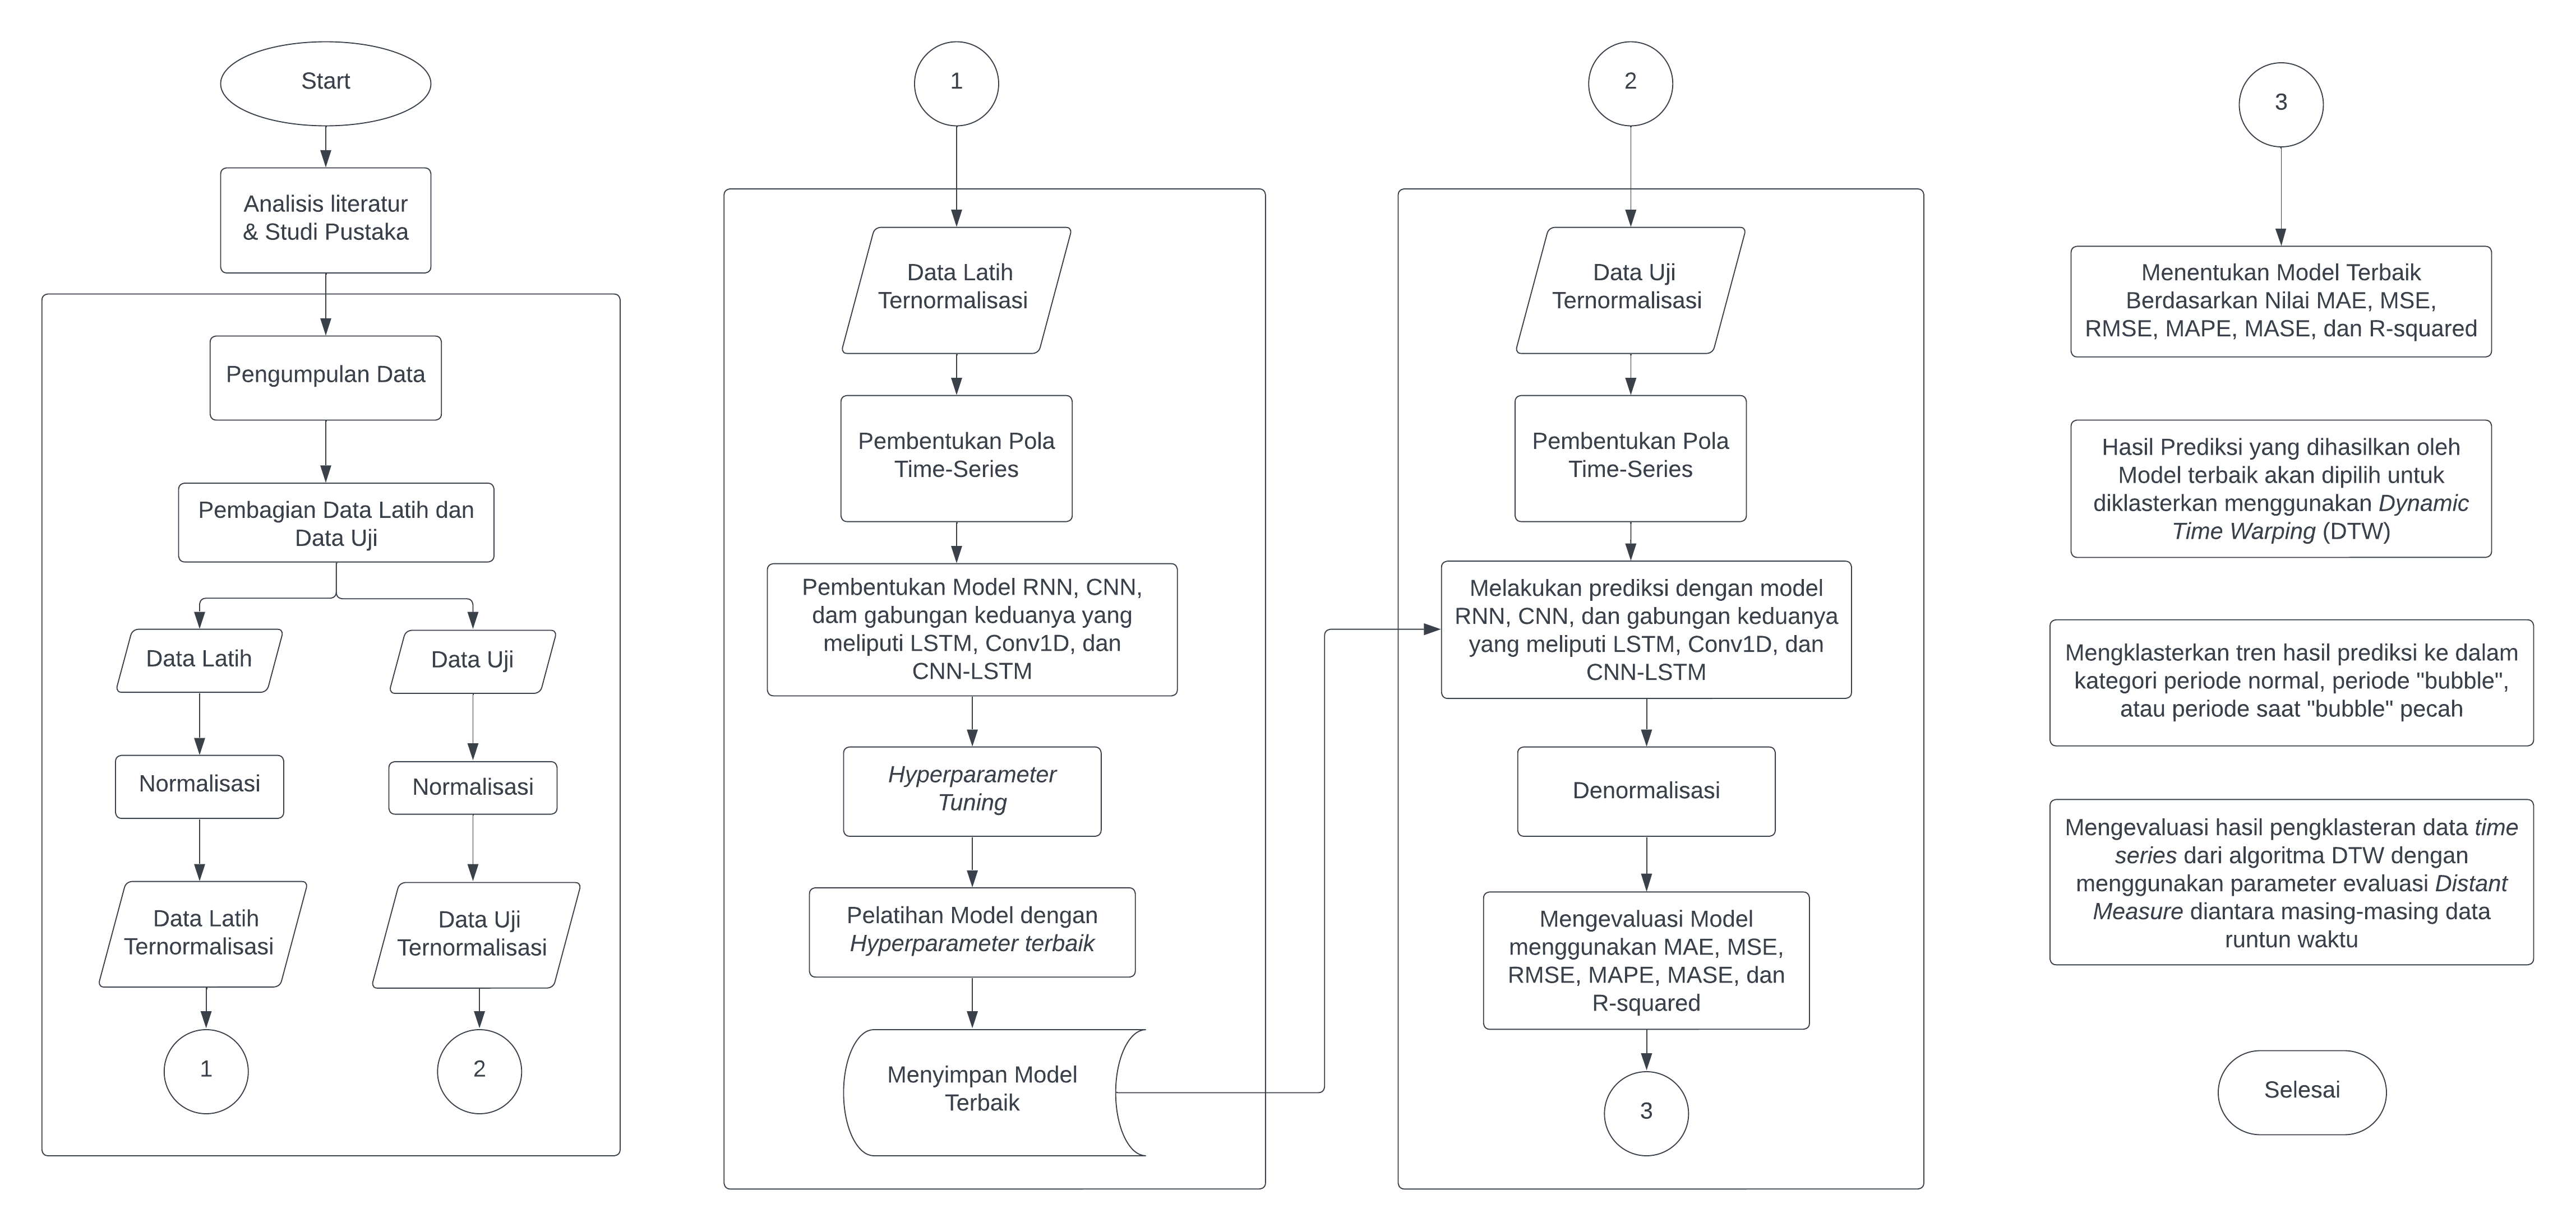

# Menghubungkan ke Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get Data

Sumber data: https://indexes.nikkei.co.jp/en/nkave/archives/data?list=daily


mendownload data harga saham Nikkei225 dengan interval harian dari tahun 1968 sampai 2023

In [2]:
!wget https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/nikkei225/Nikkei225_daily.csv


--2024-03-22 12:33:58--  https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/nikkei225/Nikkei225_daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 886390 (866K) [text/plain]
Saving to: ‘Nikkei225_daily.csv’

Nikkei225_daily.csv 100%[===================>] 865.62K  --.-KB/s    in 0.05s   

2024-03-22 12:33:59 (18.3 MB/s) - ‘Nikkei225_daily.csv’ saved [886390/886390]



## Import data time series dengan pandas

In [3]:
# import dengan pandas
import pandas as pd

# konversi format nilai
def convert_value(value):
    # jika value bukan '-' merubah format desimal (contoh : 30,056 -> 30056)
    if value != '-':
        return float(value.replace(',', ''))
    else:
        return None

# membaca data saham Nikkei225
nikkei225_df = pd.read_csv("/content/Nikkei225_daily.csv",
                           parse_dates = ["Date"],
                           index_col = ["Date"],
                           converters = {'Open': convert_value,
                                         'High': convert_value,
                                         'Low': convert_value,
                                         'Close': convert_value})
                             #menentukan kolom date dan menentukan kalau kolom 1 (indeks) adalah datetime

nikkei225_df.tail()

Open      High       Low     Close
Date                                              
2024-02-22  38508.07  39156.97  38508.07  39098.68
2024-02-26  39320.64  39388.08  39181.03  39233.71
2024-02-27  39260.78  39426.29  39113.03  39239.52
2024-02-28  39189.22  39283.95  39075.47  39208.03
2024-02-29  38935.53  39250.12  38876.81  39166.19

In [4]:
nikkei225_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20078 entries, 1950-01-04 to 2024-02-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    9685 non-null   float64
 1   High    9685 non-null   float64
 2   Low     9685 non-null   float64
 3   Close   20078 non-null  float64
dtypes: float64(4)
memory usage: 784.3 KB


data saham hanya digunakan saat harga close

In [5]:
nikkei225_close_df = pd.DataFrame(nikkei225_df["Close"]).rename(columns={"Close": "Closing Price (Yen)"})
nikkei225_close_df.tail()


Closing Price (Yen)
Date                           
2024-02-22             39098.68
2024-02-26             39233.71
2024-02-27             39239.52
2024-02-28             39208.03
2024-02-29             39166.19

Informasi jumlah data

In [6]:
len(nikkei225_df)

20078

menampilkan missing data

In [7]:
# List the rows where the 'Close' column is nullC
rows_with_null_close = nikkei225_close_df[nikkei225_close_df['Closing Price (Yen)'].isnull()]
print(rows_with_null_close)

Empty DataFrame
Columns: [Closing Price (Yen)]
Index: []


In [8]:

nikkei225_close_df.isnull().sum()

Closing Price (Yen)    0
dtype: int64

# Bagian membuat multivariate time series dataset.

selain menggunakan data nikkei225, perdiksi harga saham akan dibantu dengan data discount rate

multivariate time series akan menambahkan fitur lebih banyak dari univariate time series yang hanya satu fitur

import file csv





In [9]:
!wget https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/discountRate/discountRate.csv

--2024-03-22 12:34:01--  https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/discountRate/discountRate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11737 (11K) [text/plain]
Saving to: ‘discountRate.csv’

discountRate.csv    100%[===================>]  11.46K  --.-KB/s    in 0s      

2024-03-22 12:34:01 (99.4 MB/s) - ‘discountRate.csv’ saved [11737/11737]



# Import data time seres tambahan: discount rate

import data discount rate

In [10]:
# import dengan pandas
import pandas as pd
# membaca data discount rate
discRate_df = pd.read_csv("/content/discountRate.csv",
                           parse_dates = ["Date"],
                           index_col = ["Date"])
                             #menentukan kolom date dan menentukan kalau kolom 1 (indeks) adalah datetime

discRate_df[-3:]

discountRate
Date                    
2023-12-01           0.3
2024-01-01           0.3
2024-02-01           0.3

In [11]:
len(discRate_df)

890

menampilkan missing data

In [12]:
print(discRate_df.isnull().sum())

discountRate    0
dtype: int64


import data discount rate dengan modul csv.reader

In [13]:
# import dan format historikal data dengan python

import csv
from datetime import datetime

timesteps_discountRate = []
discountRate_value = []

with open("/content/discountRate.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) #untuk tidak membaca baris pertama berisi judul kolom
  for line in csv_reader:
    if line[1] == "null":
      continue
    timesteps_discountRate.append(datetime.strptime(line[0], "%Y/%m")) #membaca tanggal sbg DATE
    discountRate_value.append(float(line[1])) #membaca nilai discount rate


In [14]:
timesteps_discountRate[:3], discountRate_value[:3]

([datetime.datetime(1950, 1, 1, 0, 0),
  datetime.datetime(1950, 2, 1, 0, 0),
  datetime.datetime(1950, 3, 1, 0, 0)],
 [5.11, 5.11, 5.11])

In [15]:
len(discountRate_value)

890

In [16]:
type(timesteps_discountRate), type(discountRate_value)

(list, list)

In [17]:
len(discountRate_value)

890

# Mengumpulkan data menjadi satu dataframe

In [18]:
# membuat dataframe untuk mengumpulkan semua data multivariate

# copy dataframe nikkei yang masih hanya berisi harga saham
nikkei225_close_multivariate_df = nikkei225_close_df.copy()

# menambahkan kolom money stock dan dsicount rate

nikkei225_close_multivariate_df["discount_rate"] = None
nikkei225_close_multivariate_df

Closing Price (Yen) discount_rate
Date                                         
1950-01-04               108.56          None
1950-01-05               105.54          None
1950-01-06               102.64          None
1950-01-07               102.95          None
1950-01-09               102.78          None
...                         ...           ...
2024-02-22             39098.68          None
2024-02-26             39233.71          None
2024-02-27             39239.52          None
2024-02-28             39208.03          None
2024-02-29             39166.19          None

[20078 rows x 2 columns]

menggabungkan data discount rate dan money supply ke dataframe Nikkei225 closing price

In [19]:
for x in range(len(timesteps_discountRate)):
  for y in range(len(nikkei225_close_multivariate_df.index)):
    IntervalBulan_timesteps_atrYEAR = timesteps_discountRate[x].year
    IntervalBulan_timesteps_atrMONTH = timesteps_discountRate[x].month
    IntervalBulan_timesteps_atrDAY = timesteps_discountRate[x].day

    IntervalHarian_timesteps_atrYEAR = nikkei225_close_multivariate_df.index[y].year
    IntervalHarian_timesteps_atrMONTH = nikkei225_close_multivariate_df.index[y].month
    IntervalHarian_timesteps_atrDAY = nikkei225_close_multivariate_df.index[y].day

    if IntervalBulan_timesteps_atrYEAR == IntervalHarian_timesteps_atrYEAR and IntervalBulan_timesteps_atrMONTH == IntervalHarian_timesteps_atrMONTH:
      string_tanggal = "{tahun}-{bulan}-{tanggal}".format(tahun = IntervalHarian_timesteps_atrYEAR, bulan = IntervalHarian_timesteps_atrMONTH, tanggal = IntervalHarian_timesteps_atrDAY)
      date_to_index = pd.to_datetime(string_tanggal)
      nikkei225_close_multivariate_df.loc[date_to_index, "discount_rate"] = discountRate_value[x]

In [20]:
discRate_df[80:90]

discountRate
Date                    
1956-09-01          7.30
1956-10-01          7.30
1956-11-01          7.30
1956-12-01          7.30
1957-01-01          7.30
1957-02-01          7.30
1957-03-01          7.67
1957-04-01          7.67
1957-05-01          8.40
1957-06-01          8.40

In [21]:
nikkei225_close_multivariate_df[11520:11600]

Closing Price (Yen) discount_rate
Date                                         
1989-04-26             33434.93           2.5
1989-04-27             33500.83           2.5
1989-04-28             33713.35           2.5
1989-05-01             33793.17          3.25
1989-05-02             33954.99          3.25
...                         ...           ...
1989-08-14             34671.62          3.25
1989-08-15             34810.69          3.25
1989-08-16             35084.15          3.25
1989-08-17             35090.11          3.25
1989-08-18             35063.14          3.25

[80 rows x 2 columns]

In [22]:
type(nikkei225_close_multivariate_df.index.tolist())

list

# Visualisasi data : Membuat fungsi untuk visualisasi (plotting)


In [23]:
# membuat fungsi untuk menggambar data time series

import matplotlib.pyplot as plt

def plot_time_series(timesteps, values, format= ".", start = 0, end =None, label = None, color = None):
  """
  Memvisualisasikan timesteps (serangkaian keterangan waktu dengan interval tertentu) terhadap nilainya pada timesteps yang bersesuaian
  Parameters
  -------------
  timesteps : kumpulan timestep
  values : kumpulan nilai (saham dan discount Rate)
  format : style grafik, default "."
  start : timesteps rentang awal yang divisualisasi
  end : timesteps rentang akhir yang divisualisasi
  label : untuk memberi keterangan grafik
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label, color = color)
  plt.xlabel("Tanggal")
  plt.ylabel("Saham Nikkei225 Penutupan (harian)")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)


Visualisasi data saham nikkei225

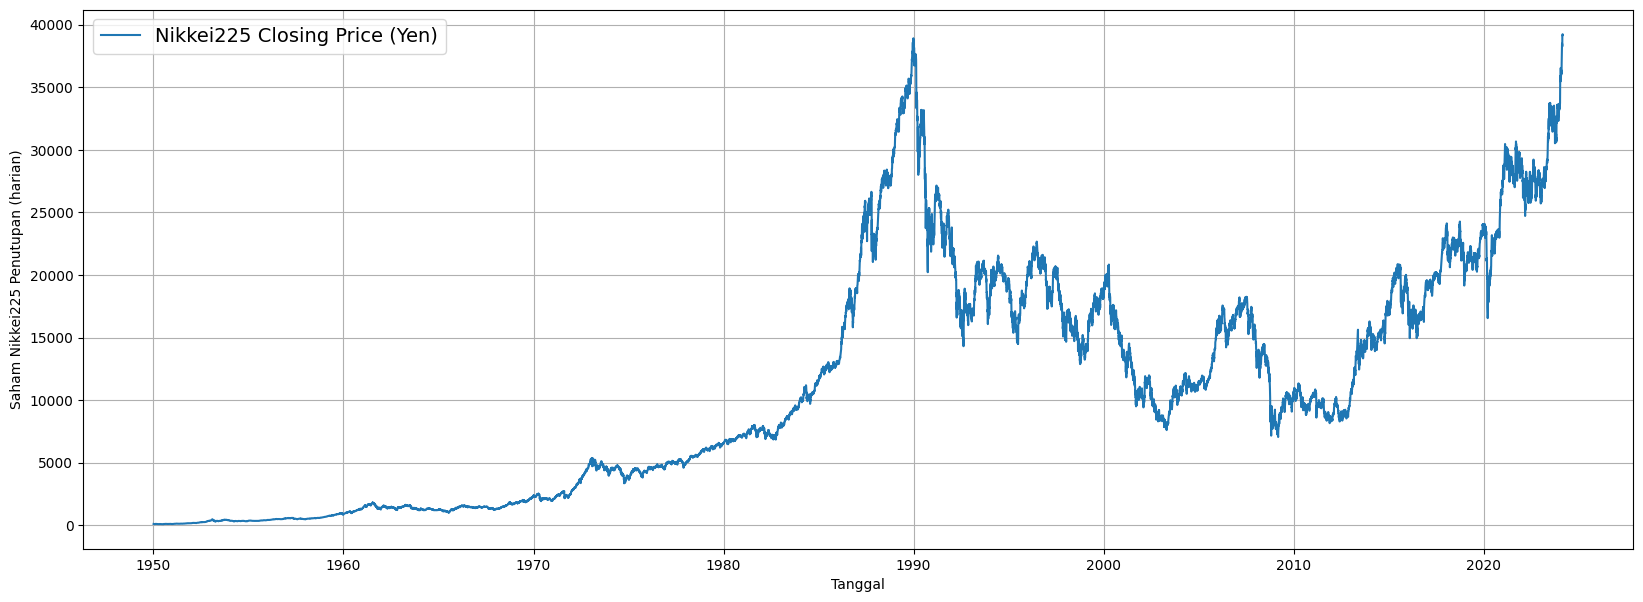

In [24]:

plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['Closing Price (Yen)'].tolist(), format = "-", label = "Nikkei225 Closing Price (Yen)")


Visualisasi data discount rate

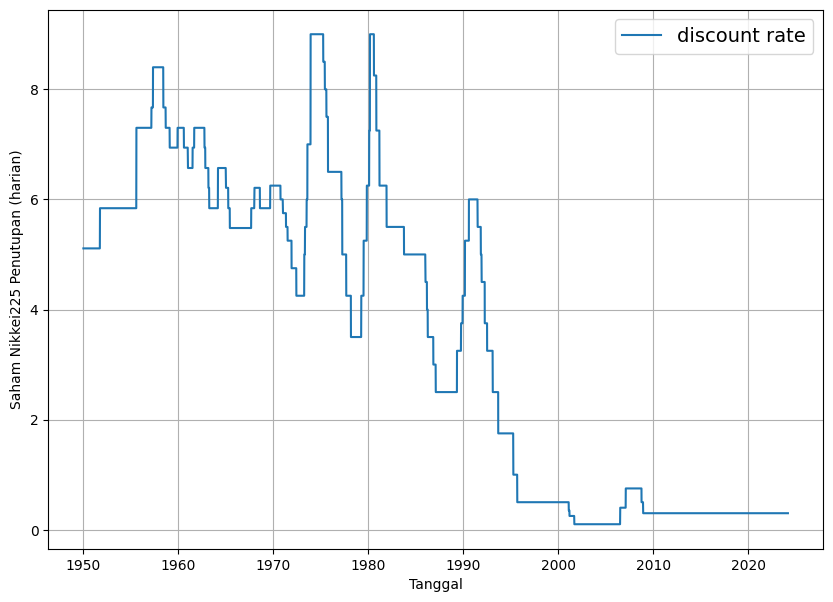

In [25]:

plt.figure(figsize = (10,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['discount_rate'].tolist(), format = "-", label = "discount rate")


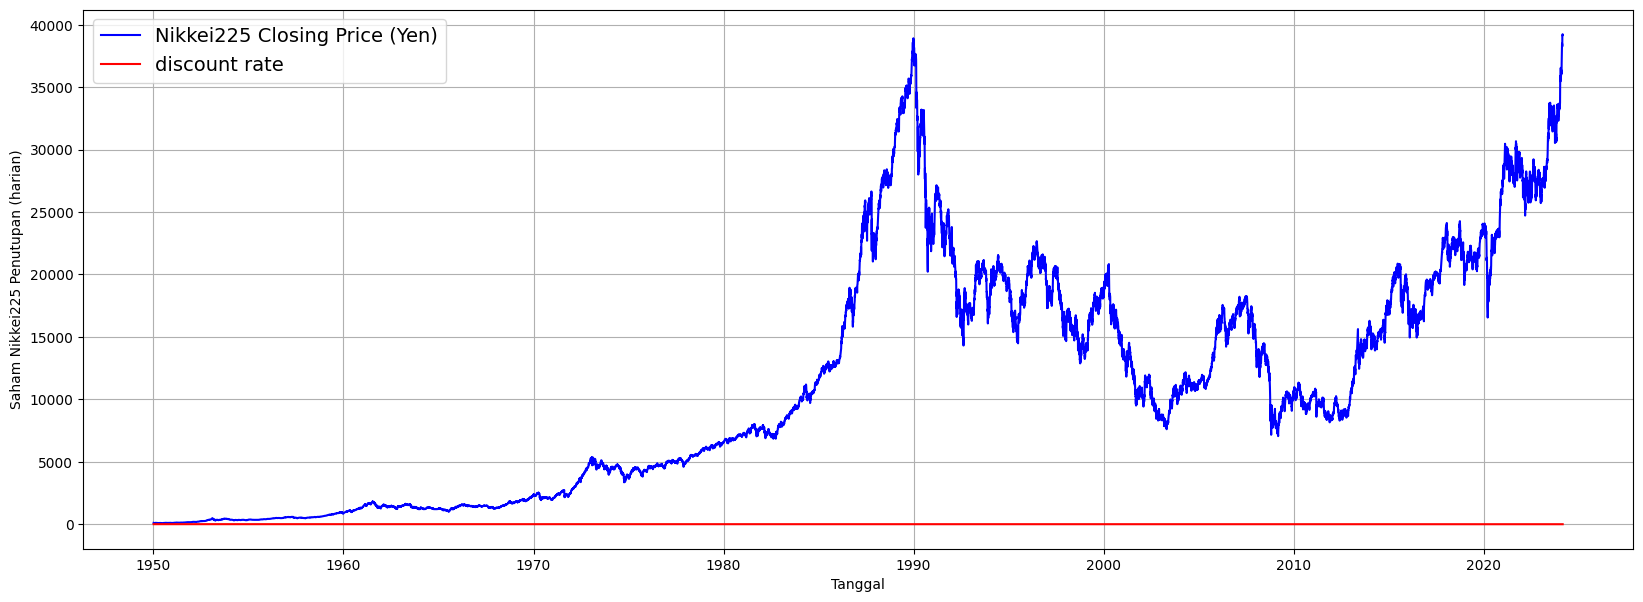

In [26]:
plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['Closing Price (Yen)'].tolist(), format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['discount_rate'].tolist(), format = "-", label = "discount rate", color = 'r')


# Melakukan normalisasi dataset

In [27]:

from sklearn.preprocessing import MinMaxScaler

# meinputkan data ke MinMaxScaler
scaler_multivariate = MinMaxScaler(feature_range=(0, 1))
scaler_multivariate.fit(nikkei225_close_multivariate_df)

MinMaxScaler()

In [28]:
scaler_univariate = MinMaxScaler(feature_range = (0,1))

# mengimplementasikan scaler khusus univariate ke data saham nikkei225 saja
scaler_univariate.fit(nikkei225_close_df["Closing Price (Yen)"].values.reshape(-1, 1))

MinMaxScaler()

In [29]:
# Melakukan normalization
scaler_multivariate.transform(nikkei225_close_multivariate_df)

array([[5.95337367e-04, 5.62921348e-01],
       [5.18206571e-04, 5.62921348e-01],
       [4.44140575e-04, 5.62921348e-01],
       ...,
       [1.00000000e+00, 2.24719101e-02],
       [9.99195745e-01, 2.24719101e-02],
       [9.98127152e-01, 2.24719101e-02]])

membuat dataframe dengan nilai normalized

In [30]:
normalized_data  = scaler_multivariate.transform(nikkei225_close_multivariate_df)
normalized_data


array([[5.95337367e-04, 5.62921348e-01],
       [5.18206571e-04, 5.62921348e-01],
       [4.44140575e-04, 5.62921348e-01],
       ...,
       [1.00000000e+00, 2.24719101e-02],
       [9.99195745e-01, 2.24719101e-02],
       [9.98127152e-01, 2.24719101e-02]])

In [31]:
print ("dataset_normalized.shape" , normalized_data.shape)

dataset_normalized.shape (20078, 2)


In [32]:
normalized_data[:,0].reshape(-1, 1)

array([[5.95337367e-04],
       [5.18206571e-04],
       [4.44140575e-04],
       ...,
       [1.00000000e+00],
       [9.99195745e-01],
       [9.98127152e-01]])

In [33]:
type(normalized_data[:,0].reshape(-1, 1))

numpy.ndarray

In [34]:
# konversi array menjadi bentuk dataframe
scaled_nikkei225_close_multivariate_df  = pd.DataFrame(normalized_data, columns=nikkei225_close_multivariate_df.columns)


In [35]:
scaled_nikkei225_close_multivariate_df

Closing Price (Yen)  discount_rate
0                 0.000595       0.562921
1                 0.000518       0.562921
2                 0.000444       0.562921
3                 0.000452       0.562921
4                 0.000448       0.562921
...                    ...            ...
20073             0.996403       0.022472
20074             0.999852       0.022472
20075             1.000000       0.022472
20076             0.999196       0.022472
20077             0.998127       0.022472

[20078 rows x 2 columns]

LAtihan denormalisasi

In [36]:

# # Fit the scaler to your data
# scaler = MinMaxScaler()
# scaler.fit(nikkei225_close_multivariate_df[['discount_rate']])

# # Perform inverse normalization
# inverse_normalized_data = scaler.inverse_transform(scaled_nikkei225_close_multivariate_df[:, 2].reshape(-1, 1))

# print(inverse_normalized_data)

In [37]:
len(scaler_multivariate.transform(nikkei225_close_multivariate_df ))

20078

In [38]:
scaler_multivariate.transform(nikkei225_close_multivariate_df )[:,0].reshape(-1, 1)

array([[5.95337367e-04],
       [5.18206571e-04],
       [4.44140575e-04],
       ...,
       [1.00000000e+00],
       [9.99195745e-01],
       [9.98127152e-01]])

Visualisasi data yang di normalisasi

In [39]:
scaled_nikkei225_close_multivariate_df["discount_rate"]

0        0.562921
1        0.562921
2        0.562921
3        0.562921
4        0.562921
           ...   
20073    0.022472
20074    0.022472
20075    0.022472
20076    0.022472
20077    0.022472
Name: discount_rate, Length: 20078, dtype: float64

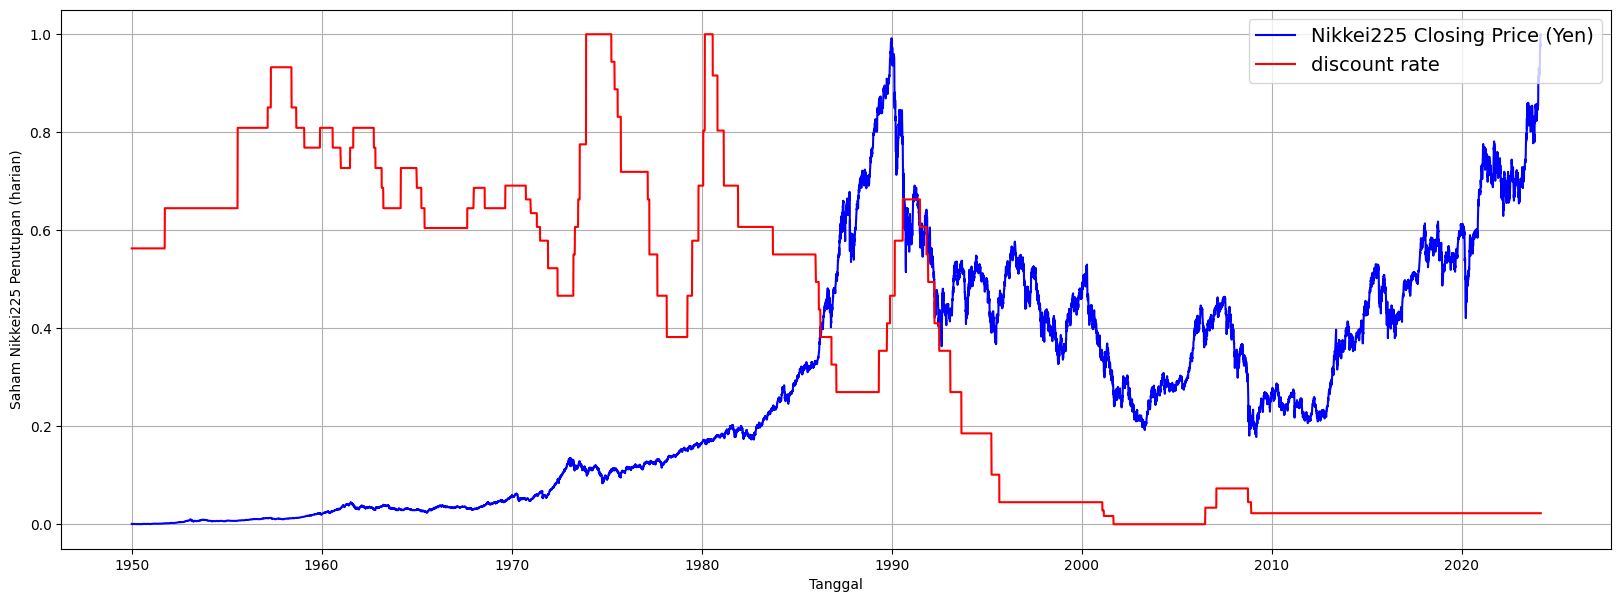

In [40]:

plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = scaled_nikkei225_close_multivariate_df["Closing Price (Yen)"], format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = scaled_nikkei225_close_multivariate_df["discount_rate"], format = "-", label = "discount rate", color = 'r')


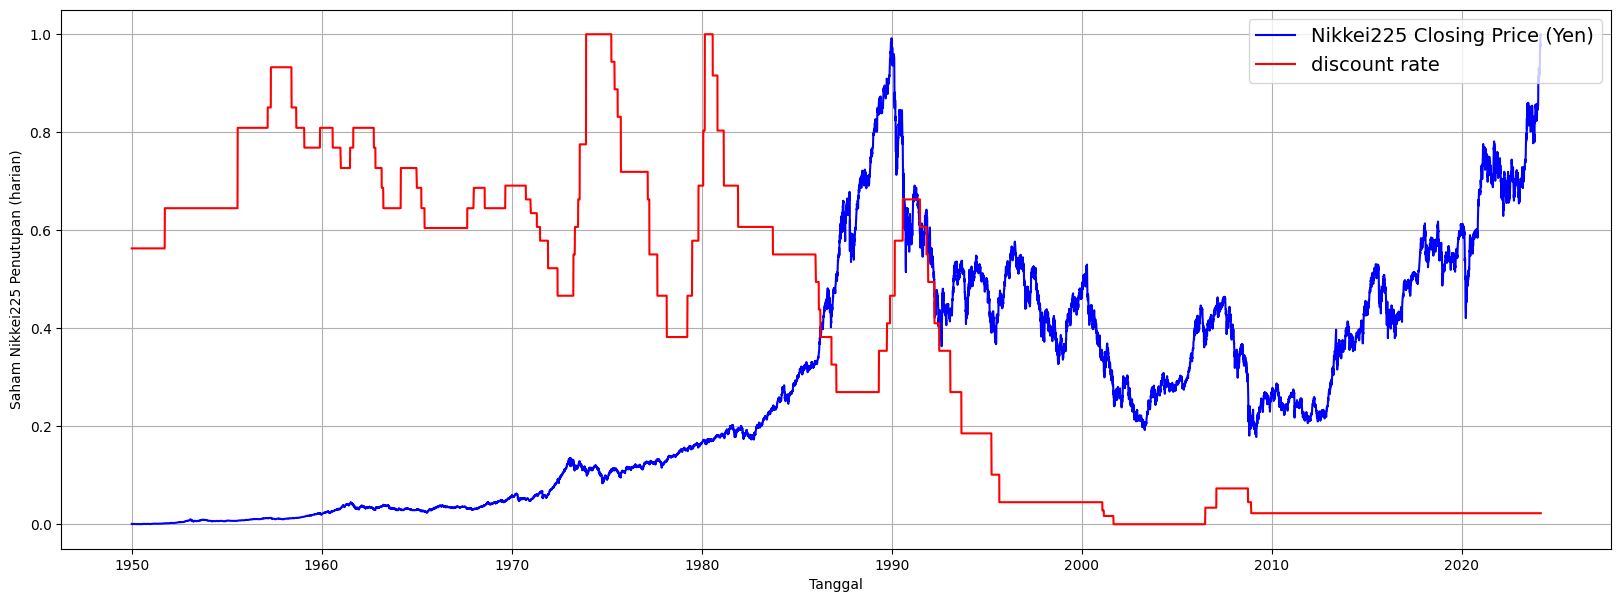

In [41]:
plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = normalized_data[:,0], format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = normalized_data[:,1], format = "-", label = "discount rate", color = 'r')



# Membuat dataset multivariate menjadi format sliding window dengan pendekatan multistep multivariate time series forecasting

In [42]:
# PENGATURAN UNTUK UKURAN INPUT SEQUENCE ATAU LAG ATAU WINDOW

# HORIZON DI ATUR UNTUK MEMILIKI UKUTAN 1 UNTUK MODEL MENGELUARKAN OUTPUT SATU TIMESTEPS SETIAP PREDIKSI
HORIZON = 1
WINDOW_SIZE = 28

# PENGATURAN PRESENTASE DISTRIBUSI DALAM MEMBAGI DATASET KE DALAM TRAIN DAN TEST SET
SPLIT_SIZE = 0.8 # 80% data untuk train test 20% untuk test size

In [43]:
nikkei225_close_multivariate_df[:2]

Closing Price (Yen) discount_rate
Date                                         
1950-01-04               108.56          5.11
1950-01-05               105.54          5.11

In [44]:
scaled_nikkei225_close_multivariate_df[:2]

Closing Price (Yen)  discount_rate
0             0.000595       0.562921
1             0.000518       0.562921

membuat window dan horizon multivariate

In [45]:
# jumlah keseluruhan data sebelum dibentuk menjadi sliding window
len(scaled_nikkei225_close_multivariate_df)

20078

In [46]:
# fungsi untuk membuat sliding window

import numpy as np

def make_dataset(raw_data, WINDOW_SIZE=28, HORIZON = 1):
    _X = []
    _y = []

    for i in range(len(raw_data) - WINDOW_SIZE - HORIZON + 1):
        _X.append(raw_data[i : i + WINDOW_SIZE])
        _y.append(raw_data[i + WINDOW_SIZE : i + WINDOW_SIZE + HORIZON])
    _X = np.array(_X).reshape(len(_X), WINDOW_SIZE, 1)
    _y = np.array(_y).reshape(len(_y), HORIZON, 1)

    return _X, _y

In [47]:
from sklearn import preprocessing

columns = list(scaled_nikkei225_close_multivariate_df.columns)

# memanggil fungsi untuk membuat sliding window
Xs = []
for i in range(len(columns)):
    Xs.append((scaled_nikkei225_close_multivariate_df[columns[i]]))
Xs = np.array(Xs)

X_nikkei, y_nikkei = make_dataset(Xs[0], WINDOW_SIZE = WINDOW_SIZE, HORIZON = HORIZON)
X_discRate, y_discRate = make_dataset(Xs[1], WINDOW_SIZE = WINDOW_SIZE, HORIZON = HORIZON)


# menggabungkan data multivariate untuk windows dan label
X_concat = np.concatenate([X_nikkei, X_discRate], axis=2)
y_concat = np.concatenate([y_nikkei, y_discRate], axis=2)

In [48]:

full_windows = X_concat
full_labels = y_concat

In [49]:
len(full_windows), len(full_labels)

(20050, 20050)

In [50]:
print(full_windows[0]),
print(full_windows.shape)
print("\n")
print(full_labels[0])
print(full_labels.shape)

[[5.95337367e-04 5.62921348e-01]
 [5.18206571e-04 5.62921348e-01]
 [4.44140575e-04 5.62921348e-01]
 [4.52057975e-04 5.62921348e-01]
 [4.47716175e-04 5.62921348e-01]
 [4.11449377e-04 5.62921348e-01]
 [3.60369380e-04 5.62921348e-01]
 [3.12354183e-04 5.62921348e-01]
 [2.50036586e-04 5.62921348e-01]
 [2.97285583e-04 5.62921348e-01]
 [2.79662984e-04 5.62921348e-01]
 [2.55910786e-04 5.62921348e-01]
 [3.03925983e-04 5.62921348e-01]
 [3.48620981e-04 5.62921348e-01]
 [3.26911982e-04 5.62921348e-01]
 [3.32019981e-04 5.62921348e-01]
 [3.02648983e-04 5.62921348e-01]
 [3.03159783e-04 5.62921348e-01]
 [2.87580384e-04 5.62921348e-01]
 [2.60507985e-04 5.62921348e-01]
 [2.45183986e-04 5.62921348e-01]
 [2.44417786e-04 5.62921348e-01]
 [2.01510589e-04 5.62921348e-01]
 [1.86186590e-04 5.62921348e-01]
 [1.86697390e-04 5.62921348e-01]
 [2.73533385e-04 5.62921348e-01]
 [2.77364385e-04 5.62921348e-01]
 [3.11587983e-04 5.62921348e-01]]
(20050, 28, 2)


[[4.20388377e-04 5.62921348e-01]]
(20050, 1, 2)


In [51]:
print(full_windows[1]),
print(full_windows.shape)
print("\n")
print(full_labels[1])
print(full_labels.shape)

[[5.18206571e-04 5.62921348e-01]
 [4.44140575e-04 5.62921348e-01]
 [4.52057975e-04 5.62921348e-01]
 [4.47716175e-04 5.62921348e-01]
 [4.11449377e-04 5.62921348e-01]
 [3.60369380e-04 5.62921348e-01]
 [3.12354183e-04 5.62921348e-01]
 [2.50036586e-04 5.62921348e-01]
 [2.97285583e-04 5.62921348e-01]
 [2.79662984e-04 5.62921348e-01]
 [2.55910786e-04 5.62921348e-01]
 [3.03925983e-04 5.62921348e-01]
 [3.48620981e-04 5.62921348e-01]
 [3.26911982e-04 5.62921348e-01]
 [3.32019981e-04 5.62921348e-01]
 [3.02648983e-04 5.62921348e-01]
 [3.03159783e-04 5.62921348e-01]
 [2.87580384e-04 5.62921348e-01]
 [2.60507985e-04 5.62921348e-01]
 [2.45183986e-04 5.62921348e-01]
 [2.44417786e-04 5.62921348e-01]
 [2.01510589e-04 5.62921348e-01]
 [1.86186590e-04 5.62921348e-01]
 [1.86697390e-04 5.62921348e-01]
 [2.73533385e-04 5.62921348e-01]
 [2.77364385e-04 5.62921348e-01]
 [3.11587983e-04 5.62921348e-01]
 [4.20388377e-04 5.62921348e-01]]
(20050, 28, 2)


[[5.05947372e-04 5.62921348e-01]]
(20050, 1, 2)


In [52]:
print(full_labels[:3])
(full_labels.shape)

[[[4.20388377e-04 5.62921348e-01]]

 [[5.05947372e-04 5.62921348e-01]]

 [[5.61879969e-04 5.62921348e-01]]]


(20050, 1, 2)

format training atau test data pada **window/fitur** adalah **(jumlah sample, ukuran window, jumlah variable)**

In [53]:
full_windows.shape

(20050, 28, 2)

format training atau test data pada **label** adalah **(jumlah sample, jumlah variabel)** [Hanya memiliki dua dimensi shape jika ingin dengan benar menghasilkan output yang sesuai]

In [54]:
full_labels.shape

(20050, 1, 2)

In [55]:
full_labels = np.squeeze(full_labels)
full_labels.shape

(20050, 2)

In [56]:
full_labels[:3]

array([[4.20388377e-04, 5.62921348e-01],
       [5.05947372e-04, 5.62921348e-01],
       [5.61879969e-04, 5.62921348e-01]])

Membagi data menjadi training dataset dan test data set. Pembagian data menjadi train dan test dengan train series split dimana Test dataset akan menggunakan data yang pseusdo future (data yang seakan2 berperan dari masa depan).

In [57]:
len(full_windows[: int(SPLIT_SIZE * len(full_windows))])

16040

In [58]:
# Membagi full sliding windows menjadi windows untuk train dan test begitu pula untuk label
train_windows = full_windows[:len(full_windows[: int(SPLIT_SIZE * len(full_windows))])]
test_windows = full_windows[len(full_windows[: int(SPLIT_SIZE * len(full_windows))]):]

train_labels = full_labels[:len(full_windows[: int(SPLIT_SIZE * len(full_labels))])]
test_labels = full_labels[len(full_windows[: int(SPLIT_SIZE * len(full_labels))]):]

In [59]:
print("jumlah sliding windows keseluruhan adalah :{n_full_windows}".format(n_full_windows = len(full_windows)))

print("Sliding windows untuk train berjumlah : {n_train_windows}".format(n_train_windows = len(train_windows)))
print("Sliding windows untuk test berjumlah : {n_test_windows}".format(n_test_windows = len(test_windows)))


jumlah sliding windows keseluruhan adalah :20050
Sliding windows untuk train berjumlah : 16040
Sliding windows untuk test berjumlah : 4010


In [60]:
print("jumlah label keseluruhan adalah :{n_full_labels}".format(n_full_labels = len(full_labels)))

print("label untuk train berjumlah : {n_train_labels}".format(n_train_labels = len(train_labels)))
print("label untuk test berjumlah : {n_test_labels}".format(n_test_labels = len(test_labels)))


jumlah label keseluruhan adalah :20050
label untuk train berjumlah : 16040
label untuk test berjumlah : 4010


In [61]:
"windows", test_windows[:2], "Labels",test_labels[:2]

('windows',
 array([[[0.41416019, 0.07303371],
         [0.41380519, 0.07303371],
         [0.40679037, 0.07303371],
         [0.41039125, 0.07303371],
         [0.42099725, 0.07303371],
         [0.4198694 , 0.07303371],
         [0.4172015 , 0.07303371],
         [0.41050951, 0.07303371],
         [0.41302647, 0.07303371],
         [0.40958266, 0.07303371],
         [0.40046003, 0.07303371],
         [0.40333838, 0.07303371],
         [0.4012934 , 0.07303371],
         [0.40189589, 0.07303371],
         [0.409717  , 0.07303371],
         [0.40140066, 0.07303371],
         [0.41620722, 0.07303371],
         [0.41703089, 0.07303371],
         [0.41444675, 0.07303371],
         [0.41672288, 0.07303371],
         [0.41759149, 0.07303371],
         [0.42771759, 0.07303371],
         [0.42652921, 0.07303371],
         [0.42806851, 0.07303371],
         [0.43319745, 0.07303371],
         [0.43710788, 0.07303371],
         [0.43436489, 0.07303371],
         [0.43366381, 0.07303371]],
 
     

# LANJUT MEMBUAT FUNGSI EVALUASI DAN BIKIN MODEL

# Membuat fungsi untuk melakukan evaluasi regression problem

fungsi digunakan untuk menguji prediksi model dengan nilai sebenarnya dan menghasilkan nilai evaluasi masing-masing metrik

In [62]:
import tensorflow as tf


sehingga yang dilakukan dengan tf.reduce_mean adalah melakukan agregasi ke banyak nilai mae akibat dari horizon yang ukurannya lebih dari satu menjadi satu single value seperti yang dilakukan tensorflow

tf.reduce_mean mampu menghasilkan satu nilai mae yang sudah direratakan dan hasilnya sama dengan yang dihitung dari model saat evaluasi metrik MAE-nya dengan .evaluate, menghasilkan nilai MAE yang sama-sama 892.1709

In [63]:
def evaluate_preds(y_true, y_pred):
  #Pastikan data yang diproses dengan library tensorflow bertipe float32
  y_true = tf.cast(y_true, dtype = tf.float32) #karena metrik evaluasi dari library tensorflow bisa
  y_pred = tf.cast(y_pred, dtype = tf.float32) #memunculkan error jika tipe bukan float32

  y_true = tf.squeeze(y_true)
  y_pred = tf.squeeze(y_pred)

  # menghitung metrik evaluasi regression problem
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)

  # kalkulasi nilai R-square
  from sklearn.metrics import r2_score
  Rsquare = r2_score(y_true, y_pred)



  ## memperhitungkan berbagai ukuran metrics
  # (artinya untuk horizon atau label yang dimensinya (fiturnya) lebih dari satu akan menghasilkan metrics (ex: MAE) yang berukuran dimensi lbh dari satu,
  # sehingga perlu di lakukan tf.reduce_mean lebih lanjut supaya menghasilkan single value metrics)
  # Artinya nilai MAE yang di reduce_mean adalah gabungan dari MAE dari beberapa fitur tersebut

  # Calculate various metrics
  # (meaning for larger horizon will produce metrics (ex: MAE) with larger dimension,
  # so tf.reduce_mean is needed to produce single value metrics)
  if mae.ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    #Rsquare = tf.reduce_mean(Rsquare)

    # Calculate R-square value
    from sklearn.metrics import r2_score
    Rsquare = np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

  return {"mae" : mae.numpy(), #ditampilkan dalam bentuk numpy bukan tensor
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "R-square" : Rsquare}


# membuat modelling checkpoint

karena model akan belajar terus menerus pada masing-masing epoch, diantara epoch-epoch tersebut dapat menghasilkan pembelajaran terbaik tidak hanya di eopch terakhir saja. Maka dari itu, epoch yang memiliki hasil terbaik akan di simpan selama training.  

Dengan menyimpan epoch yang terbaik, model yang akan dibuat adalah model yang terbaik dan dapat dibandingkan dengan model terbaik lainnya secara adil.

Untuk membuat modelling checkpoint callback digunakan: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [64]:
# membuat modelling checkpoint

import os # membuat folder untuk menyimpan best model

# mmebuat function untuk implementasi ModelCheckpoint callback
def create_model_checkpoint(model_name, save_path = "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                                                    monitor = "val_loss",
                                                                    verbose = 1,
                                                                    save_best_only = True)

In [65]:
train_windows.shape

(16040, 28, 2)

In [66]:
train_windows[0:2]

array([[[5.95337367e-04, 5.62921348e-01],
        [5.18206571e-04, 5.62921348e-01],
        [4.44140575e-04, 5.62921348e-01],
        [4.52057975e-04, 5.62921348e-01],
        [4.47716175e-04, 5.62921348e-01],
        [4.11449377e-04, 5.62921348e-01],
        [3.60369380e-04, 5.62921348e-01],
        [3.12354183e-04, 5.62921348e-01],
        [2.50036586e-04, 5.62921348e-01],
        [2.97285583e-04, 5.62921348e-01],
        [2.79662984e-04, 5.62921348e-01],
        [2.55910786e-04, 5.62921348e-01],
        [3.03925983e-04, 5.62921348e-01],
        [3.48620981e-04, 5.62921348e-01],
        [3.26911982e-04, 5.62921348e-01],
        [3.32019981e-04, 5.62921348e-01],
        [3.02648983e-04, 5.62921348e-01],
        [3.03159783e-04, 5.62921348e-01],
        [2.87580384e-04, 5.62921348e-01],
        [2.60507985e-04, 5.62921348e-01],
        [2.45183986e-04, 5.62921348e-01],
        [2.44417786e-04, 5.62921348e-01],
        [2.01510589e-04, 5.62921348e-01],
        [1.86186590e-04, 5.6292134

In [67]:
train_labels[0:2]

array([[4.20388377e-04, 5.62921348e-01],
       [5.05947372e-04, 5.62921348e-01]])

In [68]:
train_labels.shape

(16040, 2)

In [69]:
test_windows.shape

(4010, 28, 2)

In [70]:
test_labels.shape

(4010, 2)

In [71]:
# keterangan jumlah feature
test_labels.shape[1]

2

Mulai membuat model Keras

In [72]:
import tensorflow as tf
from tensorflow.keras import layers

In [73]:
from keras import Model
from keras.layers import Input, Dense, Bidirectional, LSTM, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from numpy import array, hstack
import numpy as np

# Model 1: Conv1D

In [74]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch


In [76]:
# import library untuk mmebuat model

import tensorflow as tf
from tensorflow.keras import layers

In [77]:
train_windows.shape

(16040, 28, 2)

In [78]:
train_labels.shape

(16040, 2)

In [79]:
test_windows.shape

(4010, 28, 2)

In [80]:
test_labels.shape

(4010, 2)

In [81]:
test_labels.shape[1]

2

## Tuner Builder

In [82]:
#membuat model Conv1D
def model_Conv1D_multi_builder(hp):
  tf.random.set_seed(42)

  model_1 = tf.keras.models.Sequential([


      #layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
      tf.keras.layers.Conv1D(filters = hp.Int('conv1D_n_filters', min_value=32, max_value=256, step=32),
                             kernel_size = hp.Int('conv1D_kernel_size', min_value=5, max_value=10, step=1),
                             strides = 1,
                             padding ="causal",
                             activation = "relu",
                             input_shape=[train_windows.shape[1], train_windows.shape[2]]),

      tf.keras.layers.GlobalMaxPooling1D(),  # Add GlobalMaxPooling1D layer
      tf.keras.layers.Dense(test_labels.shape[1])
      #filters adalah jumlah hidden unit dalam layers tersebut
      # kernel size adalah ukuran dari window. Ex: kernel_size = 7 artinya melihat 7 value sekaligus
      # default nilai strides = 1, ini sudah sesuai karena sliding window bergeser satu timesteps
  ], name = "model_1_conv1D_multivariate")

  #compile model 1
  model_1.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_1


In [ ]:
import keras_tuner as kt

tuner_Conv1D_multi = kt.Hyperband(model_Conv1D_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='Conv1D_multivariate')

## Proses tuning


In [ ]:
tuner_Conv1D_multi.search(train_windows,
                          train_labels,
                          epochs=10,
                          validation_data=(test_windows, test_labels),
                          batch_size = 128)

Trial 30 Complete [00h 00m 17s]
val_loss: 0.01024683192372322

Best val_loss So Far: 0.008815725333988667
Total elapsed time: 00h 03m 34s


## Hasil parameter tuning terbaik

In [ ]:
tuner_Conv1D_multi.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_Conv1D_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
print('Best tune model Conv1D multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model Conv1D multivariate:
conv1D_n_filters: 256
conv1D_kernel_size: 5
learning_rate: 0.001


## Hasil semua parameter tuning

In [ ]:
tuning =['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all =tuner_Conv1D_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_Conv1D_multi.csv')
df_hyparam


conv1D_n_filters  conv1D_kernel_size  learning_rate
0                256                   5         0.0010
1                192                  10         0.0100
2                 32                   7         0.0100
3                 96                  10         0.0001
4                128                   5         0.0010
5                128                   8         0.0100
6                128                   5         0.0010
7                256                   5         0.0010
8                256                   5         0.0010
9                224                  10         0.0100
10                64                   9         0.0010
11               160                   6         0.0010
12               160                   6         0.0010
13                96                  10         0.0001
14                64                   9         0.0010
15                64                  10         0.0100
16               128                   5         0.0010
17                64                  10         0.0100
18                64                   8         0.0010
19               128                   6         0.0100
20                64                   8         0.0001
21                32                  10         0.0010
22               256                   7         0.0001
23               256                  10         0.0001
24               256                   7         0.0100
25               160                   9         0.0100
26                96                   9         0.0001
27               256                   8         0.0100
28               256                  10         0.0100
29                32                   5         0.0001

In [ ]:
tuner_Conv1D_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/Conv1D_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
conv1D_n_filters: 256
conv1D_kernel_size: 5
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.008815725333988667

Trial 0028 summary
Hyperparameters:
conv1D_n_filters: 192
conv1D_kernel_size: 10
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.008849852718412876

Trial 0027 summary
Hyperparameters:
conv1D_n_filters: 32
conv1D_kernel_size: 7
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.009301239624619484

Trial 0024 summary
Hyperparameters:
conv1D_n_filters: 96
conv1D_kernel_size: 10
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1


## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_1 = tuner_Conv1D_multi.hypermodel.build(best_hps)

## Melatih model

In [90]:
from tensorflow.keras.models import load_model

# Load the saved model
model_1 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_1_Conv1D_multivariate.h5")

In [ ]:
# fit
history = model_1.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/50
124/126 [============================>.] - ETA: 0s - loss: 0.0454
Epoch 1: val_loss improved from inf to 0.01318, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_1_conv1D_multivariate
126/126 [==============================] - 3s 18ms/step - loss: 0.0450 - val_loss: 0.0132
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0090
Epoch 2: val_loss improved from 0.01318 to 0.01064, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_1_conv1D_multivariate
126/126 [==============================] - 3s 22ms/step - loss: 0.0090 - val_loss: 0.0106
Epoch 3/50
123/126 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 3: val_loss improved from 0.01064 to 0.01061, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_1_conv1D_multivariate
126/126 [=======================

visualisasi model shape

In [ ]:
model_1.summary()

Model: "model_1_conv1D_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 256)           2816      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 3330 (13.01 KB)
Trainable params: 3330 (13.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


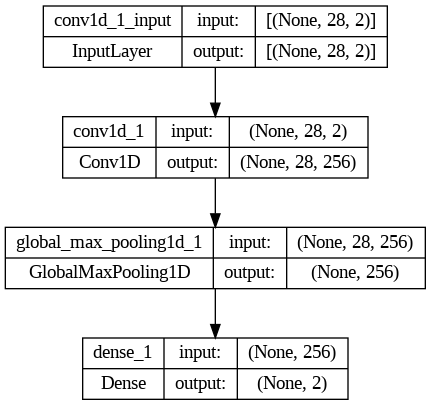

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_1, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_Conv1D_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

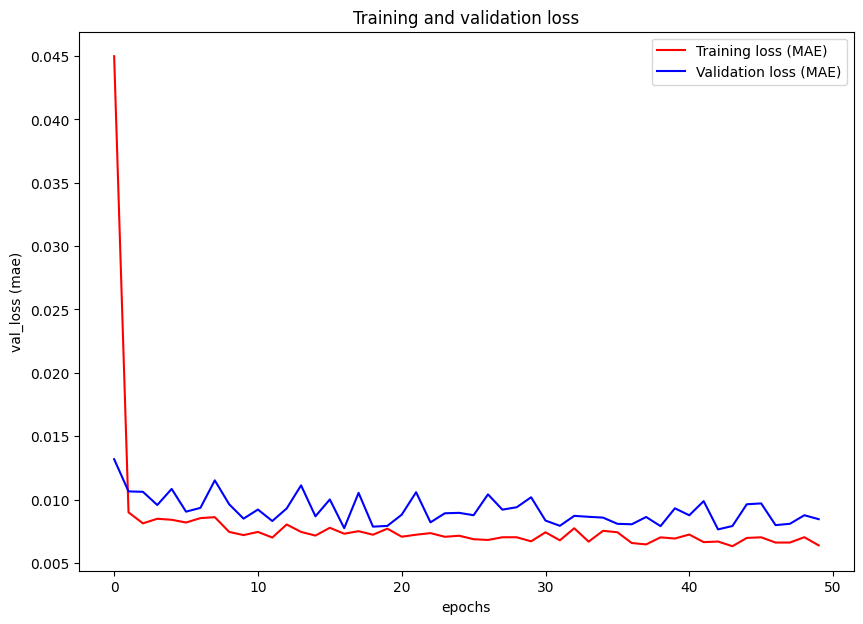

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)



# simpan visualisasi loss per epoch menjadi image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_Conv1D_multi.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_Conv1D_multi.csv', index=False)


In [ ]:
# mengevaluasi model 1 dari epochs terakhir
model_1.evaluate(test_windows, test_labels)

126/126 [==============================] - 0s 3ms/step - loss: 0.0084


0.008447617292404175

In [ ]:
# mengevaluasi dan load model 1 pada best epoch yang loss mae paling kecil sepanjang training

model_1 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_1_conv1D_multivariate")
model_1.evaluate(test_windows, test_labels)


126/126 [==============================] - 0s 2ms/step - loss: 0.0076


0.007640676107257605

In [91]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_1_preds = tf.squeeze(model_1.predict(test_windows))
model_1_preds


126/126 [==============================] - 1s 4ms/step


<tf.Tensor: shape=(4010, 2), dtype=float32, numpy=
array([[0.42163125, 0.07203368],
       [0.42390576, 0.07192257],
       [0.42535454, 0.07186688],
       ...,
       [0.9857444 , 0.03200555],
       [0.9899016 , 0.03215617],
       [0.9928879 , 0.03229861]], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [92]:
denormalized_model_1_preds = scaler_multivariate.inverse_transform(model_1_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [93]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_1_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_1_preds)

model_1_results

{'mae': 263.272,
 'mse': 288595.0,
 'rmse': 372.3113,
 'R-square': 0.954881292232697}

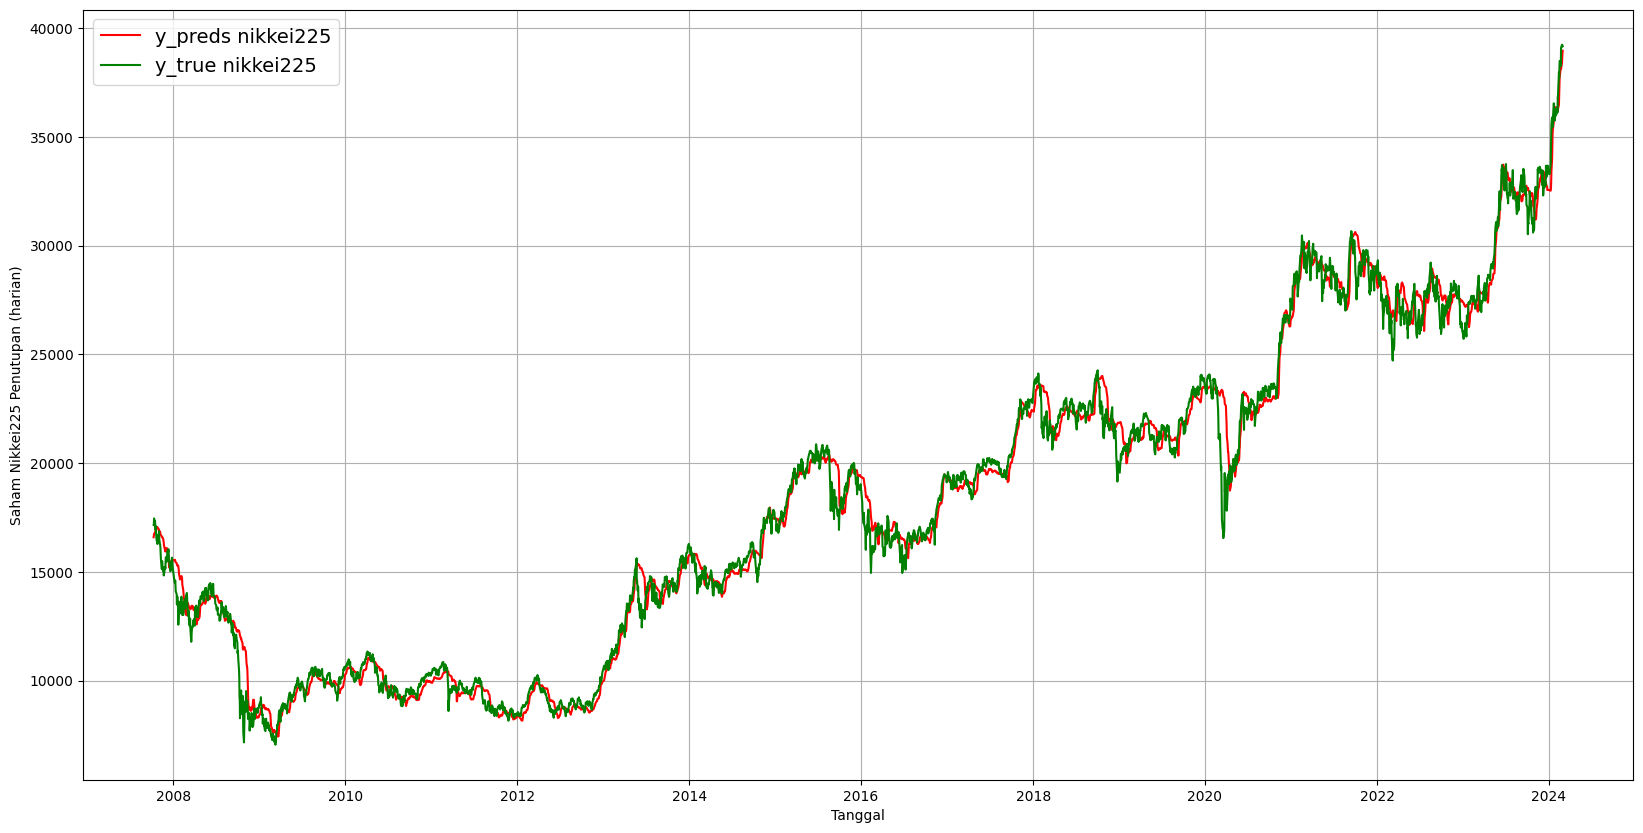

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_1_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_1_plot_prediksi_Conv1D_multi.png')

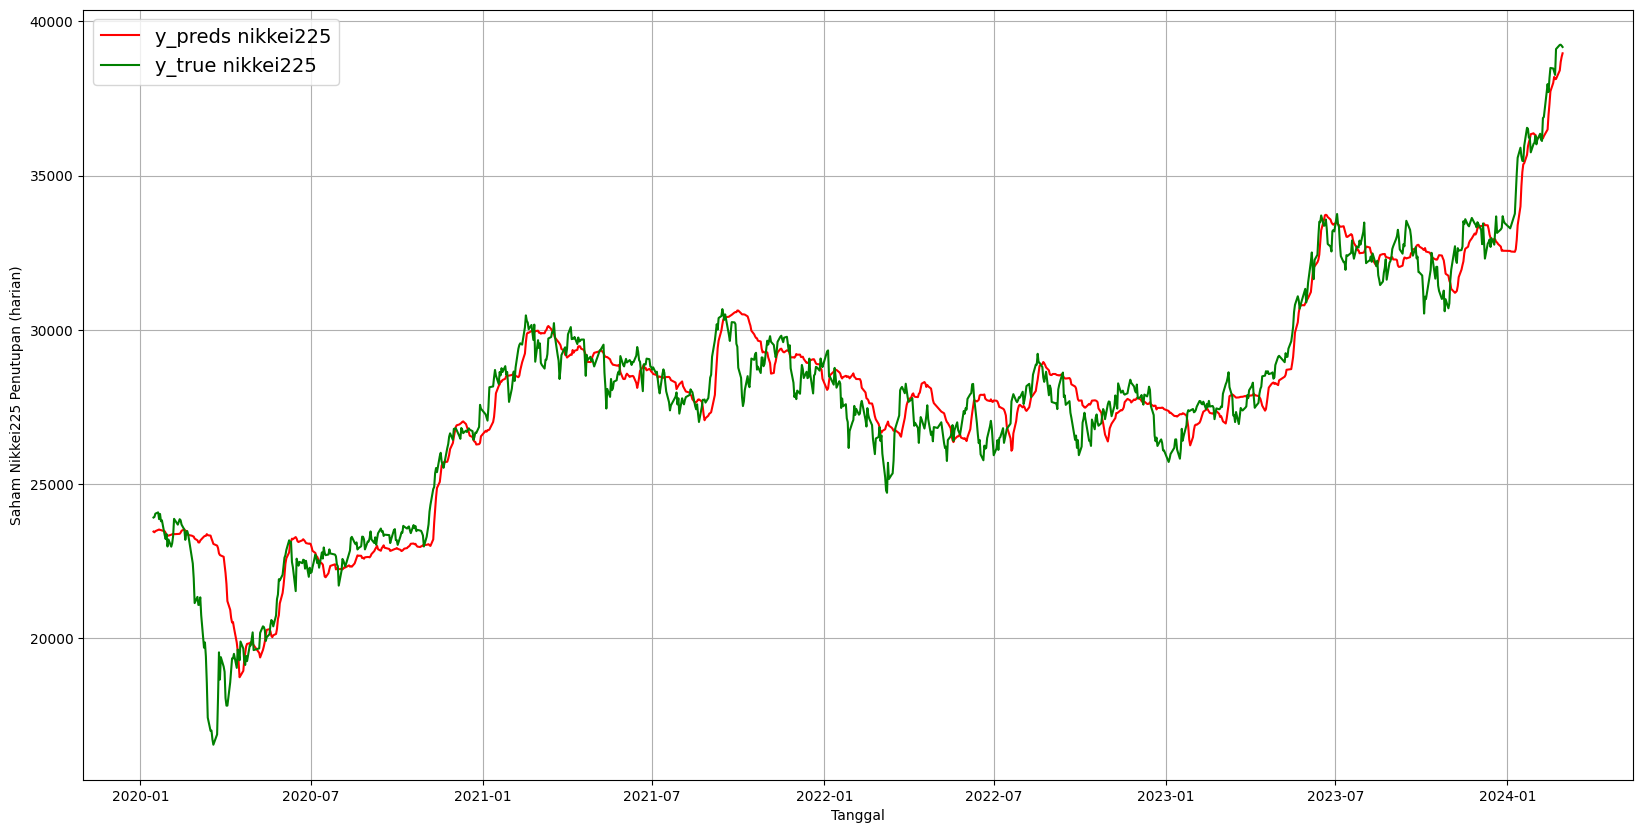

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_1_preds[:,0], format = "-",start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_1_plot_prediksi_Conv1D_multi_zoomin.png')

simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_1, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_1_Conv1D_multivariate.h5")

<ipython-input-101-9755aa33bf57>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_1, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_1_Conv1D_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_1 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_1_Conv1D_multivariate.h5")

# Model 2 : LSTM

In [ ]:
train_windows.shape[2]

2

## Tuner Builder

In [ ]:
# membuat model LSTM dengan hyperparameter tuning

def model_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_2 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units', min_value=32, max_value=256, step=32),
                               input_shape=(train_windows.shape[1], train_windows.shape[2]),
                               return_sequences = False,
                               activation = "relu"),

          #tf.keras.layers.Dropout(0.2),
          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(test_labels.shape[1])
          ], name = "model_2_LSTM_multivariate")



  #compile model 2
  model_2.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_2

In [ ]:
import keras_tuner as kt

tuner_LSTM_multi = kt.Hyperband(model_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='LSTM_multivariate')

## Proses tuning


In [ ]:
tuner_LSTM_multi.search(train_windows,
                        train_labels,
                        epochs=10,
                        validation_data=(test_windows, test_labels),
                        batch_size = 128)

Trial 30 Complete [00h 03m 40s]
val_loss: 0.006525990087538958

Best val_loss So Far: 0.006049171555787325
Total elapsed time: 00h 26m 18s


## Hasil parameter tuning terbaik

In [ ]:
tuner_Conv1D_multi.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units', 'learning_rate']
print('Best tune model LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model LSTM multivariate:
lstm_n_units: 96
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning =['lstm_n_units', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all =tuner_LSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_LSTM_multi.csv')
df_hyparam


lstm_n_units  learning_rate
0             96         0.0100
1             64         0.0010
2            224         0.0001
3             32         0.0100
4            128         0.0010
5             64         0.0100
6            160         0.0001
7             64         0.0010
8             32         0.0100
9             32         0.0010
10           128         0.0010
11           128         0.0100
12            96         0.0100
13            96         0.0100
14           160         0.0010
15            96         0.0010
16            32         0.0100
17           224         0.0010
18           224         0.0010
19           192         0.0010
20           160         0.0100
21           256         0.0100
22           224         0.0100
23           256         0.0010
24           160         0.0100
25           256         0.0001
26           128         0.0001
27            64         0.0001
28           192         0.0100
29            32         0.0001

In [ ]:
tuner_LSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/LSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
lstm_n_units: 96
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.006049171555787325

Trial 0024 summary
Hyperparameters:
lstm_n_units: 64
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.006118886638432741

Trial 0029 summary
Hyperparameters:
lstm_n_units: 224
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.006525990087538958

Trial 0016 summary
Hyperparameters:
lstm_n_units: 32
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.0068379598669707775

Trial 0025 summary
Hyperparameters:
l

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_2 = tuner_LSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [94]:
from tensorflow.keras.models import load_model

# Load the saved model
model_2 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_2_LSTM_multivariate.h5")

In [ ]:

# fit
history = model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/50
125/126 [============================>.] - ETA: 0s - loss: 0.0463
Epoch 1: val_loss improved from inf to 0.01920, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_2_LSTM_multivariate
126/126 [==============================] - 12s 80ms/step - loss: 0.0462 - val_loss: 0.0192
Epoch 2/50
125/126 [============================>.] - ETA: 0s - loss: 0.0121
Epoch 2: val_loss improved from 0.01920 to 0.01233, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_2_LSTM_multivariate
126/126 [==============================] - 11s 84ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 0.0097
Epoch 3: val_loss improved from 0.01233 to 0.01133, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_2_LSTM_multivariate
126/126 [===========================

visualisasi model shape

In [ ]:
model_2.summary()

Model: "model_2_LSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 96)                38016     
                                                                 
 dense_1 (Dense)             (None, 2)                 194       
                                                                 
Total params: 38210 (149.26 KB)
Trainable params: 38210 (149.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


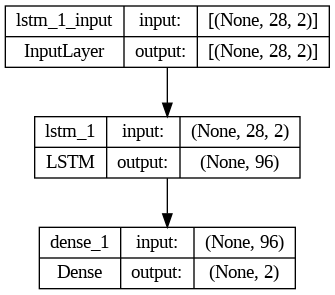

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(model_2, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_LSTM_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

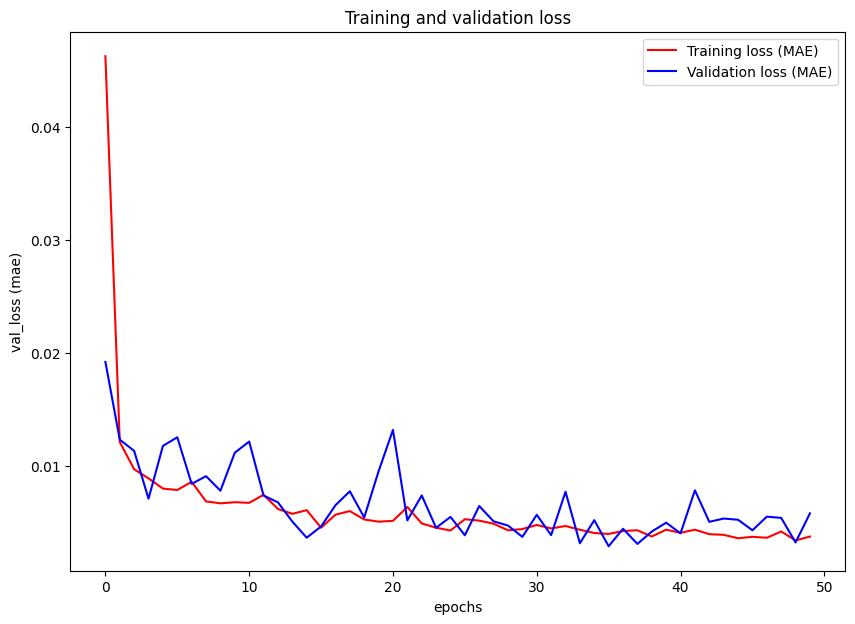

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)


# simpan visualisasi loss per epoch menjadi image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_LSTM_multi.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_LSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 2 dari epochs terakhir
model_2.evaluate(test_windows, test_labels)

126/126 [==============================] - 1s 9ms/step - loss: 0.0058


0.005813314579427242

In [ ]:
# mengevaluasi dan load model 2 pada best epoch yang loss mae paling kecil sepanjang training

model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_2_LSTM_multivariate")
model_2.evaluate(test_windows, test_labels)


126/126 [==============================] - 2s 10ms/step - loss: 0.0029


0.0029074836056679487

In [96]:
# membuat predicted value berdasarkan model multivariate model_2 yang sudah di train

model_2_preds = tf.squeeze(model_2.predict(test_windows))
model_2_preds



126/126 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(4010, 2), dtype=float32, numpy=
array([[0.43358684, 0.07392491],
       [0.43579972, 0.07382941],
       [0.43621984, 0.07386515],
       ...,
       [1.0018175 , 0.02679038],
       [1.0055422 , 0.02628416],
       [1.0036993 , 0.02624337]], dtype=float32)>

In [97]:
model_2_preds[:,1]

<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.07392491, 0.07382941, 0.07386515, ..., 0.02679038, 0.02628416,
       0.02624337], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [98]:
denormalized_model_2_preds = scaler_multivariate.inverse_transform(model_2_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [99]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_2_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_2_preds)

model_2_results

{'mae': 90.6916,
 'mse': 32233.002,
 'rmse': 128.24985,
 'R-square': 0.9918081513411403}

In [ ]:
tf.squeeze(test_labels[:,0])

<tf.Tensor: shape=(4010,), dtype=float64, numpy=
array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])>

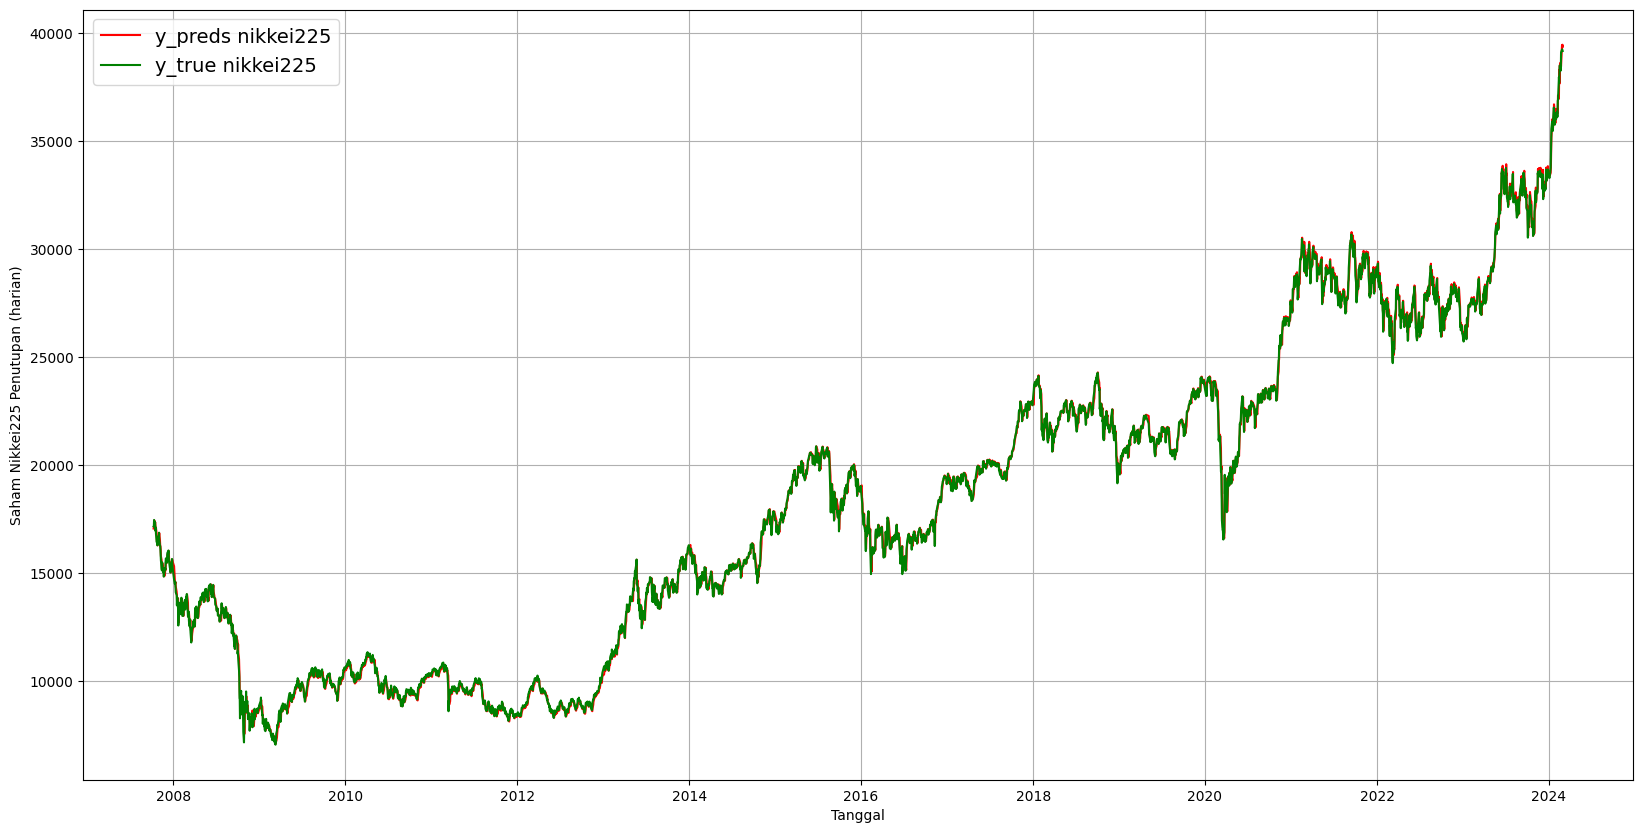

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_2_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_2_plot_prediksi_LSTM_multi.png')

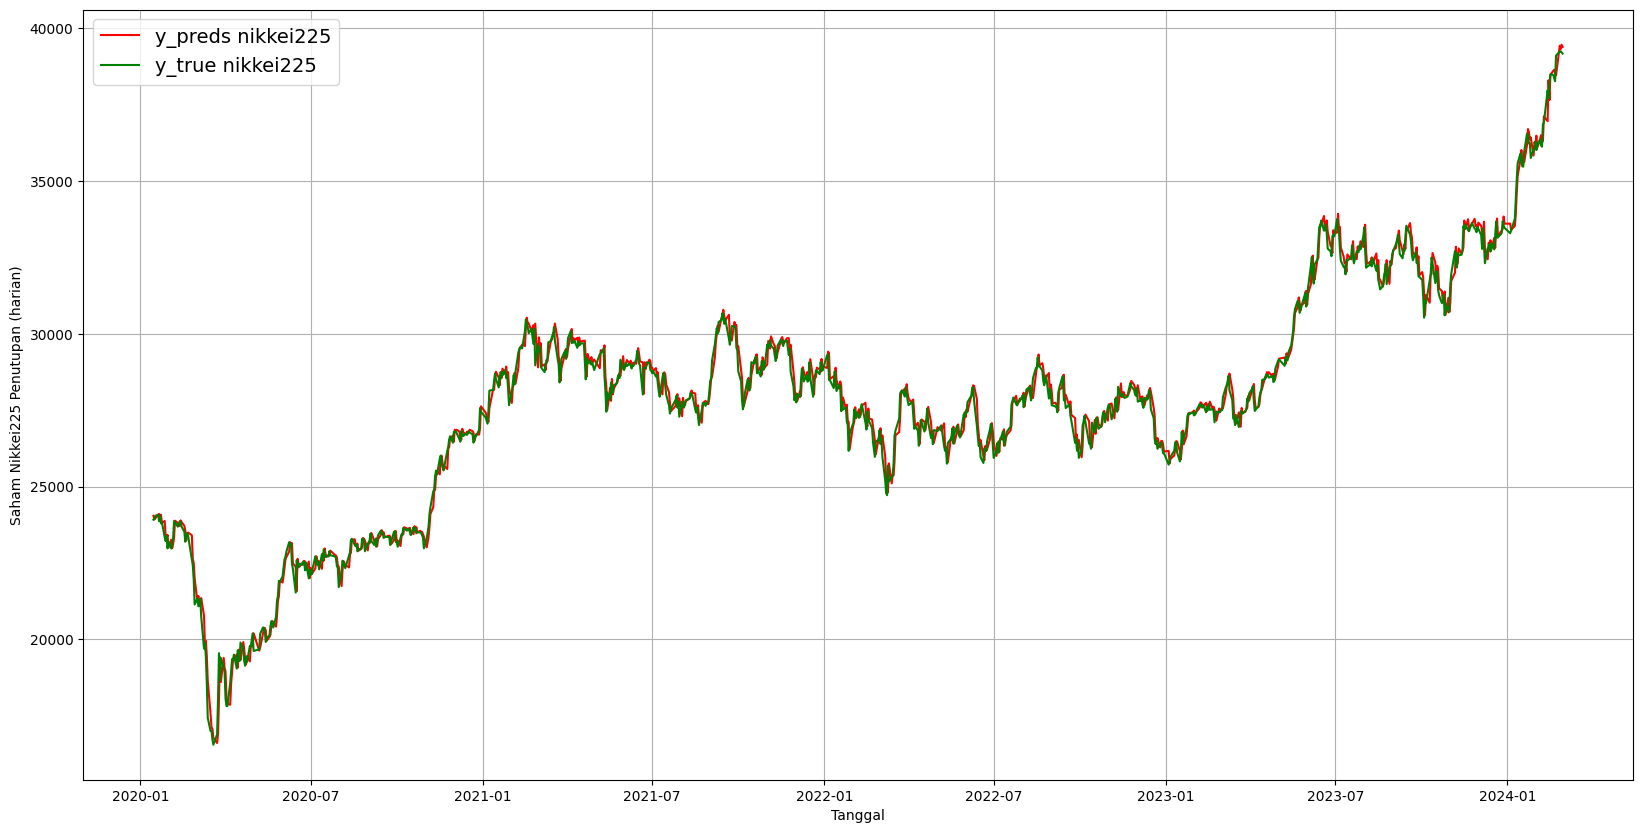

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_2_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_2_plot_prediksi_LSTM_multi_zoomin.png')

simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_2, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_2_LSTM_multivariate.h5")

<ipython-input-124-396348fb223c>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_2, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_2_LSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_2 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_2_LSTM_multivariate.h5")

# Model 3 : Stacked LSTM

In [ ]:
train_windows.shape[2]

2

## Tuner Builder

In [ ]:
# model stacked LSTM dengan hyperparameter tuning

def model_stacked_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_3 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units =  hp.Int('lstm_n_units_1', min_value=32, max_value=256, step=32),
                               input_shape=(train_windows.shape[1], train_windows.shape[2]),
                               return_sequences = True,
                               activation = "relu"),

          #tf.keras.layers.Dropout(0.2, seed=42),
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units_2', min_value=32, max_value=256, step=32),
                               return_sequences = False,
                               activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(test_labels.shape[1])
          ], name = "model_3_stackedLSTM_multivariate")



  #compile model 3
  model_3.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_3

In [ ]:
import keras_tuner as kt

tuner_stackedLSTM_multi = kt.Hyperband(model_stacked_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='stackedLSTM_multivariate')

## Proses tuning


In [ ]:
tuner_stackedLSTM_multi.search(train_windows,
                               train_labels,
                               epochs=10,
                               validation_data=(test_windows, test_labels),
                               batch_size = 128)

Trial 30 Complete [00h 04m 26s]
val_loss: 0.007744140457361937

Best val_loss So Far: 0.006300405599176884
Total elapsed time: 01h 10m 48s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_stackedLSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units_1', "lstm_n_units_2", 'learning_rate']
print('Best tune model stacked LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model stacked LSTM multivariate:
lstm_n_units_1: 64
lstm_n_units_2: 192
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ['lstm_n_units_1', "lstm_n_units_2", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_stackedLSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_Stacked_LSTM_multi.csv')
df_hyparam




lstm_n_units_1  lstm_n_units_2  learning_rate
0               64             192         0.0100
1              256             160         0.0001
2              224              96         0.0001
3              128              64         0.0010
4              128              96         0.0001
5              224             160         0.0001
6              256             160         0.0001
7              224             160         0.0001
8               64              64         0.0010
9              256             160         0.0001
10             128              64         0.0010
11             192              32         0.0100
12             224             160         0.0100
13             224              96         0.0001
14             128             224         0.0010
15             160              32         0.0001
16             192             256         0.0010
17             224             160         0.0001
18              64              64         0.0010
19             128             224         0.0010
20              96             192         0.0100
21              32              64         0.0100
22              96             128         0.0010
23             256             128         0.0010
24              96              64         0.0010
25             160             160         0.0010
26              32             192         0.0100
27             192             192         0.0001
28              64              64         0.0100
29             160             192         0.0100

In [ ]:
tuner_stackedLSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/stackedLSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0027 summary
Hyperparameters:
lstm_n_units_1: 64
lstm_n_units_2: 192
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.006300405599176884

Trial 0016 summary
Hyperparameters:
lstm_n_units_1: 256
lstm_n_units_2: 160
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.007233509328216314

Trial 0025 summary
Hyperparameters:
lstm_n_units_1: 224
lstm_n_units_2: 96
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.0073272245936095715

Trial 0024 summary
Hyperparameters:
lstm_n_units_1: 128
lstm_n_units_2: 64
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_3 = tuner_stackedLSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [100]:
from tensorflow.keras.models import load_model

# Load the saved model
model_3 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_3_stackedLSTM_multivariate.h5")



In [ ]:

# fit
history = model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_3.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0725
Epoch 1: val_loss improved from inf to 0.03132, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_3_stackedLSTM_multivariate
126/126 [==============================] - 35s 252ms/step - loss: 0.0725 - val_loss: 0.0313
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0180
Epoch 2: val_loss improved from 0.03132 to 0.02499, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_3_stackedLSTM_multivariate
126/126 [==============================] - 32s 257ms/step - loss: 0.0180 - val_loss: 0.0250
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0149
Epoch 3: val_loss improved from 0.02499 to 0.01953, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_3_stackedLSTM_multivariate
126/126 [====

visualisasi model shape

In [ ]:
model_3.summary()

Model: "model_3_stackedLSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 28, 64)            17152     
                                                                 
 lstm_3 (LSTM)               (None, 192)               197376    
                                                                 
 dense_1 (Dense)             (None, 2)                 386       
                                                                 
Total params: 214914 (839.51 KB)
Trainable params: 214914 (839.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


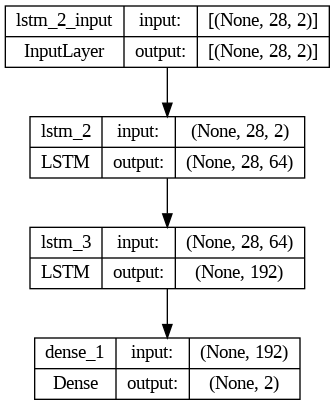

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(model_3, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_stackedLSTM_multi_shape.png', show_shapes=True, show_layer_names=True)



visualisasi loss setiap epoch

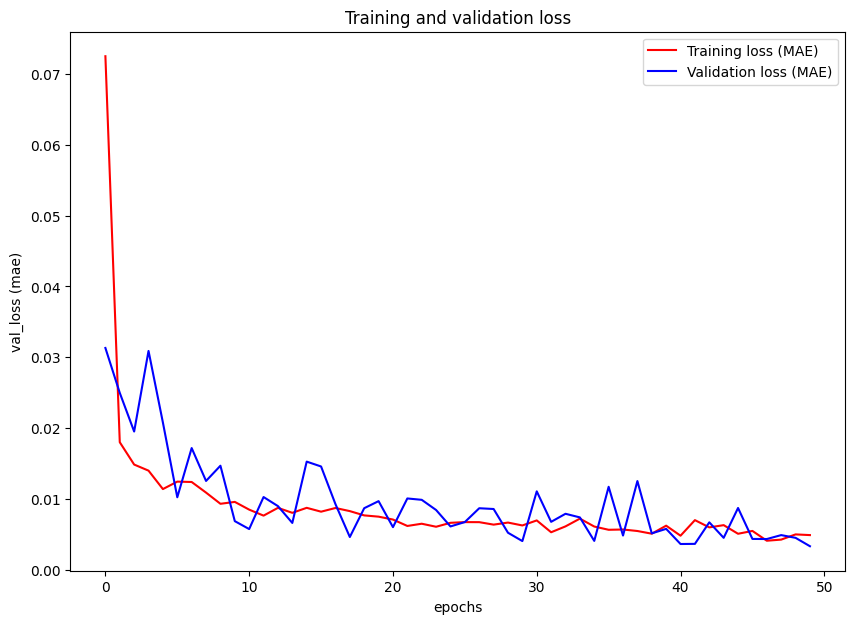

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_stackedLSTM_multi.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_stackedLSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 3 dari epochs terakhir
model_3.evaluate(test_windows, test_labels)

126/126 [==============================] - 6s 46ms/step - loss: 0.0034


0.0033537528943270445

In [ ]:
# mengevaluasi dan load model 3 pada best epoch yang loss mae paling kecil sepanjang training

model_3 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_3_stackedLSTM_multivariate")
model_3.evaluate(test_windows, test_labels)


126/126 [==============================] - 4s 28ms/step - loss: 0.0034


0.0033537528943270445

In [101]:
# membuat predicted value berdasarkan model multivariate model_3 yang sudah di train

model_3_preds = tf.squeeze(model_3.predict(test_windows))
model_3_preds



126/126 [==============================] - 4s 28ms/step


<tf.Tensor: shape=(4010, 2), dtype=float32, numpy=
array([[0.43303403, 0.07247508],
       [0.43485075, 0.07228486],
       [0.43551907, 0.07246564],
       ...,
       [0.9935445 , 0.01492634],
       [0.9996275 , 0.0119471 ],
       [0.9943404 , 0.01395684]], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [102]:
denormalized_model_3_preds = scaler_multivariate.inverse_transform(model_3_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [103]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_3_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_3_preds)

model_3_results

{'mae': 95.70843,
 'mse': 35736.91,
 'rmse': 135.34073,
 'R-square': 0.9808352091610675}

In [ ]:
tf.squeeze(test_labels[:,0])

<tf.Tensor: shape=(4010,), dtype=float64, numpy=
array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])>

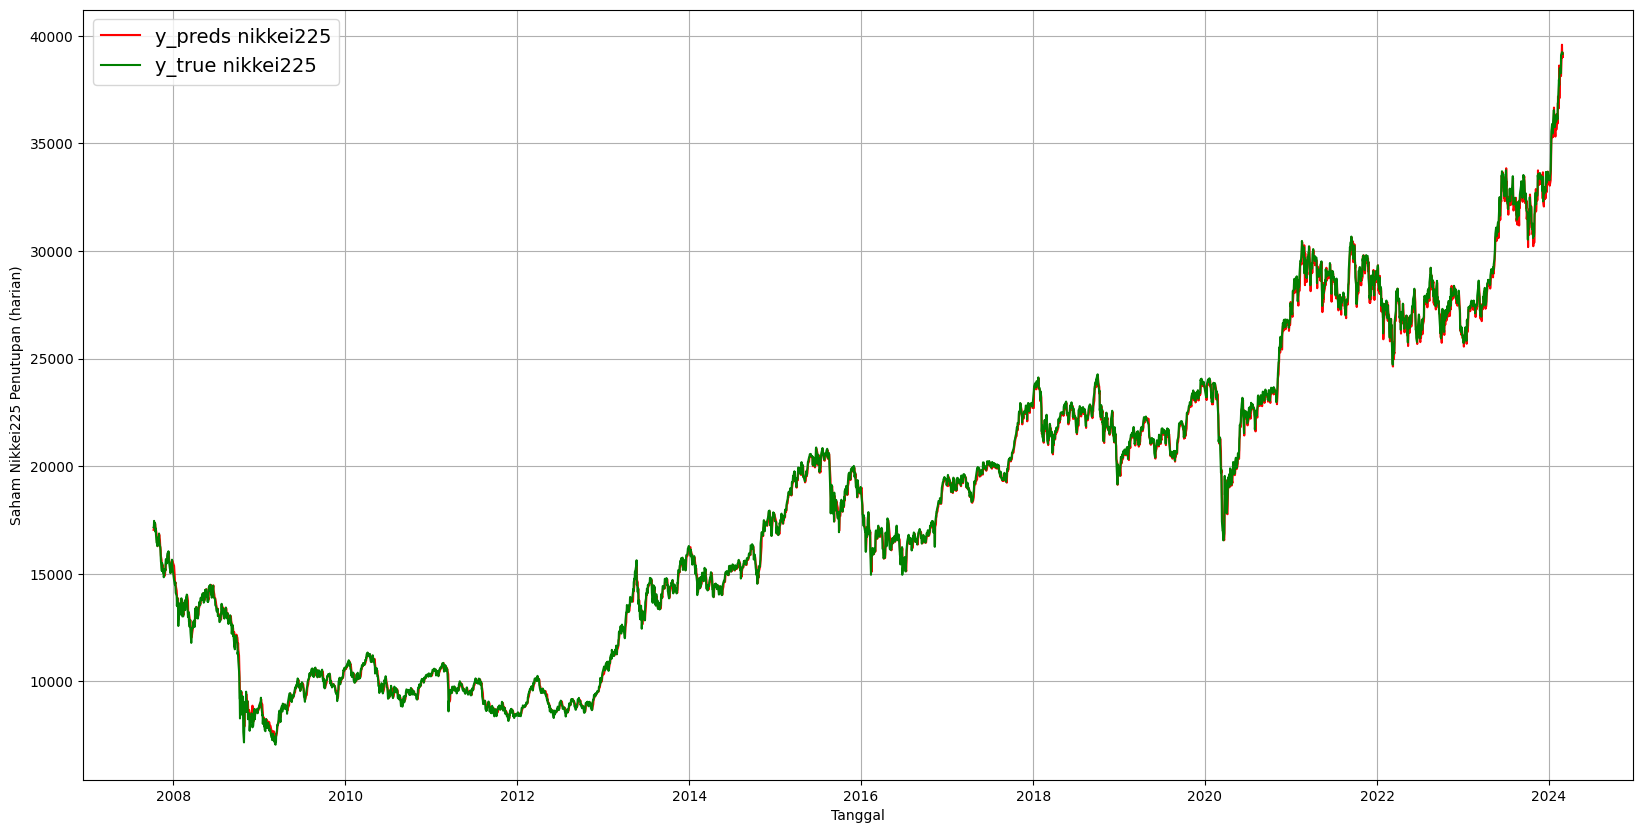

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_3_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_3_plot_prediksi_stackedLSTM_multi.png')



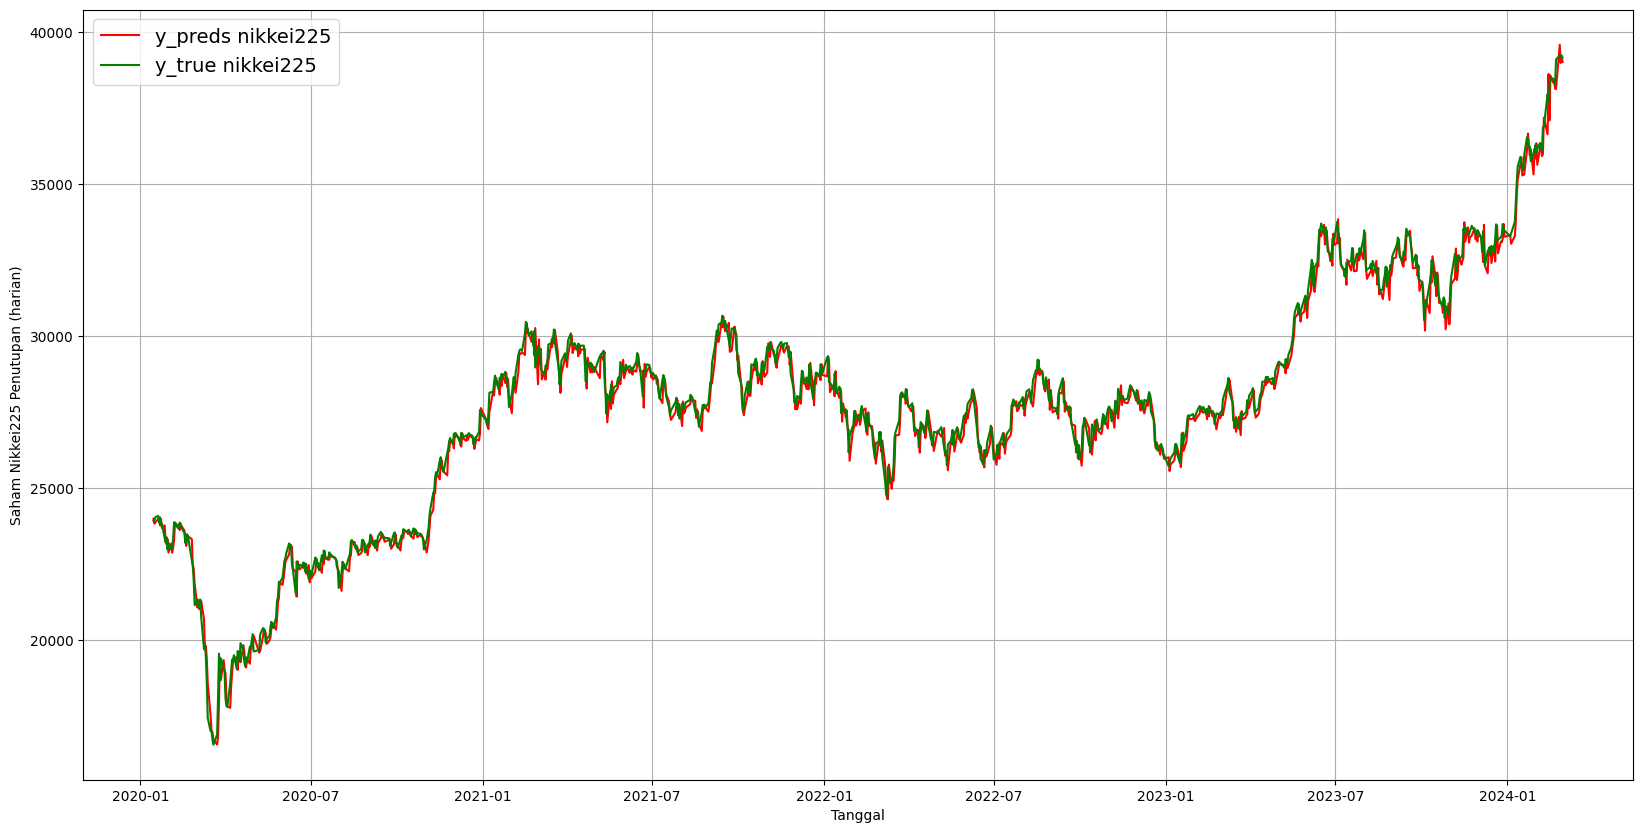

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_3_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_3_plot_prediksi_stackedLSTM_multi_zoomin.png')



simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model


# Save the model to disk as a .h5 file
save_model(model_3, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_3_stackedLSTM_multivariate.h5")

<ipython-input-110-3b1869aa12f9>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_3, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_3_stackedLSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_3 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_3_stackedLSTM_multivariate.h5")



# Model 4 : Bidirectional LSTM

In [ ]:
train_windows.shape[2]

2

## Tuner Builder

In [ ]:
def model_bidirectional_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_4 = tf.keras.models.Sequential([
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hp.Int('bi_lstm_n_units', min_value=32, max_value=256, step=32),
                                                            input_shape=(train_windows.shape[1], train_windows.shape[2]),
                                                            return_sequences = False,
                                                            activation = "relu")),
          #tf.keras.layers.Dropout(0.2, seed=42),
          #tf.keras.layers.LSTM(128, return_sequences = False, activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(test_labels.shape[1])
          ], name = "model_4_bidirectionalLSTM_multivariate")



  #compile model 4
  model_4.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_4

In [ ]:
import keras_tuner as kt

tuner_bi_LSTM_multi = kt.Hyperband(model_bidirectional_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='bi_LSTM_multivariate')

## Proses tuning


In [ ]:
tuner_bi_LSTM_multi.search(train_windows,
                           train_labels,
                           epochs=10,
                           validation_data=(test_windows, test_labels),
                           batch_size = 128)

Trial 30 Complete [00h 06m 27s]
val_loss: 0.005207528825849295

Best val_loss So Far: 0.004855082370340824
Total elapsed time: 01h 04m 21s


## Hasil parameter tuning terbaik

In [ ]:
tuner_bi_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_bi_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ["bi_lstm_n_units", 'learning_rate']
print('Best tune model bidirectional LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model bidirectional LSTM multivariate:
bi_lstm_n_units: 256
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ["bi_lstm_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_bi_LSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_bi_LSTM_multi.csv')

df_hyparam


bi_lstm_n_units  learning_rate
0               256         0.0100
1                64         0.0010
2               192         0.0100
3               224         0.0100
4                32         0.0010
5               256         0.0010
6               224         0.0100
7               160         0.0010
8                32         0.0010
9               256         0.0100
10               96         0.0100
11               32         0.0010
12              160         0.0100
13              256         0.0100
14               96         0.0100
15              224         0.0001
16              192         0.0010
17              192         0.0010
18              128         0.0010
19               96         0.0010
20              128         0.0001
21              256         0.0001
22               32         0.0100
23               64         0.0100
24              192         0.0001
25              160         0.0100
26              128         0.0100
27               64         0.0001
28               96         0.0001
29               32         0.0001

In [ ]:
tuner_bi_LSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/bi_LSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
bi_lstm_n_units: 256
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.004855082370340824

Trial 0028 summary
Hyperparameters:
bi_lstm_n_units: 64
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.004900765605270863

Trial 0029 summary
Hyperparameters:
bi_lstm_n_units: 192
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005207528825849295

Trial 0024 summary
Hyperparameters:
bi_lstm_n_units: 224
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.00542326970025897

Trial 0016 summary
Hyperparameters:
bi_lstm_n

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_4 = tuner_bi_LSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [104]:
from tensorflow.keras.models import load_model

# Load the saved model
model_4 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")

In [ ]:

# fit
history = model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_4.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0867
Epoch 1: val_loss improved from inf to 0.01751, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_4_bidirectionalLSTM_multivariate
126/126 [==============================] - 69s 520ms/step - loss: 0.0867 - val_loss: 0.0175
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0123
Epoch 2: val_loss improved from 0.01751 to 0.01369, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_4_bidirectionalLSTM_multivariate
126/126 [==============================] - 61s 485ms/step - loss: 0.0123 - val_loss: 0.0137
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0108
Epoch 3: val_loss improved from 0.01369 to 0.01069, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_4_bidirectionalLSTM_multivar

visualisasi model shape

In [ ]:
model_4.summary()

Model: "model_4_bidirectionalLSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 512)               530432    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 531458 (2.03 MB)
Trainable params: 531458 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


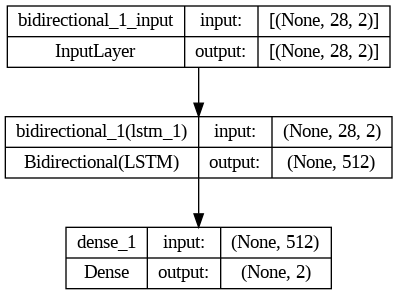

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(model_4, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_biLSTM_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

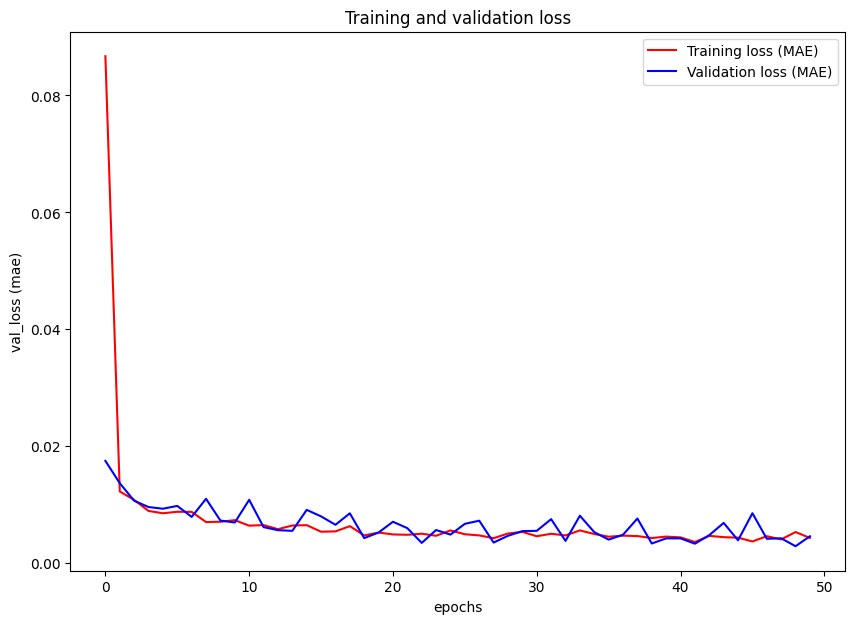

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_bidirectional_LSTM_multi.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_bidirectional_LSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 4 dari epochs terakhir
model_4.evaluate(test_windows, test_labels)

126/126 [==============================] - 8s 60ms/step - loss: 0.0046


0.004615056328475475

In [ ]:
# mengevaluasi dan load model 4 pada best epoch yang loss mae paling kecil sepanjang training

model_4 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_4_bidirectionalLSTM_multivariate")
model_4.evaluate(test_windows, test_labels)


126/126 [==============================] - 9s 68ms/step - loss: 0.0029


0.0029116785153746605

In [105]:
# membuat predicted value berdasarkan model multivariate model_4 yang sudah di train

model_4_preds = tf.squeeze(model_4.predict(test_windows))
model_4_preds



126/126 [==============================] - 8s 53ms/step


<tf.Tensor: shape=(4010, 2), dtype=float32, numpy=
array([[0.4348351 , 0.07196793],
       [0.4372086 , 0.07202314],
       [0.43773744, 0.07198255],
       ...,
       [1.0065356 , 0.02024195],
       [1.0088423 , 0.02023944],
       [1.0071152 , 0.01996133]], dtype=float32)>

In [106]:
model_4_preds[:,0]

<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.4348351 , 0.4372086 , 0.43773744, ..., 1.0065356 , 1.0088423 ,
       1.0071152 ], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [107]:
denormalized_model_4_preds = scaler_multivariate.inverse_transform(model_4_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [108]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_4_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_4_preds)

model_4_results

{'mae': 96.24257,
 'mse': 36183.016,
 'rmse': 136.10184,
 'R-square': 0.9935425098785201}

In [ ]:
tf.squeeze(test_labels[:,0])

<tf.Tensor: shape=(4010,), dtype=float64, numpy=
array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])>

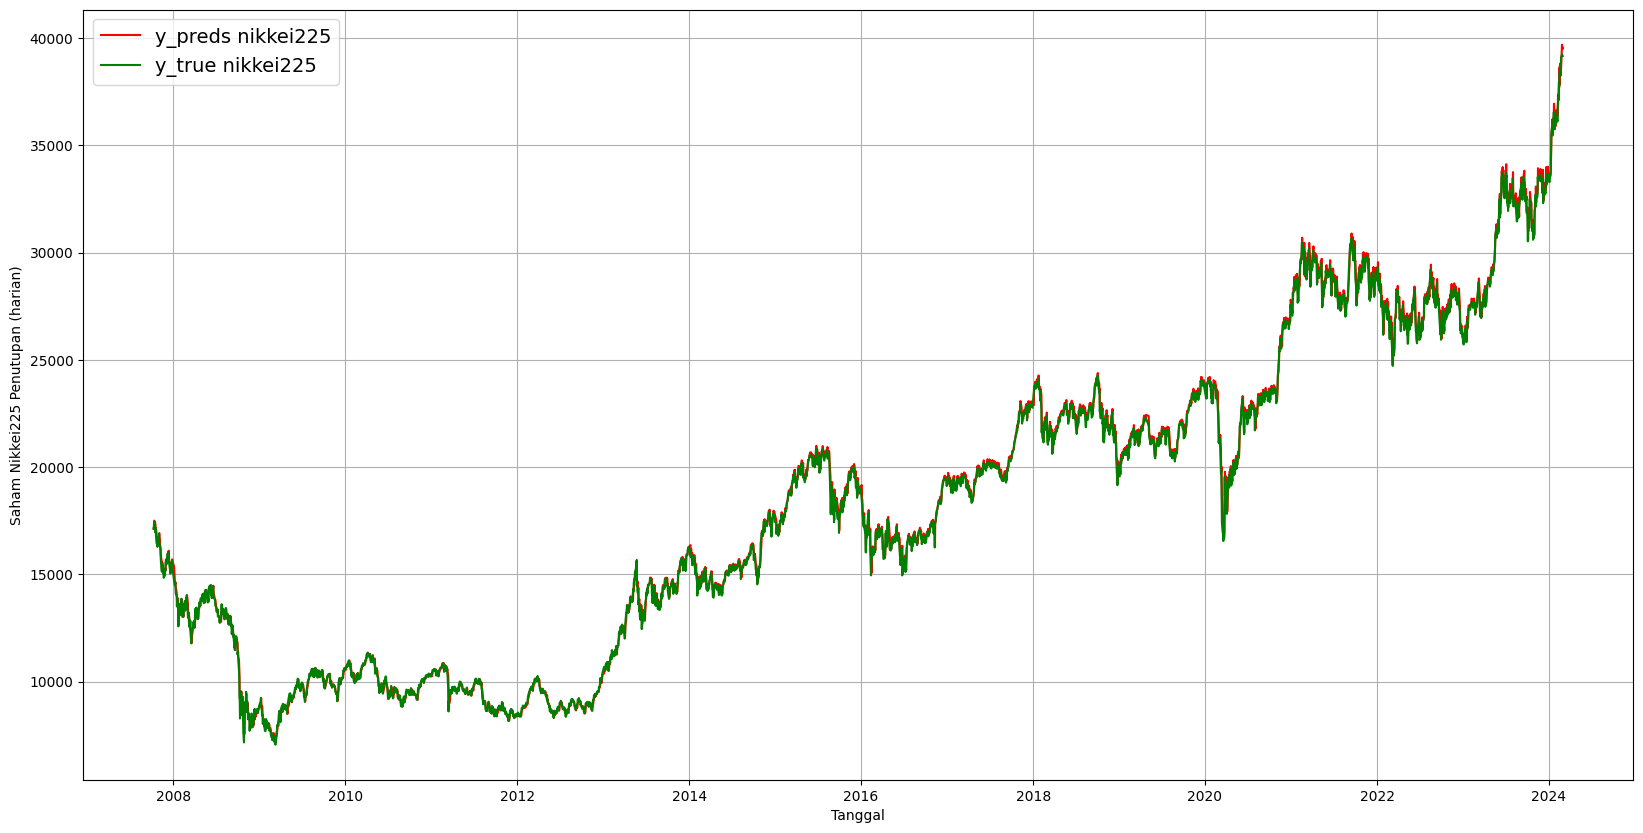

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_4_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_4_plot_prediksi_biLSTM_multi.png')


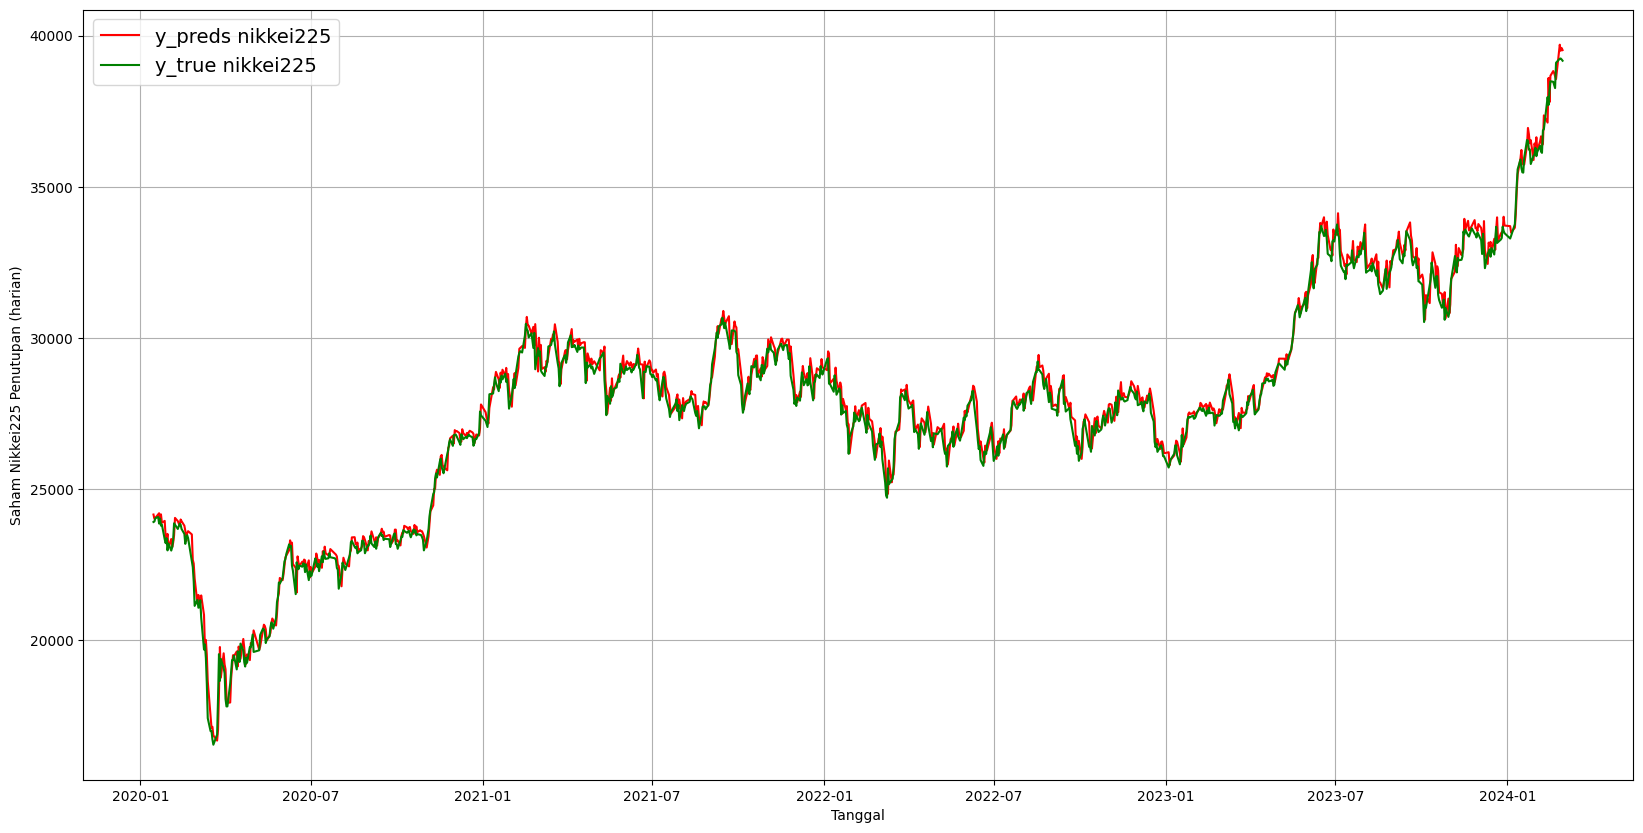

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_4_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_4_plot_prediksi_biLSTM_multi_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model


# Save the model to disk as a .h5 file
save_model(model_4, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")

<ipython-input-133-524b20dff0e2>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_4, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_4 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")

# Model 5 : CNN-LSTM

## Tuner Builder

In [ ]:
def model_CNN_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_5 = tf.keras.models.Sequential([
    # YOUR CODE HERE.
    tf.keras.layers.Conv1D(filters=hp.Int('Conv1D_n_filters', min_value=32, max_value=256, step=32),
                          kernel_size=hp.Int('Conv1D_kernel_size', min_value=5, max_value=10, step=1),
                          strides=1,
                          padding="causal",
                          activation="relu",
                          input_shape=[train_windows.shape[1], train_windows.shape[2]]),

    tf.keras.layers.LSTM(units = hp.Int('LSTM_n_units', min_value=32, max_value=256, step=32),
                        return_sequences=False),

    tf.keras.layers.Dense(test_labels.shape[1]),
    ], name = "model_5_CNN-LSTM_multivariate")


  #compile model 5
  model_5.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_5

In [ ]:
import keras_tuner as kt

tuner_CNN_LSTM_multi = kt.Hyperband(model_CNN_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='CNN_LSTM_multivariate')

## Proses tuning


In [ ]:
tuner_CNN_LSTM_multi.search(train_windows,
                            train_labels,
                            epochs=10,
                            validation_data=(test_windows, test_labels),
                            batch_size = 128)

Trial 30 Complete [00h 04m 28s]
val_loss: 0.007836872711777687

Best val_loss So Far: 0.005176719278097153
Total elapsed time: 00h 57m 55s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_CNN_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['Conv1D_n_filters', 'Conv1D_kernel_size', "LSTM_n_units", 'learning_rate']
print('Best tune model CNN LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model CNN LSTM multivariate:
Conv1D_n_filters: 128
Conv1D_kernel_size: 6
LSTM_n_units: 128
learning_rate: 0.001


## Hasil semua parameter tuning

In [ ]:
tuning = ['Conv1D_n_filters', 'Conv1D_kernel_size', "LSTM_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_CNN_LSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_CNN_LSTM_multi.csv')
df_hyparam


Conv1D_n_filters  Conv1D_kernel_size  LSTM_n_units  learning_rate
0                128                   6           128         0.0010
1                 32                   9           224         0.0010
2                192                   9            64         0.0001
3                256                   7           256         0.0010
4                128                   7           224         0.0001
5                128                   7           224         0.0001
6                 64                   9           160         0.0001
7                128                   6           128         0.0010
8                128                   7           224         0.0001
9                224                   7           224         0.0010
10                32                   9           224         0.0010
11                64                   9           160         0.0001
12               224                   5           224         0.0010
13               192                   8           192         0.0010
14               192                   6            64         0.0010
15               224                   9           192         0.0010
16               224                  10           160         0.0100
17                64                  10           224         0.0100
18               128                   6           128         0.0010
19               224                   7           224         0.0010
20               160                  10            64         0.0010
21                32                   8           256         0.0001
22               224                   6           160         0.0010
23               224                   5           224         0.0010
24                32                   6            64         0.0100
25               128                  10           160         0.0100
26                96                   8           256         0.0100
27                32                   7            32         0.0001
28               224                  10            96         0.0100
29               192                   6           256         0.0100

In [ ]:
tuner_CNN_LSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/CNN_LSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
Conv1D_n_filters: 128
Conv1D_kernel_size: 6
LSTM_n_units: 128
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.005176719278097153

Trial 0024 summary
Hyperparameters:
Conv1D_n_filters: 32
Conv1D_kernel_size: 9
LSTM_n_units: 224
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.005466407164931297

Trial 0027 summary
Hyperparameters:
Conv1D_n_filters: 192
Conv1D_kernel_size: 9
LSTM_n_units: 64
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005746571347117424

Trial 0028 summary
Hyperparameters:
Conv1D_n_filters: 256
Conv1D_kernel_size: 7
LSTM_n_units: 25

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_5 = tuner_CNN_LSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [109]:
from tensorflow.keras.models import load_model

# Load the saved model
model_5 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


In [ ]:

# fit
history = model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0322
Epoch 1: val_loss improved from inf to 0.00804, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_5_CNN-LSTM_multivariate
126/126 [==============================] - 26s 183ms/step - loss: 0.0322 - val_loss: 0.0080
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0102
Epoch 2: val_loss did not improve from 0.00804
126/126 [==============================] - 17s 136ms/step - loss: 0.0102 - val_loss: 0.0118
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0096
Epoch 3: val_loss did not improve from 0.00804
126/126 [==============================] - 17s 136ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 4/50
126/126 [==============================] - ETA: 0s - loss: 0.0092
Epoch 4: val_loss improved from 0.00804 to 0.00773, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/

visualisasi model shape

In [ ]:
model_5.summary()

Model: "model_5_CNN-LSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 128)           1664      
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 133506 (521.51 KB)
Trainable params: 133506 (521.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


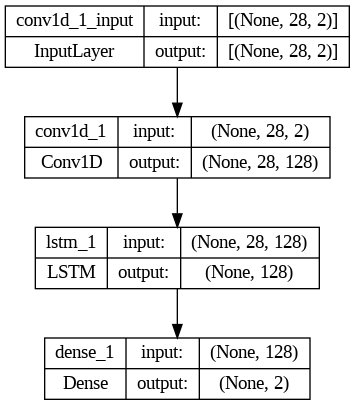

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_5, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_CNN-LSTM_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

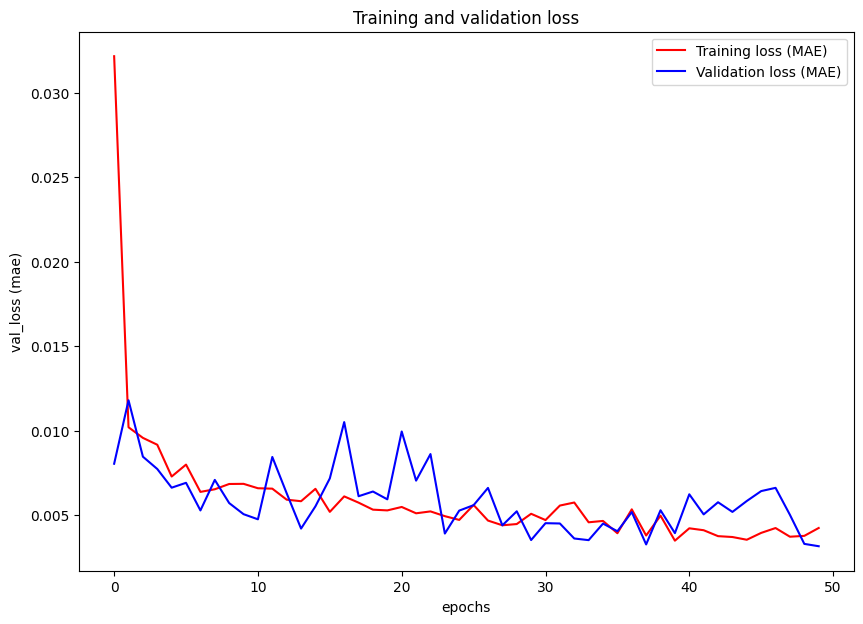

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_CNN-LSTM_multi.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_CNN-LSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 5 dari epochs terakhir
model_5.evaluate(test_windows, test_labels)

126/126 [==============================] - 3s 20ms/step - loss: 0.0032


0.0031634110491722822

In [ ]:
# mengevaluasi dan load model 5 pada best epoch yang loss mae paling kecil sepanjang training

model_5 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_5_CNN-LSTM_multivariate")
model_5.evaluate(test_windows, test_labels)


126/126 [==============================] - 4s 21ms/step - loss: 0.0032


0.0031634110491722822

In [110]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_5_preds = tf.squeeze(model_5.predict(test_windows))
model_5_preds



126/126 [==============================] - 3s 17ms/step


<tf.Tensor: shape=(4010, 2), dtype=float32, numpy=
array([[0.4302371 , 0.0723568 ],
       [0.43261394, 0.07233762],
       [0.43271992, 0.07210486],
       ...,
       [0.9971149 , 0.02397645],
       [1.0002677 , 0.02456292],
       [1.0002707 , 0.02421063]], dtype=float32)>

In [111]:
model_5_preds[:,0]

<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.4302371 , 0.43261394, 0.43271992, ..., 0.9971149 , 1.0002677 ,
       1.0002707 ], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [112]:
denormalized_model_5_preds = scaler_multivariate.inverse_transform(model_5_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [113]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_5_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_5_preds)

model_5_results

{'mae': 102.923,
 'mse': 37044.184,
 'rmse': 145.54836,
 'R-square': 0.9920044757683997}

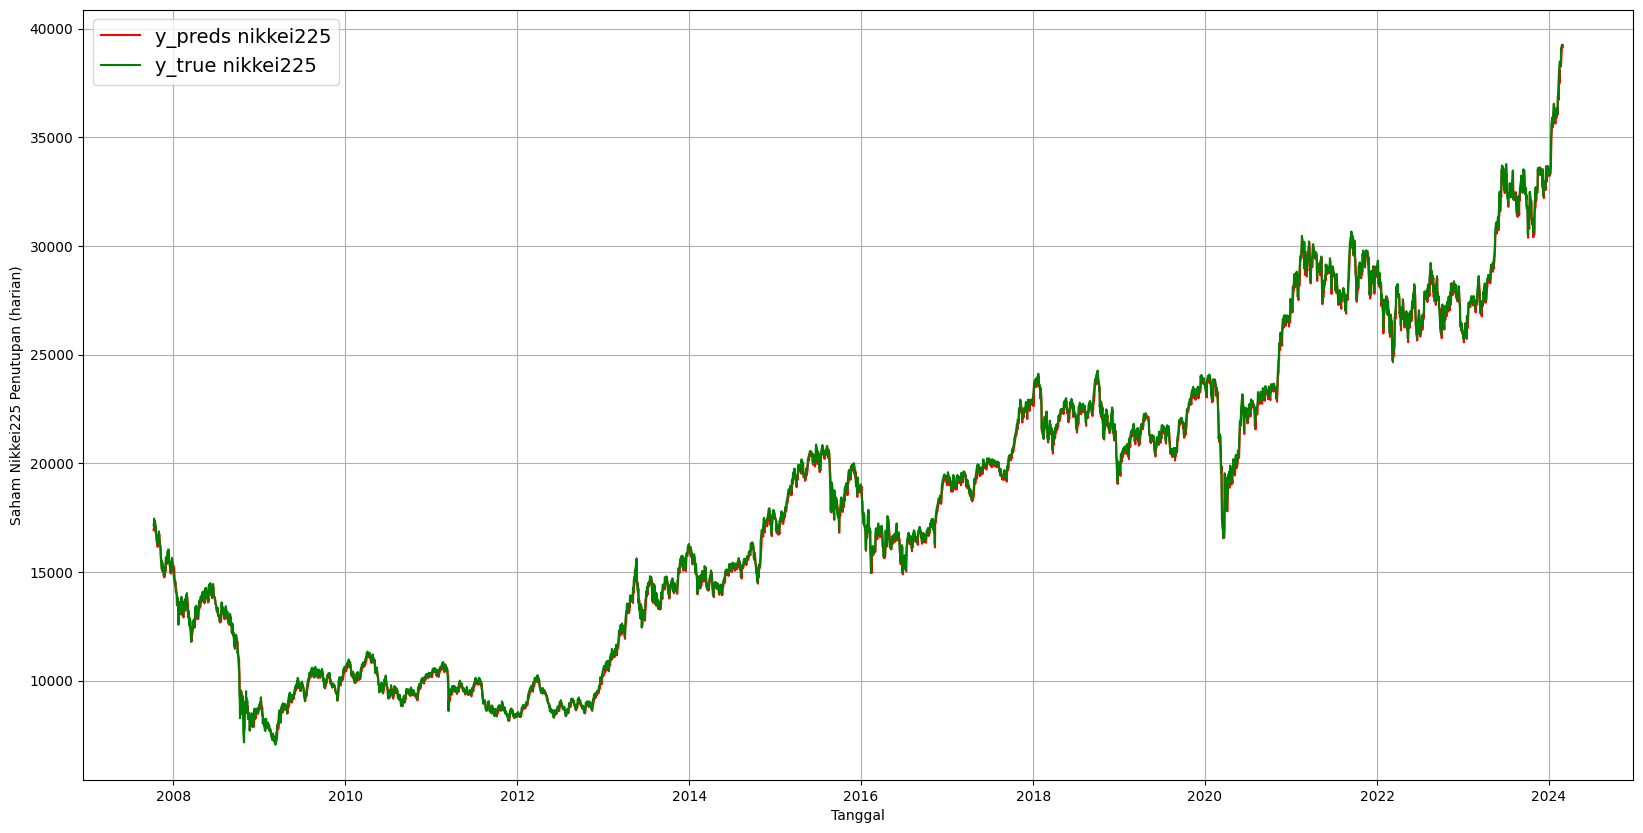

In [114]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_5_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_5_plot_prediksi_CNN-LSTM_multi.png')


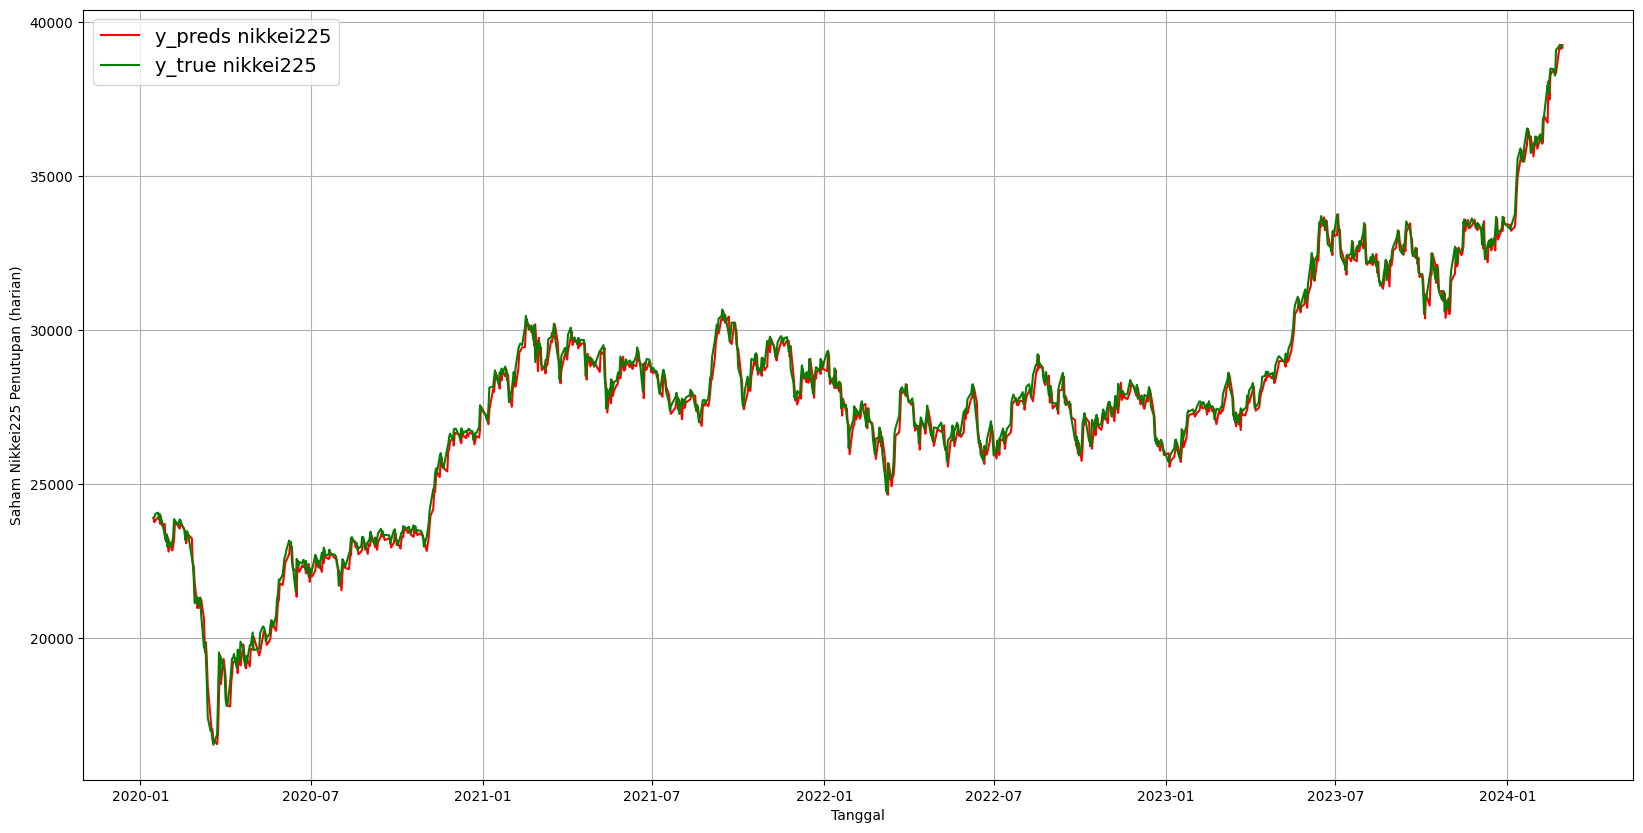

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_5_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_5_plot_prediksi_CNN-LSTM_multi_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_5, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


<ipython-input-153-276fb7eb5ea3>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_5, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_5 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


# Membuat univariate time series forecasting stock price

In [83]:
print(full_windows[:, 0]),
print(full_windows[:, 0].shape)
print("\n")
print(full_labels[:, 0])
print(full_labels[:, 0].shape)

[[5.95337367e-04 5.62921348e-01]
 [5.18206571e-04 5.62921348e-01]
 [4.44140575e-04 5.62921348e-01]
 ...
 [9.07536522e-01 2.24719101e-02]
 [9.03924400e-01 2.24719101e-02]
 [9.03628646e-01 2.24719101e-02]]
(20050, 2)


[4.20388377e-04 5.05947372e-04 5.61879969e-04 ... 1.00000000e+00
 9.99195745e-01 9.98127152e-01]
(20050,)


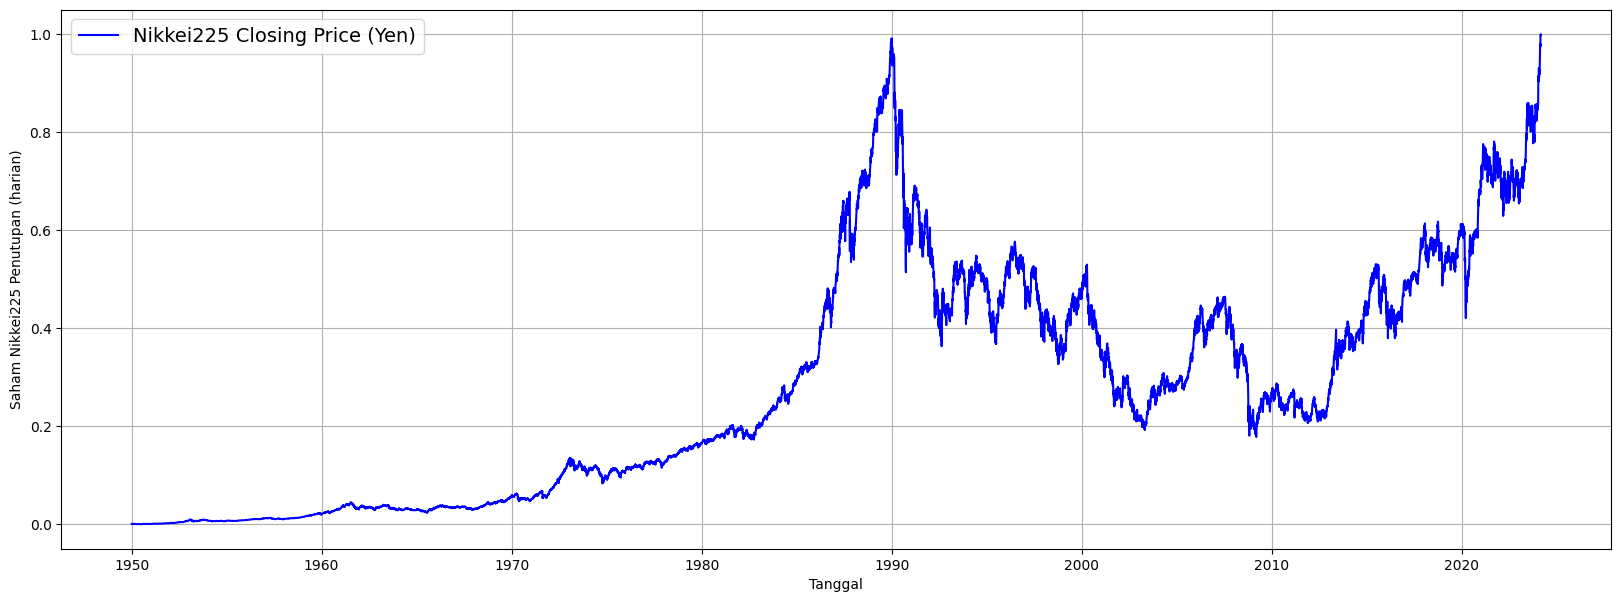

In [84]:
plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = normalized_data[:,0], format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')

memanggil variabel window dan label untuk univariate nikkei stock price

In [85]:
X_nikkei.shape, y_nikkei.shape

((20050, 28, 1), (20050, 1, 1))

reshape dimensi X_nikkei dan y_nikkei dan masukkan ke variabel baru

In [86]:
train_nikkeiWindows = np.squeeze(X_nikkei[:len(X_nikkei[: int(SPLIT_SIZE * len(X_nikkei))])])
test_nikkeiWindows = np.squeeze(X_nikkei[len(X_nikkei[: int(SPLIT_SIZE * len(X_nikkei))]):])

train_nikkeiLabels = np.squeeze(y_nikkei[:len(y_nikkei[: int(SPLIT_SIZE * len(y_nikkei))])])
test_nikkeiLabels = np.squeeze(y_nikkei[len(y_nikkei[: int(SPLIT_SIZE * len(y_nikkei))]):])

In [87]:
train_nikkeiWindows.shape, test_nikkeiWindows.shape

((16040, 28), (4010, 28))

In [88]:
train_nikkeiWindows.shape[1]

28

In [89]:
train_nikkeiLabels.shape, test_nikkeiLabels.shape

((16040,), (4010,))

# Model 6: Conv1D Univariate

In [ ]:
train_nikkeiWindows.shape

(16040, 28)

## Tuner Builder

In [ ]:
#create Conv1D model
def model_Conv1D_uni_builder(hp):
  tf.random.set_seed(42)

  model_6 = tf.keras.models.Sequential([
      #layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
      tf.keras.layers.Conv1D(filters = hp.Int('conv1D_n_filters', min_value=32, max_value=256, step=32),
                             kernel_size = hp.Int('conv1D_kernel_size', min_value=5, max_value=10, step=1),
                             strides = 1,
                             padding ="causal",
                             input_shape = (WINDOW_SIZE, 1)),
      tf.keras.layers.GlobalMaxPooling1D(),  # Add GlobalMaxPooling1D layer
      tf.keras.layers.Dense(1)

      #filters adalah jumlah hidden unit dalam layers tersebut
      # kernel size adalah ukuran dari window. Ex: kernel_size = 7 artinya melihat 7 value sekaligus
      # default nilai strides = 1, ini sudah sesuai karena sliding window bergeser satu timesteps
  ], name = "model_6_conv1D_univariate")

  #compile model 1
  model_6.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_6

In [ ]:
import keras_tuner as kt

tuner_Conv1D_uni = kt.Hyperband(model_Conv1D_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='Conv1D_univariate')



## Proses tuning


In [ ]:
tuner_Conv1D_uni.search(train_nikkeiWindows,
                        train_nikkeiLabels,
                        epochs=10,
                        validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                        batch_size=128)

Trial 30 Complete [00h 00m 17s]
val_loss: 0.013308187015354633

Best val_loss So Far: 0.012014263309538364
Total elapsed time: 00h 05m 49s


## Hasil parameter tuning terbaik

In [ ]:
tuner_Conv1D_uni.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_Conv1D_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
print('Best tune model Conv1D univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model Conv1D univariate:
conv1D_n_filters: 224
conv1D_kernel_size: 9
learning_rate: 0.001


## Hasil semua parameter tuning

In [ ]:
tuning =['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all = tuner_Conv1D_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_Con1D_uni.csv')
df_hyparam



conv1D_n_filters  conv1D_kernel_size  learning_rate
0                224                   9         0.0010
1                192                   6         0.0010
2                192                   8         0.0010
3                256                  10         0.0100
4                192                   9         0.0100
5                224                   9         0.0010
6                192                   6         0.0010
7                128                   9         0.0100
8                 96                   7         0.0100
9                256                  10         0.0100
10               128                   9         0.0100
11               256                   5         0.0100
12                96                   5         0.0001
13               224                   6         0.0100
14                64                   6         0.0100
15                96                   5         0.0001
16               128                   9         0.0100
17               128                   9         0.0001
18               224                   9         0.0010
19               256                   5         0.0100
20                64                   8         0.0010
21               256                   6         0.0010
22                96                   7         0.0010
23                64                   5         0.0001
24               128                   6         0.0001
25               256                   9         0.0100
26                32                   6         0.0100
27               192                   5         0.0100
28                64                   7         0.0001
29                96                   9         0.0100

In [ ]:
tuner_Conv1D_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/Conv1D_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
conv1D_n_filters: 224
conv1D_kernel_size: 9
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.012014263309538364

Trial 0024 summary
Hyperparameters:
conv1D_n_filters: 192
conv1D_kernel_size: 6
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.012436358258128166

Trial 0029 summary
Hyperparameters:
conv1D_n_filters: 192
conv1D_kernel_size: 8
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.013308187015354633

Trial 0025 summary
Hyperparameters:
conv1D_n_filters: 256
conv1D_kernel_size: 10
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracke

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_6 = tuner_Conv1D_uni.hypermodel.build(best_hps)

## Melatih model

In [115]:
from tensorflow.keras.models import load_model

# Load the saved model
model_6 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_6_Conv1D_univariate.h5")


In [ ]:

# fit
history = model_6.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_6.name)])

Epoch 1/50
122/126 [============================>.] - ETA: 0s - loss: 0.0202
Epoch 1: val_loss improved from inf to 0.01982, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_6_conv1D_univariate
126/126 [==============================] - 3s 20ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0080
Epoch 2: val_loss improved from 0.01982 to 0.01762, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_6_conv1D_univariate
126/126 [==============================] - 2s 15ms/step - loss: 0.0080 - val_loss: 0.0176
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0074
Epoch 3: val_loss improved from 0.01762 to 0.01520, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_6_conv1D_univariate
126/126 [=============================

visualisasi model shape

In [ ]:
model_6.summary()

Model: "model_6_conv1D_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 224)           2240      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 224)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 225       
                                                                 
Total params: 2465 (9.63 KB)
Trainable params: 2465 (9.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


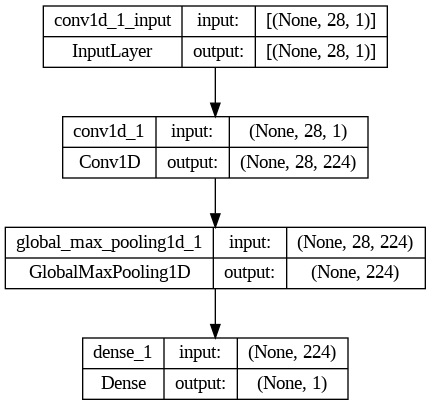

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_6, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_Conv1D_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

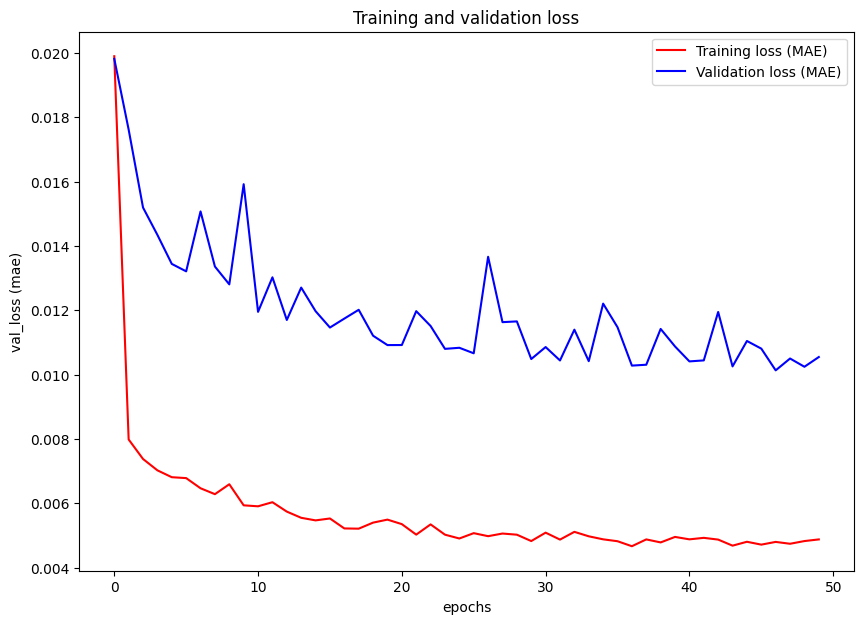

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_Conv1D_uni.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_Conv1D_uni.csv', index=False)


In [ ]:
# mengevaluasi model 6 dari epochs terakhir
model_6.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 1s 5ms/step - loss: 0.0105


0.010546479374170303

In [ ]:
# mengevaluasi dan load model 6 pada best epoch yang loss mae paling kecil sepanjang training

model_6 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_6_conv1D_univariate")
model_6.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 1s 3ms/step - loss: 0.0101


0.010131807997822762

In [118]:
# membuat predicted value berdasarkan model multivariate model_6 yang sudah di train

model_6_preds = tf.squeeze(model_6.predict(test_nikkeiWindows))
model_6_preds



126/126 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.42230996, 0.42398608, 0.42555013, ..., 0.98314613, 0.98538214,
       0.98773664], dtype=float32)>

In [119]:
model_6_preds.shape

TensorShape([4010])

## Denormalisasi nilai output prediksi dan test_labels

In [120]:
denormalized_model_6_preds = scaler_univariate.inverse_transform([model_6_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [121]:
denormalized_model_6_preds = tf.squeeze(denormalized_model_6_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [122]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_6_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_6_preds)

model_6_results

{'mae': 396.70355,
 'mse': 303122.1,
 'rmse': 550.56525,
 'R-square': 0.9942354679916269}

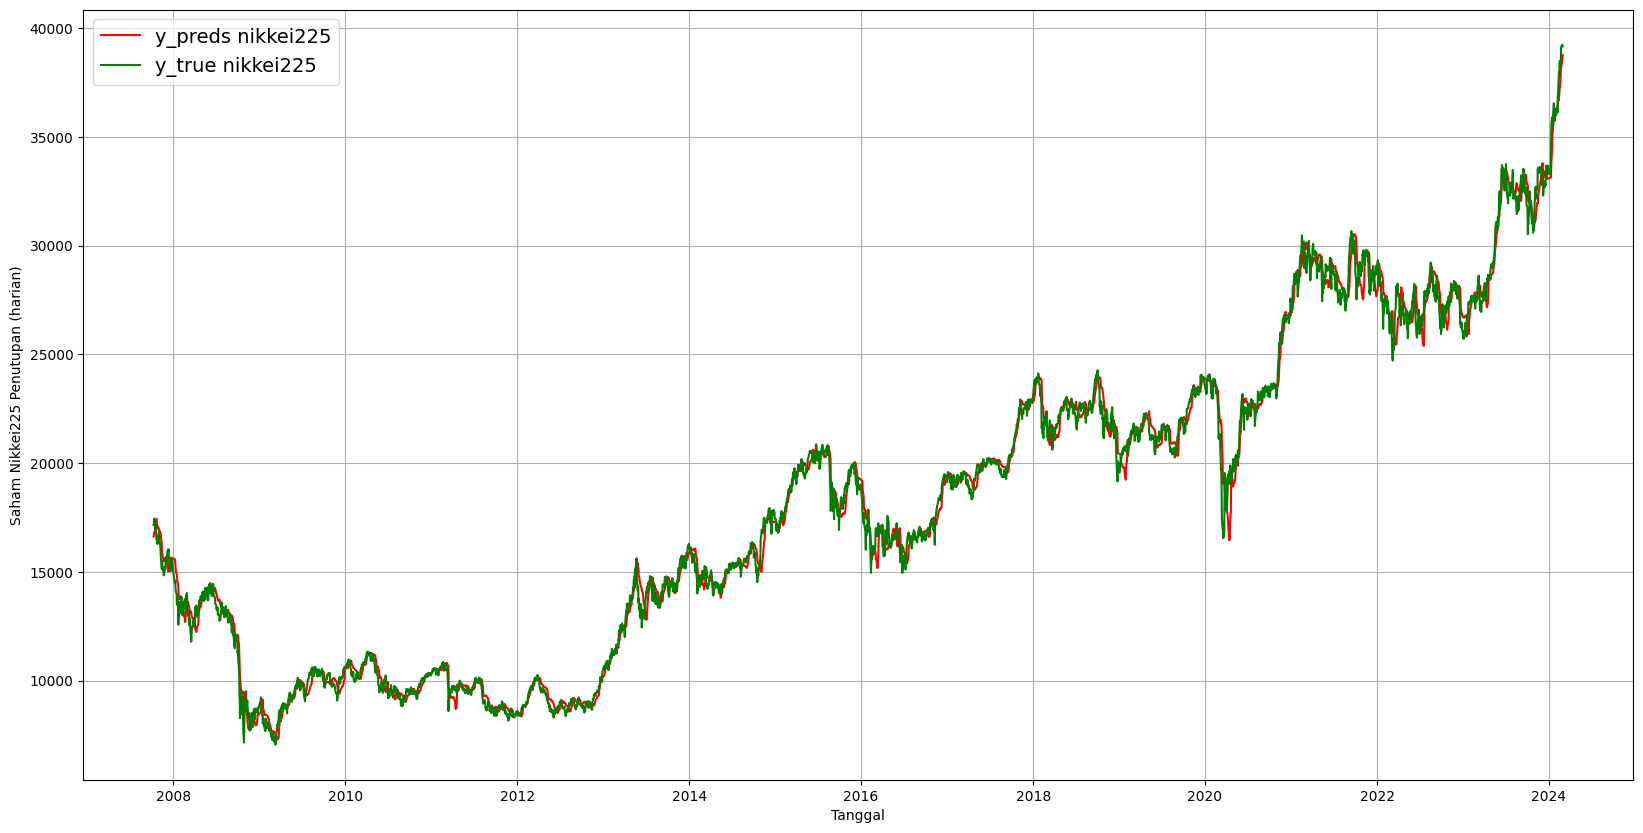

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_6_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_6_plot_prediksi_Conv1D_uni.png')


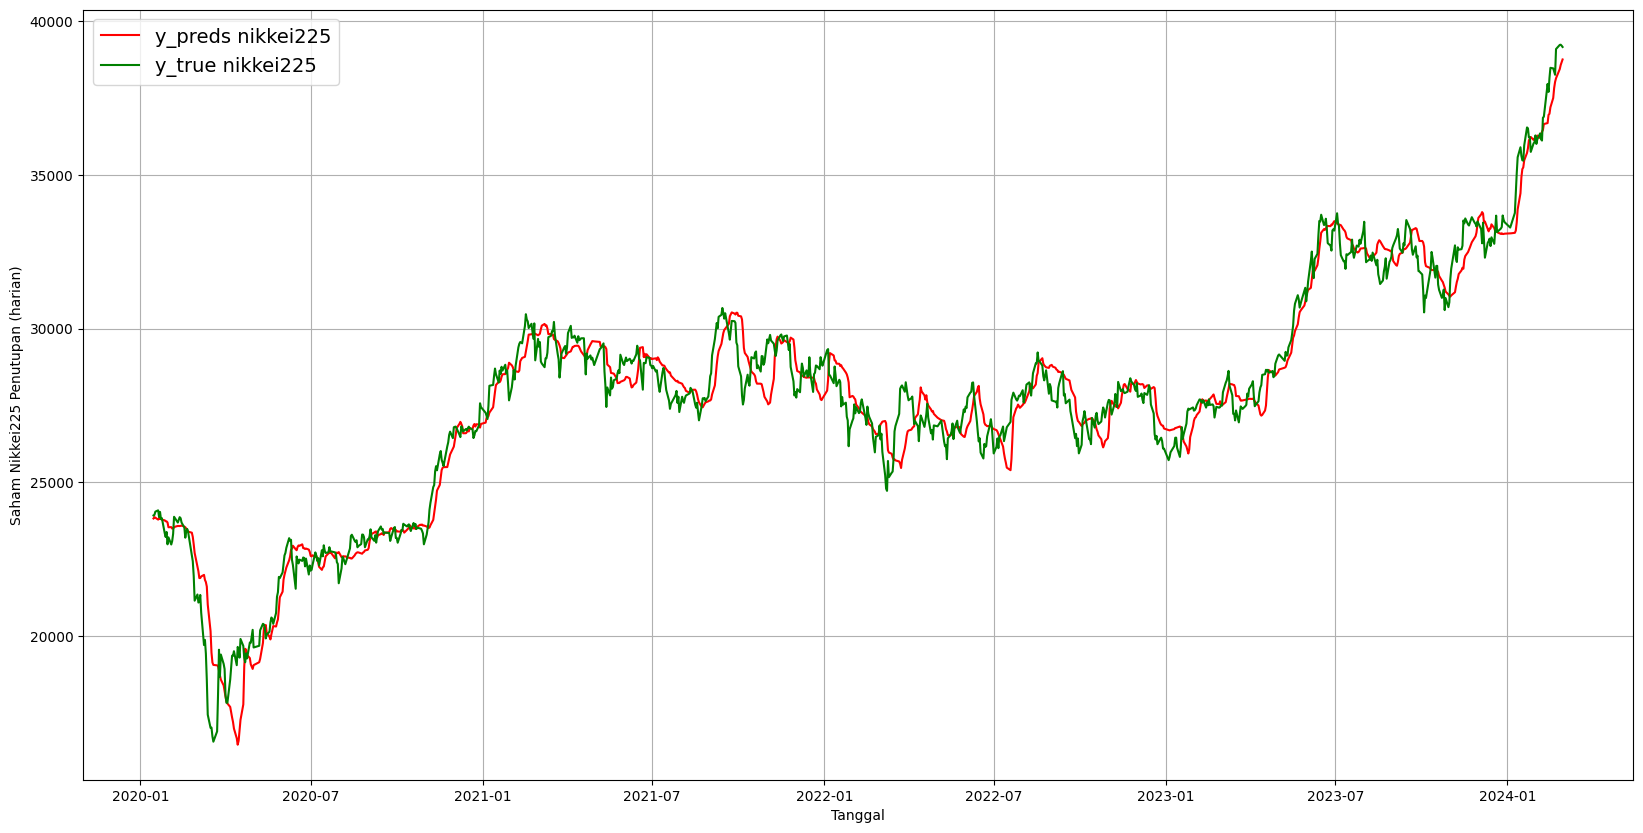

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_6_preds, format = "-", start = 3000,label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", start = 3000,label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_6_plot_prediksi_Conv1D_uni_zoomin.png')


In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_6, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_6_Conv1D_univariate.h5")


<ipython-input-183-b510bb8cf093>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_6, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_6_Conv1D_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_6 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_6_Conv1D_univariate.h5")


# Model 7: LSTM Univariate

## Tuner Builder

In [125]:
# membuat model LSTM dengan hyperparameter tuning

def model_LSTM_uni_builder(hp):
  tf.random.set_seed(42)

  model_7 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units', min_value=32, max_value=256, step=32),
                               input_shape=(WINDOW_SIZE, 1),
                               return_sequences = False,
                               activation = "relu"),
          #tf.keras.layers.Dropout(0.2),
          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(1, activation = "relu")
          ], name = "model_7_LSTM_univariate")



  #compile model 2
  model_7.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_7

In [126]:
import keras_tuner as kt

tuner_LSTM_uni = kt.Hyperband(model_LSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='LSTM_univariate')

Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/LSTM_univariate/tuner0.json


## Proses tuning


In [127]:
tuner_LSTM_uni.search(train_nikkeiWindows,
                      train_nikkeiLabels,
                      epochs=10,
                      validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                      batch_size = 128)

## Hasil parameter tuning terbaik

In [128]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_LSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units', 'learning_rate']
print('Best tune model LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model LSTM univariate:
lstm_n_units: 256
learning_rate: 0.01


## Hasil parameter semua tuning

In [129]:
tuning =['lstm_n_units', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all =tuner_LSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all :
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_LSTM_uni.csv')
df_hyparam


lstm_n_units  learning_rate
0            256         0.0100
1            256         0.0010
2            192         0.0010
3            160         0.0100
4            160         0.0010
5            160         0.0100
6             32         0.0010
7            160         0.0010
8             32         0.0010
9            128         0.0010
10           256         0.0010
11           160         0.0010
12            64         0.0100
13            32         0.0010
14           256         0.0001
15           128         0.0010
16           128         0.0001
17            64         0.0010
18            32         0.0001
19            32         0.0001
20           224         0.0010
21           192         0.0100
22            32         0.0100
23            96         0.0001
24           224         0.0001
25            96         0.0010
26            64         0.0001
27           128         0.0100
28           224         0.0100
29            96         0.0100

In [130]:
tuner_LSTM_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/LSTM_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0029 summary
Hyperparameters:
lstm_n_units: 256
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0054317074827849865

Trial 0025 summary
Hyperparameters:
lstm_n_units: 256
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.006645581219345331

Trial 0026 summary
Hyperparameters:
lstm_n_units: 192
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.006678490899503231

Trial 0024 summary
Hyperparameters:
lstm_n_units: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.006707801949232817

Trial 0016 summary
Hyperparameters:
lstm_n_units: 160
lear

## Mengimplementasikan hyperparameter terbaik ke model

In [135]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_7 = tuner_LSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [123]:
from tensorflow.keras.models import load_model

# Load the saved model
model_7 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_7_LSTM_univariate.h5")


In [136]:

# fit
history = model_7.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_7.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.2201
Epoch 1: val_loss improved from inf to 0.03451, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_7_LSTM_univariate
126/126 [==============================] - 30s 227ms/step - loss: 0.2201 - val_loss: 0.0345
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0092
Epoch 2: val_loss improved from 0.03451 to 0.01149, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_7_LSTM_univariate
126/126 [==============================] - 29s 229ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0073
Epoch 3: val_loss did not improve from 0.01149
126/126 [==============================] - 27s 218ms/step - loss: 0.0073 - val_loss: 0.0205
Epoch 4/50
126/126 [==============================] - ETA: 0s - loss: 0.0067
Epoch 4

visualisasi model shape

In [137]:
model_7.summary()

Model: "model_7_LSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               264192    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


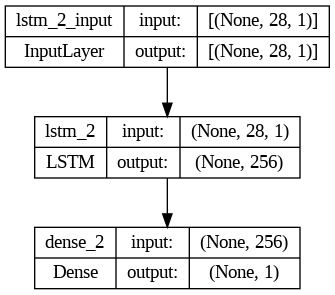

In [138]:
from tensorflow.keras.utils import plot_model

plot_model(model_7, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_LSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

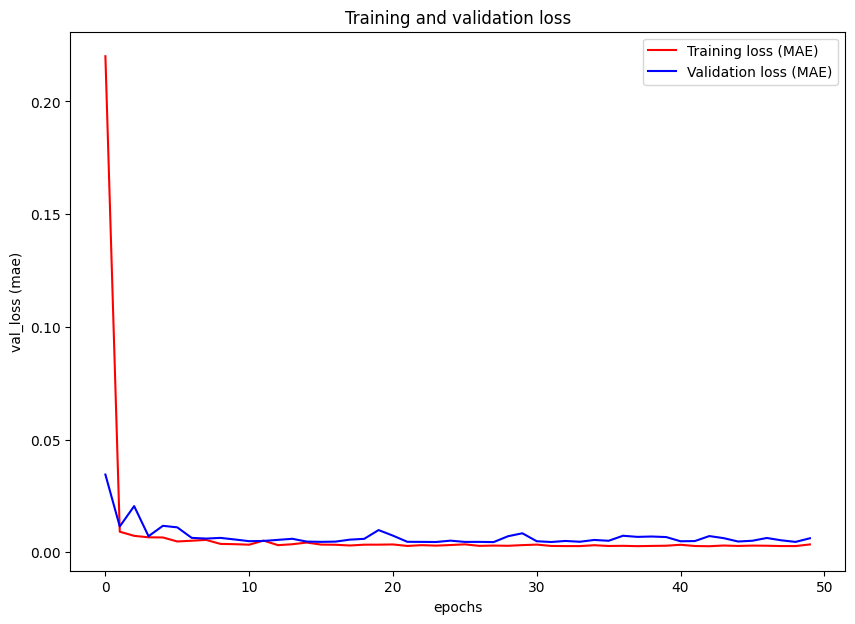

In [139]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_LSTM_uni.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_LSTM_uni.csv', index=False)


In [140]:
# mengevaluasi model 7 dari epochs terakhir
model_7.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 5s 37ms/step - loss: 0.0063


0.006252660416066647

In [141]:
# mengevaluasi dan load model 7 pada best epoch yang loss mae paling kecil sepanjang training

model_7 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_7_LSTM_univariate")
model_7.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 3s 25ms/step - loss: 0.0045


0.004549740813672543

In [142]:
# membuat predicted value berdasarkan model multivariate model_7 yang sudah di train

model_7_preds = tf.squeeze(model_7.predict(test_nikkeiWindows))
model_7_preds



126/126 [==============================] - 3s 25ms/step


<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.43438172, 0.43693382, 0.43716642, ..., 0.996994  , 1.0009825 ,
       0.99924076], dtype=float32)>

In [143]:
model_7_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.43438172, 0.43693382], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [144]:
denormalized_model_7_preds = scaler_univariate.inverse_transform([model_7_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [145]:
denormalized_model_7_preds = tf.squeeze(denormalized_model_7_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [146]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_7_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_7_preds)

model_7_results

{'mae': 178.14177,
 'mse': 63116.348,
 'rmse': 251.22968,
 'R-square': 0.9987997040090755}

In [147]:
tf.squeeze(test_nikkeiLabels[:])

<tf.Tensor: shape=(4010,), dtype=float64, numpy=
array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])>

In [148]:
test_nikkeiLabels[:]

array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])

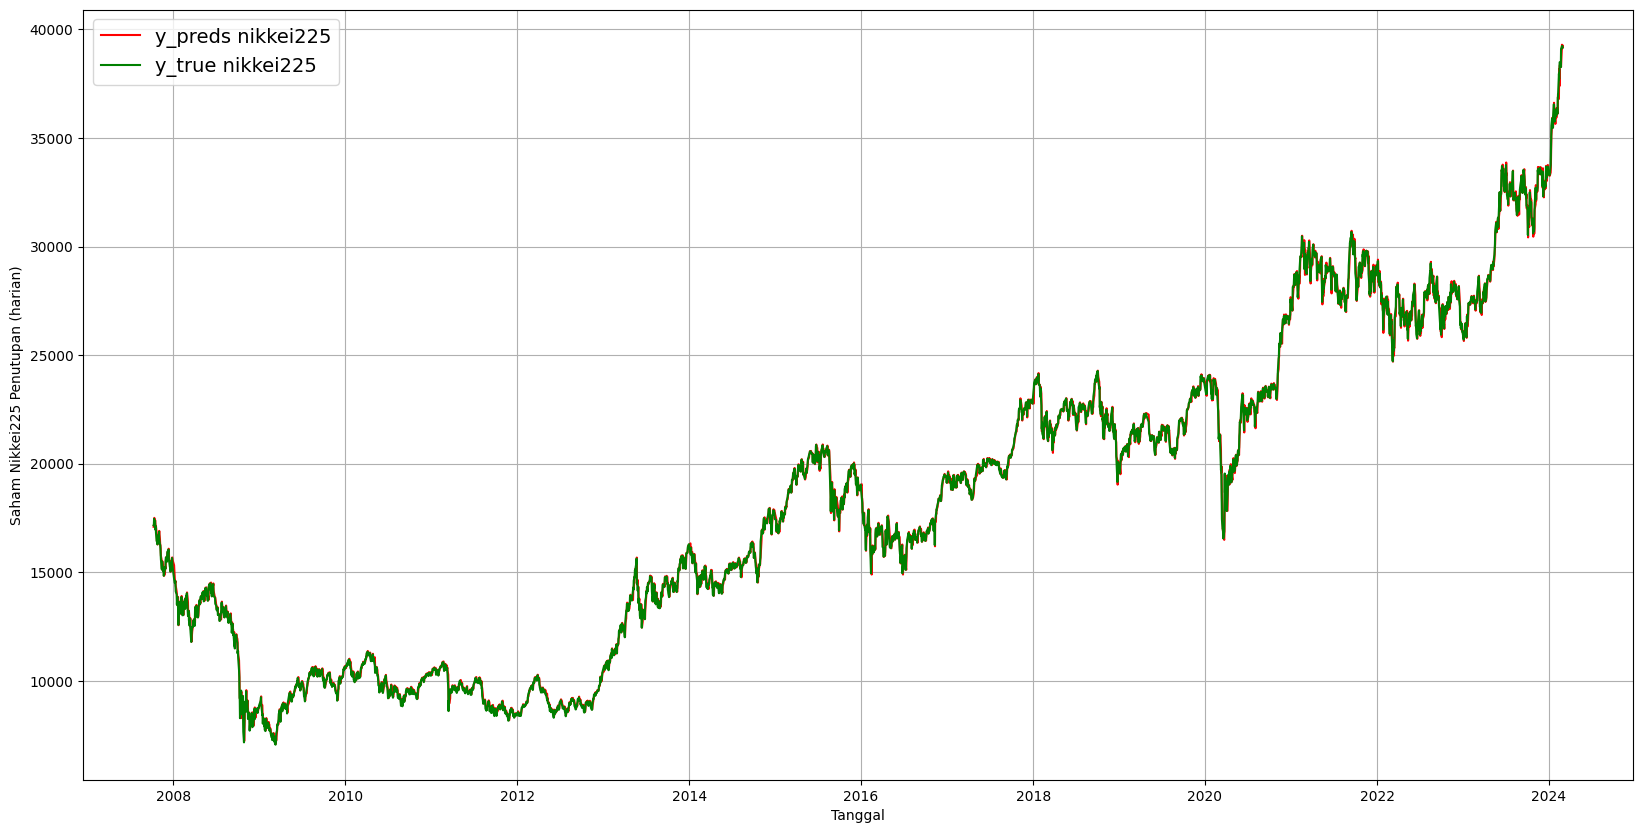

In [149]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_7_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_7_plot_prediksi_LSTM_uni.png')


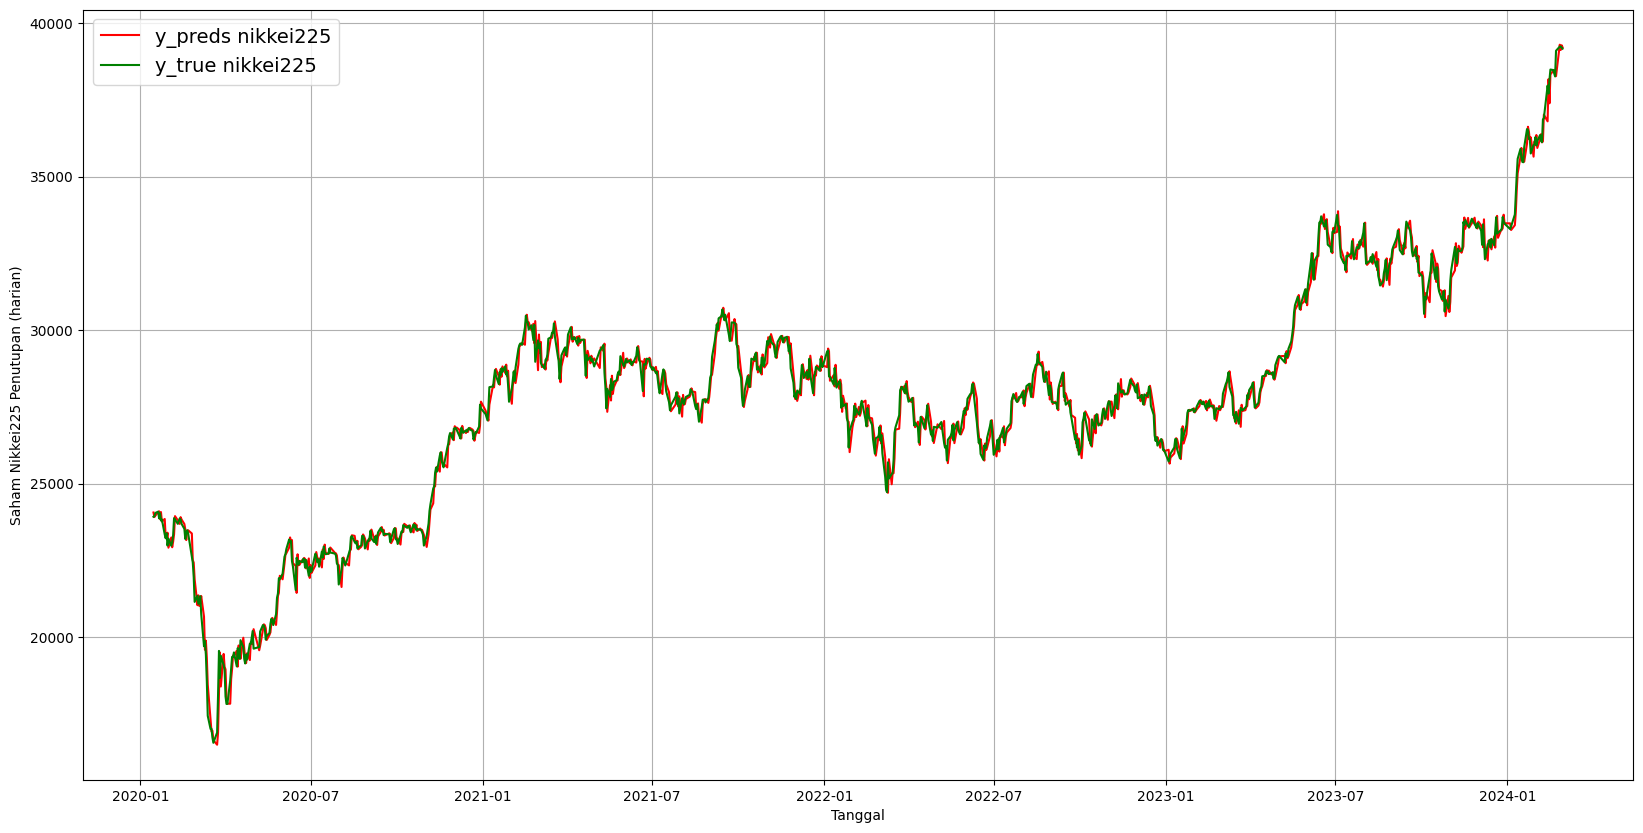

In [150]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_7_preds, format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_7_plot_prediksi_LSTM_uni_zoomin.png')


simpan model trained ke bentuk h5.

In [151]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_7, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_7_LSTM_univariate.h5")


<ipython-input-151-15a505699bb8>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_7, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_7_LSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_7 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_7_LSTM_univariate.h5")


 # Model 8 : Stacked LSTM univariate

## Tuner builder

In [152]:
# membuat model LSTM dengan hyperparameter tuning
def model_stackedLSTM_uni_builder(hp):

  tf.random.set_seed(42)
  model_8 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units =  hp.Int('lstm_n_units', min_value=32, max_value=256, step=32),
                              input_shape=(WINDOW_SIZE, 1),
                              return_sequences = True,
                              activation = "relu"),

          #tf.keras.layers.Dropout(0.2, seed=42),
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units_2', min_value=32, max_value=256, step=32),
                              return_sequences = False,
                              activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(1)
          ], name = "model_8_stackedLSTM_univariate")


  #compile model 8
  model_8.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_8

In [ ]:
import keras_tuner as kt

tuner_stackedLSTM_uni = kt.Hyperband(model_stackedLSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='stackedLSTM_univariate')

## Proses tuning


In [209]:
tuner_stackedLSTM_uni.search(train_nikkeiWindows,
                             train_nikkeiLabels,
                             epochs=10,
                             validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                             batch_size = 128)

Trial 30 Complete [00h 08m 44s]
val_loss: 0.005292142275720835

Best val_loss So Far: 0.005292142275720835
Total elapsed time: 01h 01m 41s


## Hasil parameter tuning terbaik

In [210]:
# mengeluarkan hyperparameter optimal
best_hps = tuner_stackedLSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units', "lstm_n_units_2", 'learning_rate']
print('Best tune model stacked LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model stacked LSTM univariate:
lstm_n_units: 160
lstm_n_units_2: 256
learning_rate: 0.01


## Hasil semua parameter tuning

In [211]:
tuning = ['lstm_n_units', "lstm_n_units_2", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all = tuner_stackedLSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_Stacked_LSTM_uni.csv')
df_hyparam


lstm_n_units  lstm_n_units_2  learning_rate
0            160             256         0.0100
1             64              96         0.0100
2            224             160         0.0100
3            192              96         0.0100
4             64             128         0.0100
5             64              96         0.0100
6             64             160         0.0010
7             64             128         0.0100
8             64             160         0.0010
9            192              32         0.0001
10            64             128         0.0100
11            96              32         0.0001
12            96             128         0.0010
13           128             192         0.0001
14            64              96         0.0100
15           192              32         0.0001
16           192             224         0.0001
17           256              64         0.0001
18           128              64         0.0001
19            96             128         0.0010
20            32             160         0.0001
21           128             192         0.0001
22           160             160         0.0010
23           128             160         0.0001
24           192              96         0.0001
25            96             256         0.0001
26            96             224         0.0100
27           224              64         0.0001
28           224              64         0.0100
29            32             128         0.0100

In [212]:
tuner_stackedLSTM_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/stackedLSTM_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0029 summary
Hyperparameters:
lstm_n_units: 160
lstm_n_units_2: 256
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005292142275720835

Trial 0016 summary
Hyperparameters:
lstm_n_units: 64
lstm_n_units_2: 96
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.005880875047296286

Trial 0027 summary
Hyperparameters:
lstm_n_units: 224
lstm_n_units_2: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.007155346218496561

Trial 0028 summary
Hyperparameters:
lstm_n_units: 192
lstm_n_units_2: 96
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.007501902990043163

## Mengimplementasikan hyperparameter terbaik ke model

In [213]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_8 = tuner_stackedLSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [153]:
from tensorflow.keras.models import load_model

# Load the saved model
model_8 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_8_stackedLSTM_univariate.h5")


In [215]:

# fit
history = model_8.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_8.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0564
Epoch 1: val_loss improved from inf to 0.01340, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_8_stackedLSTM_univariate
126/126 [==============================] - 62s 460ms/step - loss: 0.0564 - val_loss: 0.0134
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0093
Epoch 2: val_loss did not improve from 0.01340
126/126 [==============================] - 55s 435ms/step - loss: 0.0093 - val_loss: 0.0183
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0084
Epoch 3: val_loss improved from 0.01340 to 0.00879, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_8_stackedLSTM_univariate
126/126 [==============================] - 58s 463ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 4/50
126/126 [==============================] - ETA: 0s - loss: 

visualisasi model shape

In [216]:
model_8.summary()

Model: "model_8_stackedLSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 28, 160)           103680    
                                                                 
 lstm_3 (LSTM)               (None, 256)               427008    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 530945 (2.03 MB)
Trainable params: 530945 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


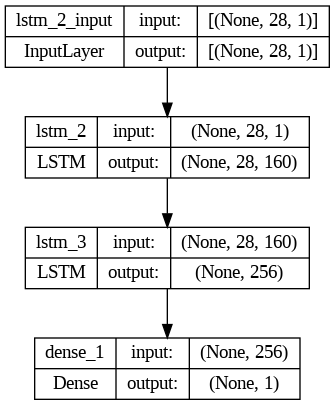

In [217]:
from tensorflow.keras.utils import plot_model

plot_model(model_8, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_stackedLSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

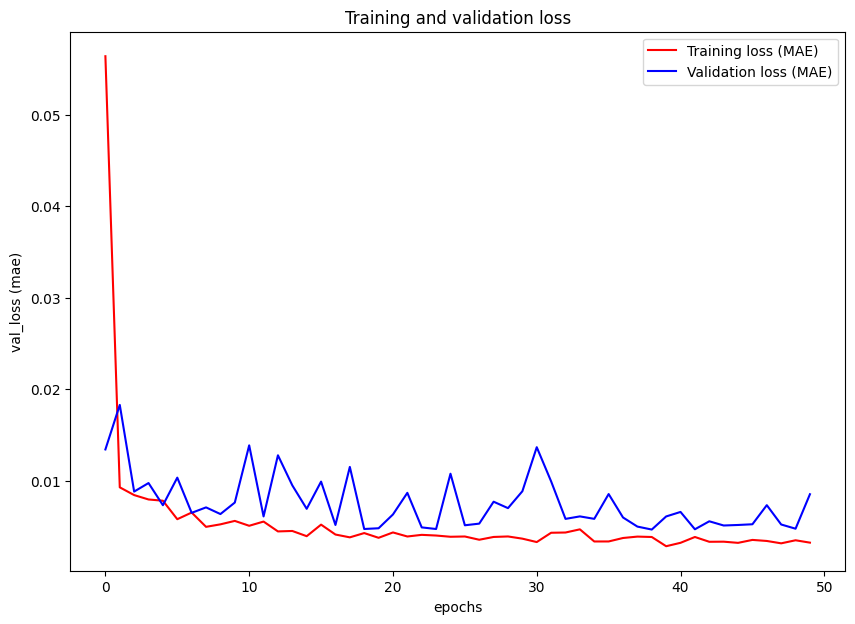

In [218]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_stackedLSTM_uni.png')

# Create a DataFrame from loss and val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan visualisasi loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_stackedLSTM_uni.csv', index=False)


In [219]:
# mengevaluasi model 8 dari epochs terakhir
model_8.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 6s 46ms/step - loss: 0.0085


0.008500822819769382

In [220]:
# mengevaluasi dan load model 8 pada best epoch yang loss mae paling kecil sepanjang training

model_8 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_8_stackedLSTM_univariate")
model_8.evaluate(test_nikkeiWindows, test_nikkeiLabels)



126/126 [==============================] - 6s 44ms/step - loss: 0.0046


0.00463832775130868

In [154]:
# membuat predicted value berdasarkan model multivariate model_8 yang sudah di train

model_8_preds = tf.squeeze(model_8.predict(test_nikkeiWindows))
model_8_preds



126/126 [==============================] - 7s 57ms/step


<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.43493074, 0.43744835, 0.4377436 , ..., 0.9943206 , 1.0028284 ,
       0.99817735], dtype=float32)>

In [155]:
model_8_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.43493074, 0.43744835], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [156]:
denormalized_model_8_preds = scaler_univariate.inverse_transform([model_8_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [157]:
denormalized_model_8_preds = tf.squeeze(denormalized_model_8_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [158]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_8_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_8_preds)

model_8_results

{'mae': 181.61037,
 'mse': 65984.29,
 'rmse': 256.87408,
 'R-square': 0.9987451638974972}

In [226]:
tf.squeeze(test_nikkeiLabels)

<tf.Tensor: shape=(4010,), dtype=float64, numpy=
array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])>

In [227]:
test_nikkeiLabels[:]

array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])

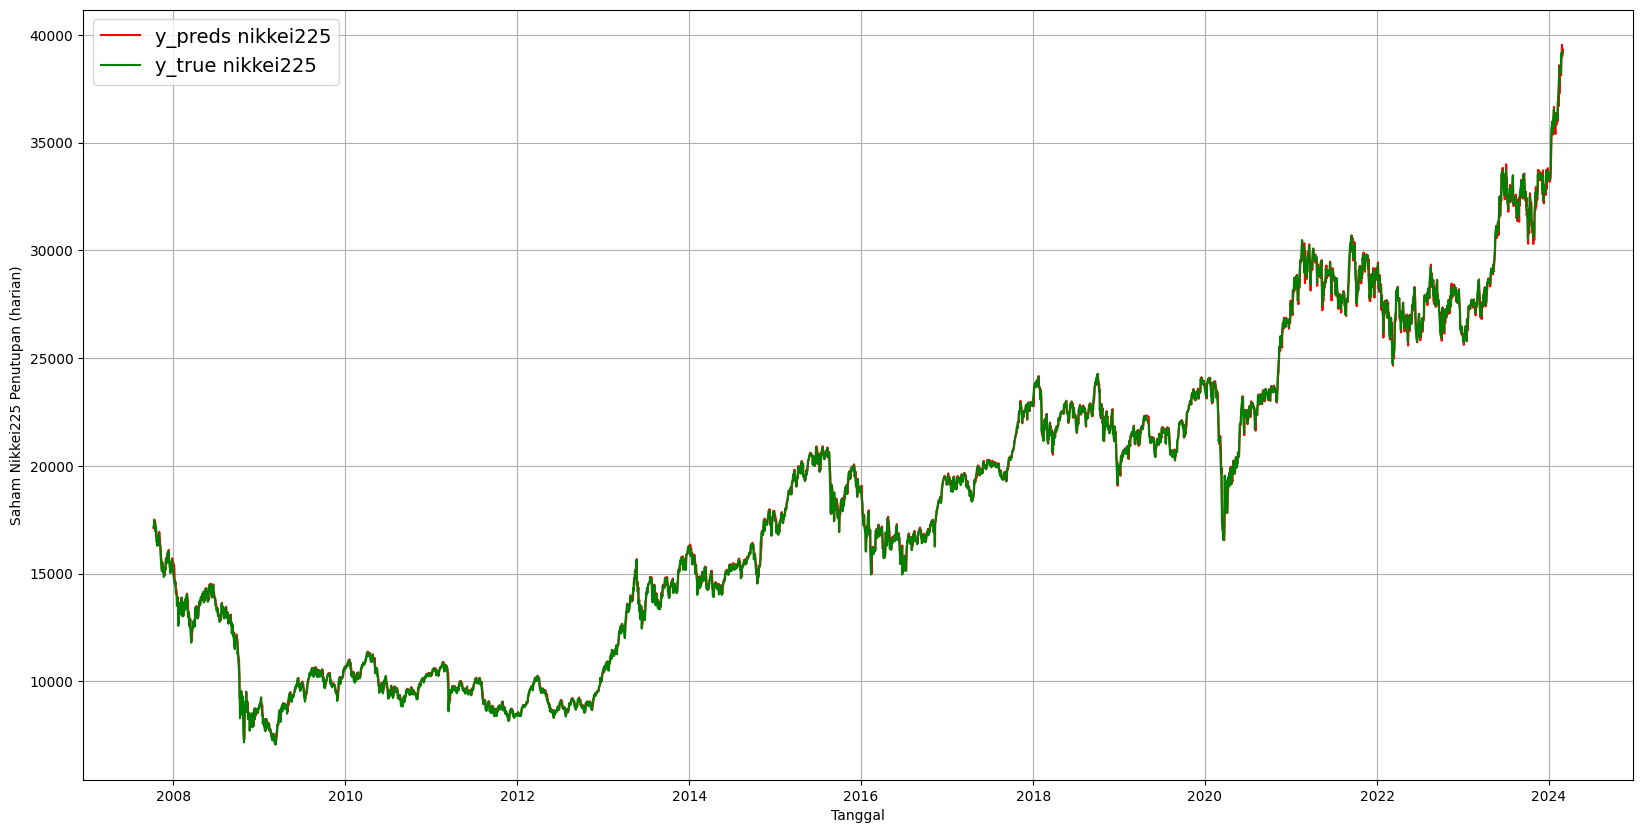

In [228]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_8_preds, format = "-",label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-",label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_8_plot_prediksi_stackedLSTM_uni.png')


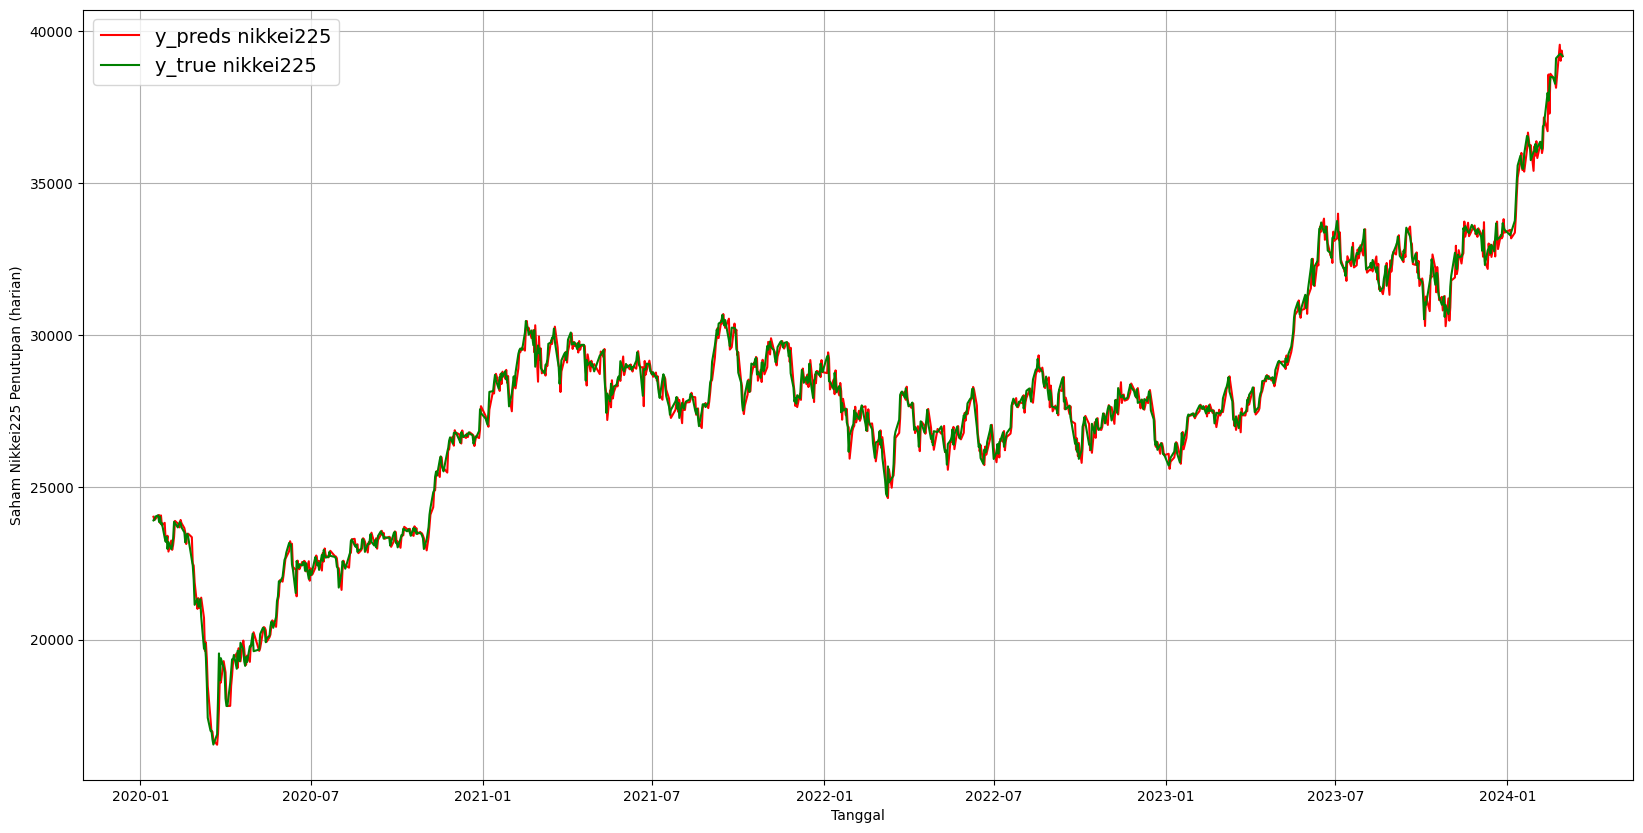

In [229]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_8_preds, format = "-",start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-",start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_8_plot_prediksi_stackedLSTM_uni_zoomin.png')


simpan model trained ke bentuk .h5

In [230]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_8, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_8_stackedLSTM_univariate.h5")


<ipython-input-230-d9a4fc01d5ed>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_8, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_8_stackedLSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_8 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_8_stackedLSTM_univariate.h5")


# Model 9: Bidirectional LSTM Univariate

In [231]:
train_nikkeiWindows.shape

(16040, 28)

In [232]:
test_nikkeiLabels.shape

(4010,)

## Tuner Builder

In [233]:
def model_bidirectional_LSTM_uni_builder(hp):

  tf.random.set_seed(42)
  model_9 = tf.keras.models.Sequential([
          #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
          tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # ini lambda layer sumberny dari bangkit C4W3 lab1
                        input_shape=[WINDOW_SIZE]),

          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hp.Int('bi_lstm_n_units', min_value=32, max_value=256, step=32),
                                                             input_shape=(WINDOW_SIZE, 1),
                                                             return_sequences = False,
                                                             activation = "relu")),
          #tf.keras.layers.Dropout(0.2, seed=42),
          #tf.keras.layers.LSTM(128, return_sequences = False, activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(1)
          ], name = "model_9_bidirectionalLSTM_univariate")


  #compile model 2
  model_9.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_9

In [234]:
import keras_tuner as kt

tuner_bi_LSTM_uni = kt.Hyperband(model_bidirectional_LSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='bi_LSTM_univariate')

## Proses tuning


In [235]:
tuner_bi_LSTM_uni.search(train_nikkeiWindows,
                         train_nikkeiLabels,
                         epochs=10,
                         validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                         batch_size = 128)

Trial 30 Complete [00h 07m 28s]
val_loss: 0.005272137466818094

Best val_loss So Far: 0.005007456056773663
Total elapsed time: 01h 04m 41s


## Hasil parameter tuning terbaik

In [236]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_bi_LSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ["bi_lstm_n_units", 'learning_rate']
print('Best tune model bidirectional LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model bidirectional LSTM univariate:
bi_lstm_n_units: 160
learning_rate: 0.01


## Hasil semua parameter tuning

In [237]:
tuning = ["bi_lstm_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hp_all=tuner_bi_LSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hp_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_bi_LSTM_uni.csv')
df_hyparam


bi_lstm_n_units  learning_rate
0               160         0.0100
1               128         0.0100
2               224         0.0100
3               256         0.0100
4               192         0.0100
5               192         0.0100
6               256         0.0100
7               160         0.0100
8               256         0.0010
9               160         0.0100
10              256         0.0100
11              256         0.0010
12              160         0.0010
13               32         0.0010
14               64         0.0010
15               64         0.0100
16              256         0.0001
17               32         0.0010
18               64         0.0100
19              128         0.0010
20              224         0.0010
21              160         0.0001
22               32         0.0100
23              192         0.0010
24              128         0.0001
25               96         0.0001
26               32         0.0001
27              224         0.0001
28               64         0.0001
29              192         0.0001

In [238]:
tuner_bi_LSTM_uni.results_summary(num_trials=10)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/bi_LSTM_univariate
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
bi_lstm_n_units: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.005007456056773663

Trial 0028 summary
Hyperparameters:
bi_lstm_n_units: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005095466040074825

Trial 0029 summary
Hyperparameters:
bi_lstm_n_units: 224
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005272137466818094

Trial 0016 summary
Hyperparameters:
bi_lstm_n_units: 256
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.005274426657706499

Trial 0024 summary
Hyperparameters:
bi_lstm_n_

## Mengimplementasikan hyperparameter terbaik ke model

In [239]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_9 = tuner_bi_LSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [159]:
from tensorflow.keras.models import load_model

# Load the saved model
model_9 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")


In [240]:

# fit
history = model_9.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_9.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0300
Epoch 1: val_loss improved from inf to 0.01407, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate
126/126 [==============================] - 39s 277ms/step - loss: 0.0300 - val_loss: 0.0141
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0077
Epoch 2: val_loss did not improve from 0.01407
126/126 [==============================] - 29s 233ms/step - loss: 0.0077 - val_loss: 0.0227
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0066
Epoch 3: val_loss improved from 0.01407 to 0.00845, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate
126/126 [==============================] - 34s 271ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 4/50
126/126 [==============================] - ETA:

visualisasi model shape

In [241]:
model_9.summary()

Model: "model_9_bidirectionalLSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 28, 1)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 320)               207360    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 321       
                                                                 
Total params: 207681 (811.25 KB)
Trainable params: 207681 (811.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


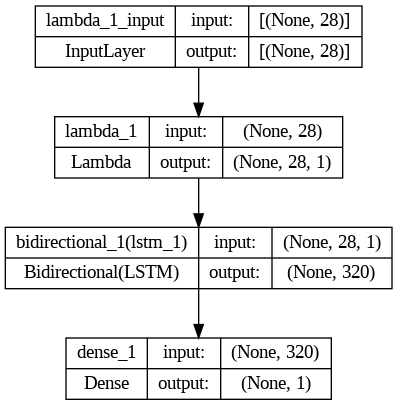

In [242]:
from tensorflow.keras.utils import plot_model

plot_model(model_9, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_biLSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

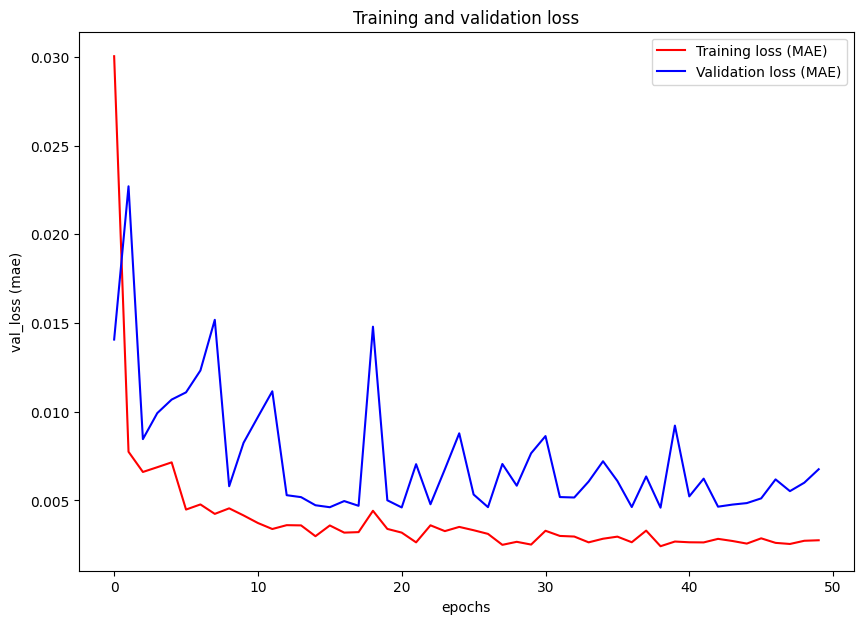

In [243]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_bidirectional_LSTM_uni.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_bidirectional_LSTM_uni.csv', index=False)


In [244]:
# mengevaluasi model 9 dari epochs terakhir
model_9.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 4s 28ms/step - loss: 0.0068


0.006756643299013376

In [245]:
# mengevaluasi dan load model 9 pada best epoch yang loss mae paling kecil sepanjang training

model_9 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate")
model_9.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 5s 40ms/step - loss: 0.0046


0.004589458461850882

In [160]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_9_preds = tf.squeeze(model_9.predict(test_nikkeiWindows))
model_9_preds



126/126 [==============================] - 4s 27ms/step


<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.43491715, 0.43713307, 0.43734246, ..., 0.9948693 , 1.0011936 ,
       0.99745876], dtype=float32)>

In [161]:
model_9_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.43491715, 0.43713307], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [162]:
denormalized_model_9_preds = scaler_univariate.inverse_transform([model_9_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [163]:
denormalized_model_9_preds = tf.squeeze(denormalized_model_9_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [164]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_9_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_9_preds)

model_9_results

{'mae': 179.69685,
 'mse': 64518.816,
 'rmse': 254.00554,
 'R-square': 0.998773033043488}

In [251]:
tf.squeeze(test_nikkeiLabels[:])

<tf.Tensor: shape=(4010,), dtype=float64, numpy=
array([0.43608654, 0.436546  , 0.44372504, ..., 1.        , 0.99919575,
       0.99812715])>

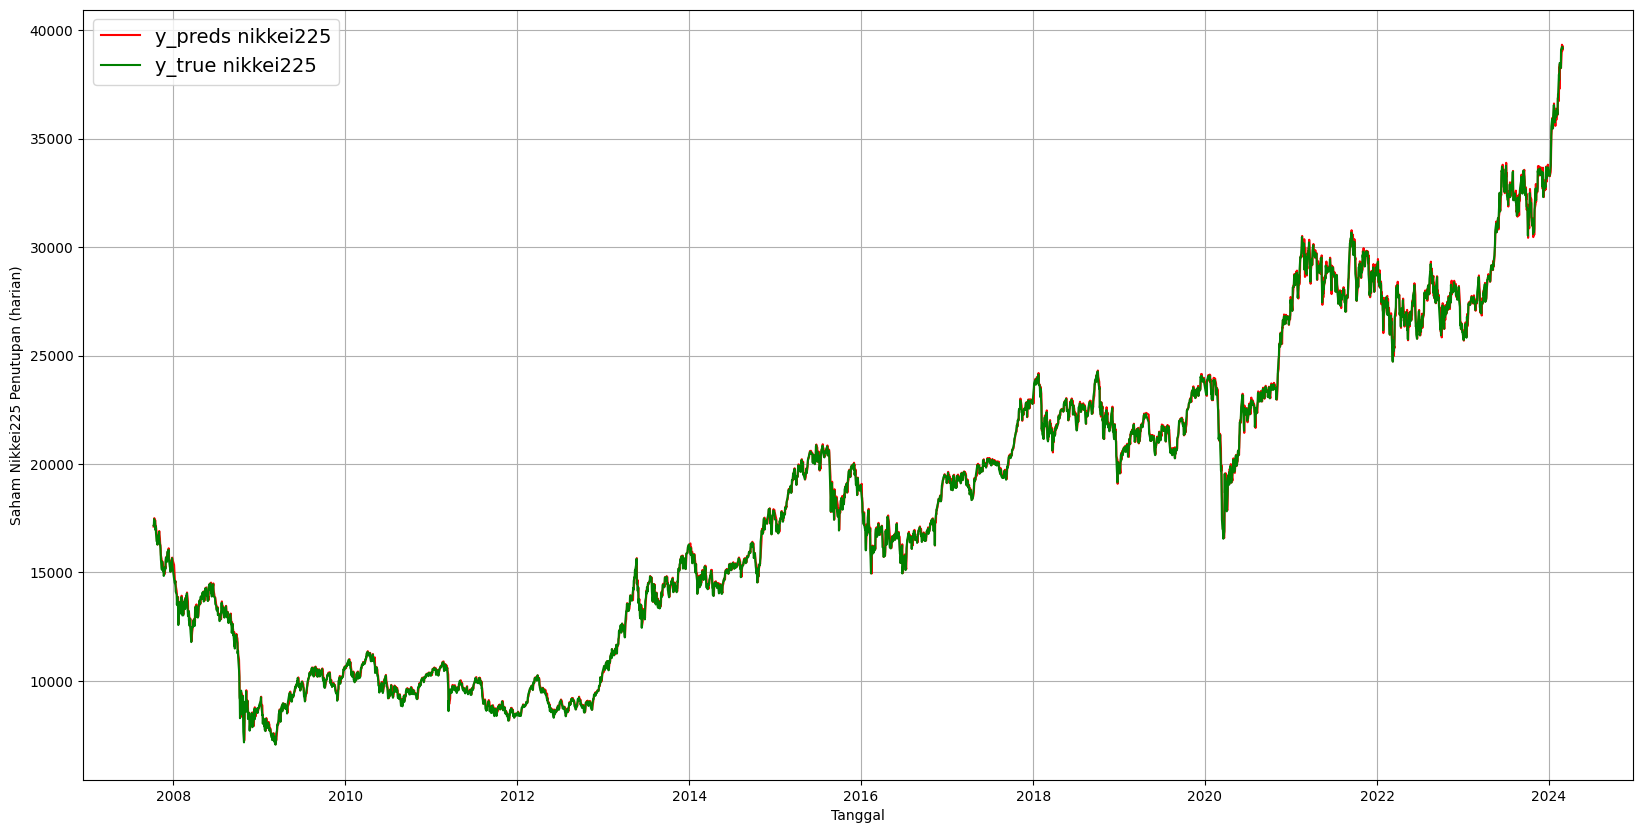

In [252]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_9_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_9_plot_prediksi_biLSTM_uni.png')


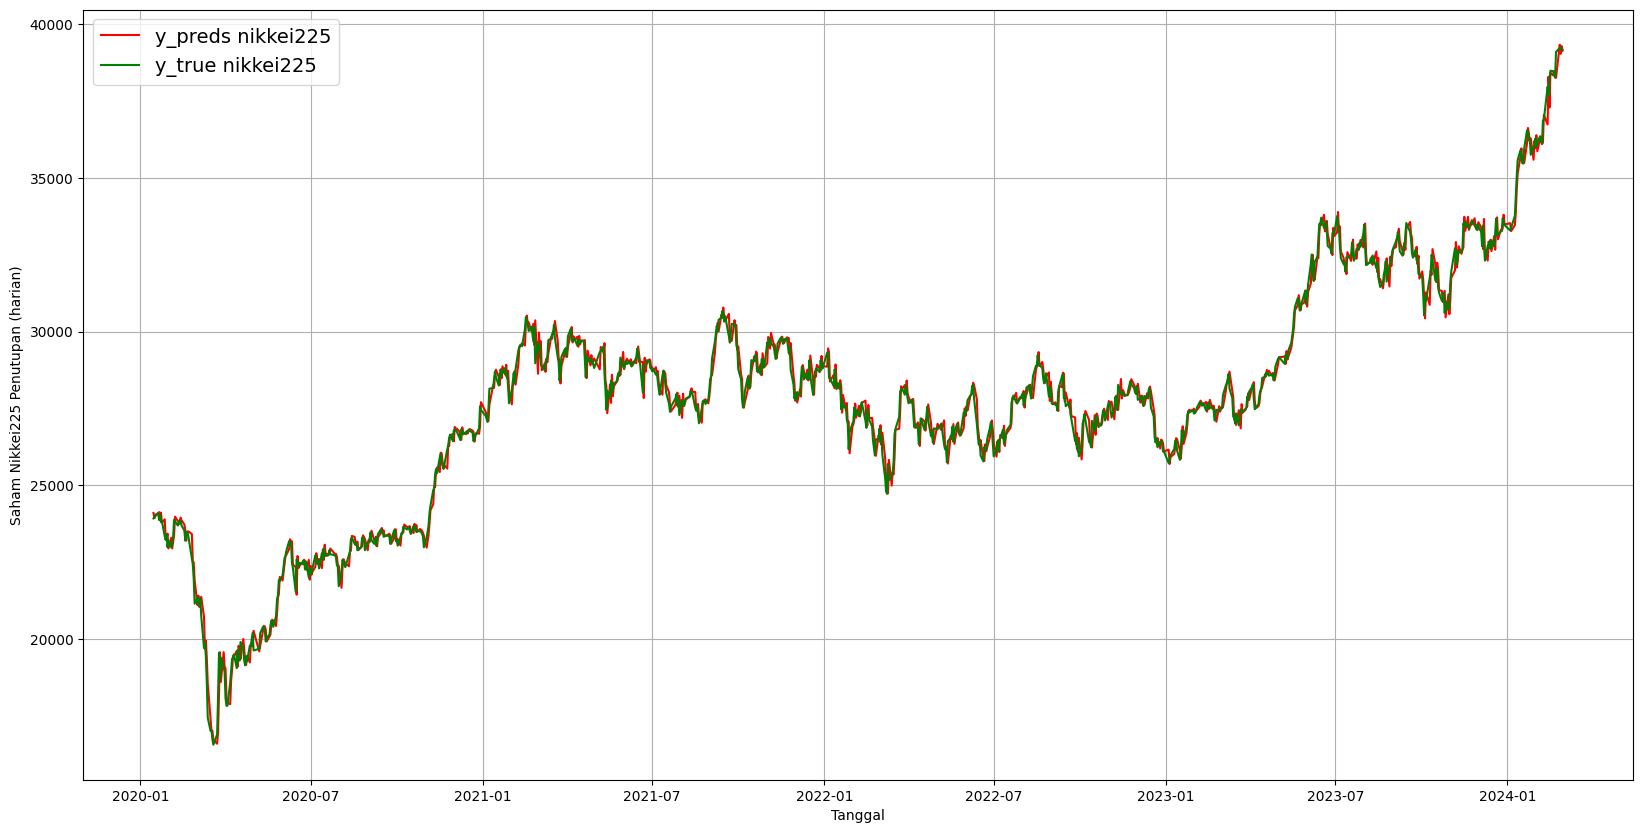

In [253]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_9_preds, format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-",start = 3000,  label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_9_plot_prediksi_biLSTM_uni_zoomin.png')


simpan model trained ke bentuk .h5

In [254]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_9, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")



<ipython-input-254-fa9d946b185f>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_9, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_9 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")


# Model 10: CNN-LSTM Univariate

## Tuner Builder

In [165]:
#create Conv1D model
def model_CNN_LSTM_uni_builder(hp):
  tf.random.set_seed(42)
  model_10 = tf.keras.models.Sequential([
      #layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
      tf.keras.layers.Conv1D(filters=hp.Int('Conv1D_n_filters', min_value=32, max_value=256, step=32),
                             kernel_size=hp.Int('Conv1_kernel_size', min_value=5, max_value=10, step=1),
                             strides=1,
                             padding="causal",
                             activation="relu",
                             input_shape=[WINDOW_SIZE, 1]),

      tf.keras.layers.LSTM(units = hp.Int('LSTM_n_units', min_value=32, max_value=256, step=32),
                           return_sequences=False),

      tf.keras.layers.Dense(1),
      #filters adalah jumlah hidden unit dalam layers tersebut
      # kernel size adalah ukuran dari window. Ex: kernel_size = 7 artinya melihat 7 value sekaligus
      # default nilai strides = 1, ini sudah sesuai karena sliding window bergeser satu timesteps
  ], name = "model_10_CNN-LSTM_univariate")

  #compile model 10
  model_10.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_10

In [166]:
import keras_tuner as kt

tuner_CNN_LSTM_uni = kt.Hyperband(model_CNN_LSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs',
                     project_name='CNN_LSTM_univariate')


## Proses tuning


In [167]:
tuner_CNN_LSTM_uni.search(train_nikkeiWindows,
                          train_nikkeiLabels,
                          epochs=10,
                          validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                          batch_size = 128)

Trial 30 Complete [00h 02m 15s]
val_loss: 0.007816476747393608

Best val_loss So Far: 0.005082588642835617
Total elapsed time: 00h 48m 49s


## Hasil parameter tuning terbaik

In [168]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_CNN_LSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['Conv1D_n_filters', 'Conv1_kernel_size', "LSTM_n_units", 'learning_rate']
print('Best tune model bidirectional LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model bidirectional LSTM univariate:
Conv1D_n_filters: 128
Conv1_kernel_size: 6
LSTM_n_units: 160
learning_rate: 0.001


## Hasil semua parameter tuning

In [169]:
tuning = ['Conv1D_n_filters', 'Conv1_kernel_size', "LSTM_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_CNN_LSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_best_hyperparameter_models/hp_CNN_LSTM_uni.csv')
df_hyparam



Conv1D_n_filters  Conv1_kernel_size  LSTM_n_units  learning_rate
0                128                  6           160         0.0010
1                224                  7           256         0.0010
2                 32                  6            64         0.0100
3                160                  8            96         0.0010
4                192                  8           192         0.0100
5                 32                  6            64         0.0100
6                128                  6           160         0.0010
7                 96                  9           192         0.0100
8                 96                  8            96         0.0100
9                256                  5           192         0.0100
10                64                  7           192         0.0100
11               192                  9            96         0.0001
12               192                 10           256         0.0001
13                64                  6           160         0.0100
14               224                  7           256         0.0010
15               192                  8           192         0.0100
16               128                  7           192         0.0100
17               224                  7           256         0.0010
18               256                  7           160         0.0001
19               128                  5           128         0.0001
20                32                 10            64         0.0010
21               128                  5            32         0.0001
22                32                 10           128         0.0100
23               256                  6           192         0.0001
24                96                  7           192         0.0001
25               192                  8           192         0.0100
26                64                  7           192         0.0100
27                64                  6            96         0.0001
28                64                  6           160         0.0100
29               224                  6           224         0.0100

In [170]:
tuner_CNN_LSTM_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_tuning_logs/CNN_LSTM_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0025 summary
Hyperparameters:
Conv1D_n_filters: 128
Conv1_kernel_size: 6
LSTM_n_units: 160
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.005082588642835617

Trial 0016 summary
Hyperparameters:
Conv1D_n_filters: 224
Conv1_kernel_size: 7
LSTM_n_units: 256
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.005508407484740019

Trial 0024 summary
Hyperparameters:
Conv1D_n_filters: 32
Conv1_kernel_size: 6
LSTM_n_units: 64
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.00562204560264945

Trial 0027 summary
Hyperparameters:
Conv1D_n_filters: 160
Conv1_kernel_size: 8
LSTM

## Mengimplementasikan hyperparameter terbaik ke model

In [171]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_10 = tuner_CNN_LSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_10 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_10_CNN-LSTM_univariate.h5")



In [172]:

# fit
history = model_10.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_10.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0125
Epoch 1: val_loss improved from inf to 0.01685, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_10_CNN-LSTM_univariate
126/126 [==============================] - 29s 202ms/step - loss: 0.0125 - val_loss: 0.0168
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0047
Epoch 2: val_loss improved from 0.01685 to 0.00776, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_10_CNN-LSTM_univariate
126/126 [==============================] - 26s 204ms/step - loss: 0.0047 - val_loss: 0.0078
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0040
Epoch 3: val_loss improved from 0.00776 to 0.00743, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_10_CNN-LSTM_univariate
126/126 [================

visualisasi model shape

In [173]:
model_10.summary()

Model: "model_10_CNN-LSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 128)           896       
                                                                 
 lstm_1 (LSTM)               (None, 160)               184960    
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
Total params: 186017 (726.63 KB)
Trainable params: 186017 (726.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


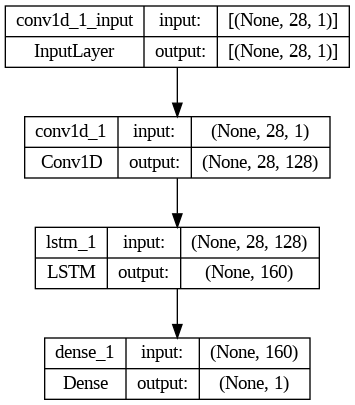

In [174]:
from tensorflow.keras.utils import plot_model

plot_model(model_10, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_plot/model_CNN-LSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

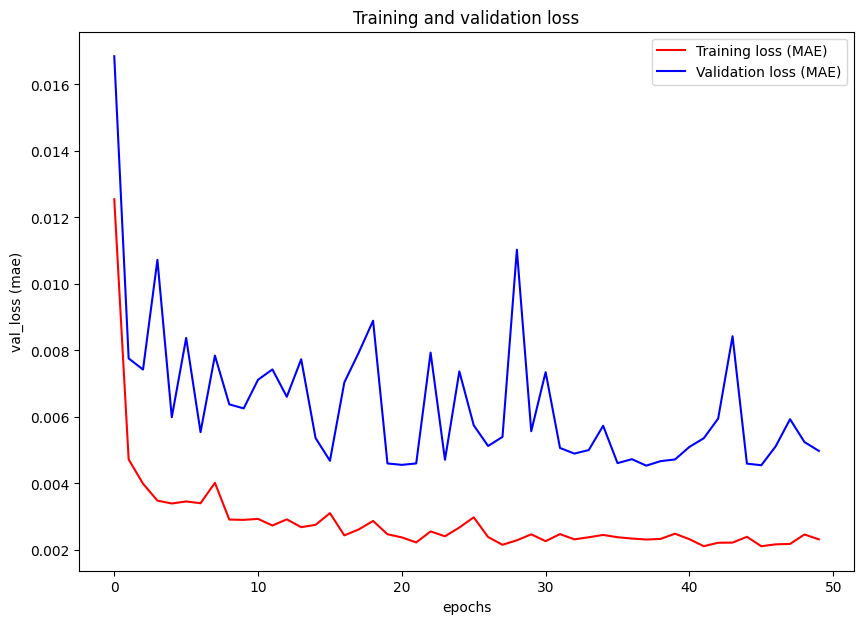

In [175]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# simpan visualisasi loss per epoch menjadi image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_visualization/loss_CNN-LSTM_uni.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_loss_value_per_epoch/loss_CNN-LSTM_uni.csv', index=False)


In [176]:
# mengevaluasi model 9 dari epochs terakhir
model_10.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 3s 21ms/step - loss: 0.0050


0.004979301709681749

In [177]:
# mengevaluasi dan load model 9 pada best epoch yang loss mae paling kecil sepanjang training

model_10= tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_model_best_epoch/model_10_CNN-LSTM_univariate")
model_10.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 3s 21ms/step - loss: 0.0045


0.0045359754003584385

In [178]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_10_preds = tf.squeeze(model_10.predict(test_nikkeiWindows))
model_10_preds



126/126 [==============================] - 3s 20ms/step


<tf.Tensor: shape=(4010,), dtype=float32, numpy=
array([0.43385243, 0.4360275 , 0.43626168, ..., 0.9957997 , 0.9993077 ,
       0.9975285 ], dtype=float32)>

In [179]:
model_10_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.43385243, 0.4360275 ], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [180]:
denormalized_model_10_preds = scaler_univariate.inverse_transform([model_10_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [181]:
denormalized_model_10_preds = tf.squeeze(denormalized_model_10_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [182]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_10_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_10_preds)

model_10_results

{'mae': 177.60278,
 'mse': 62815.855,
 'rmse': 250.63092,
 'R-square': 0.9988054186426195}

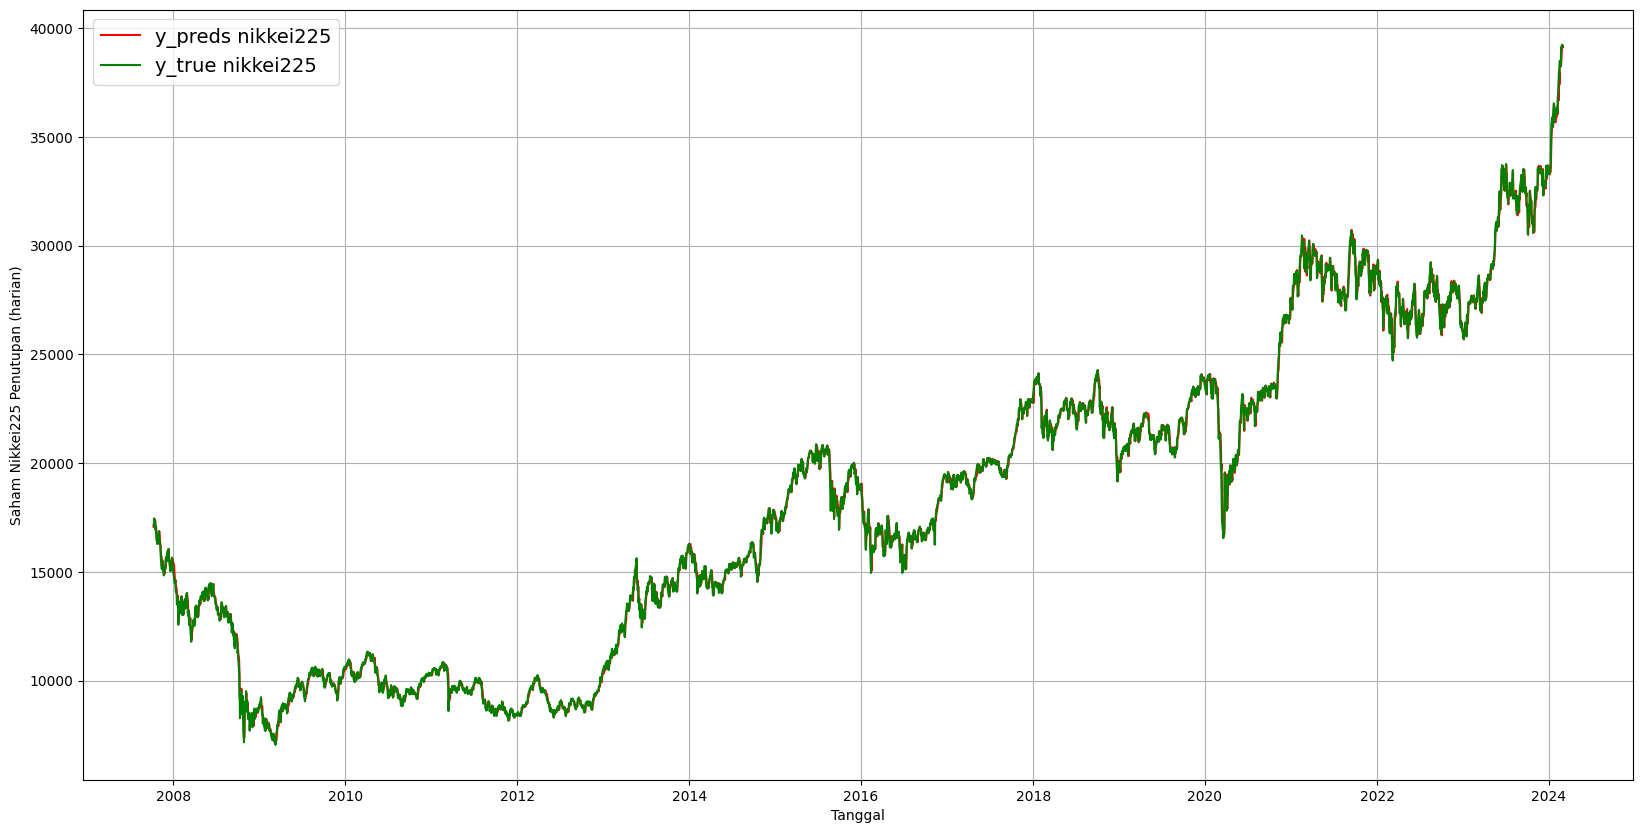

In [183]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_10_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_10_plot_prediksi_CNN-LSTM_uni.png')


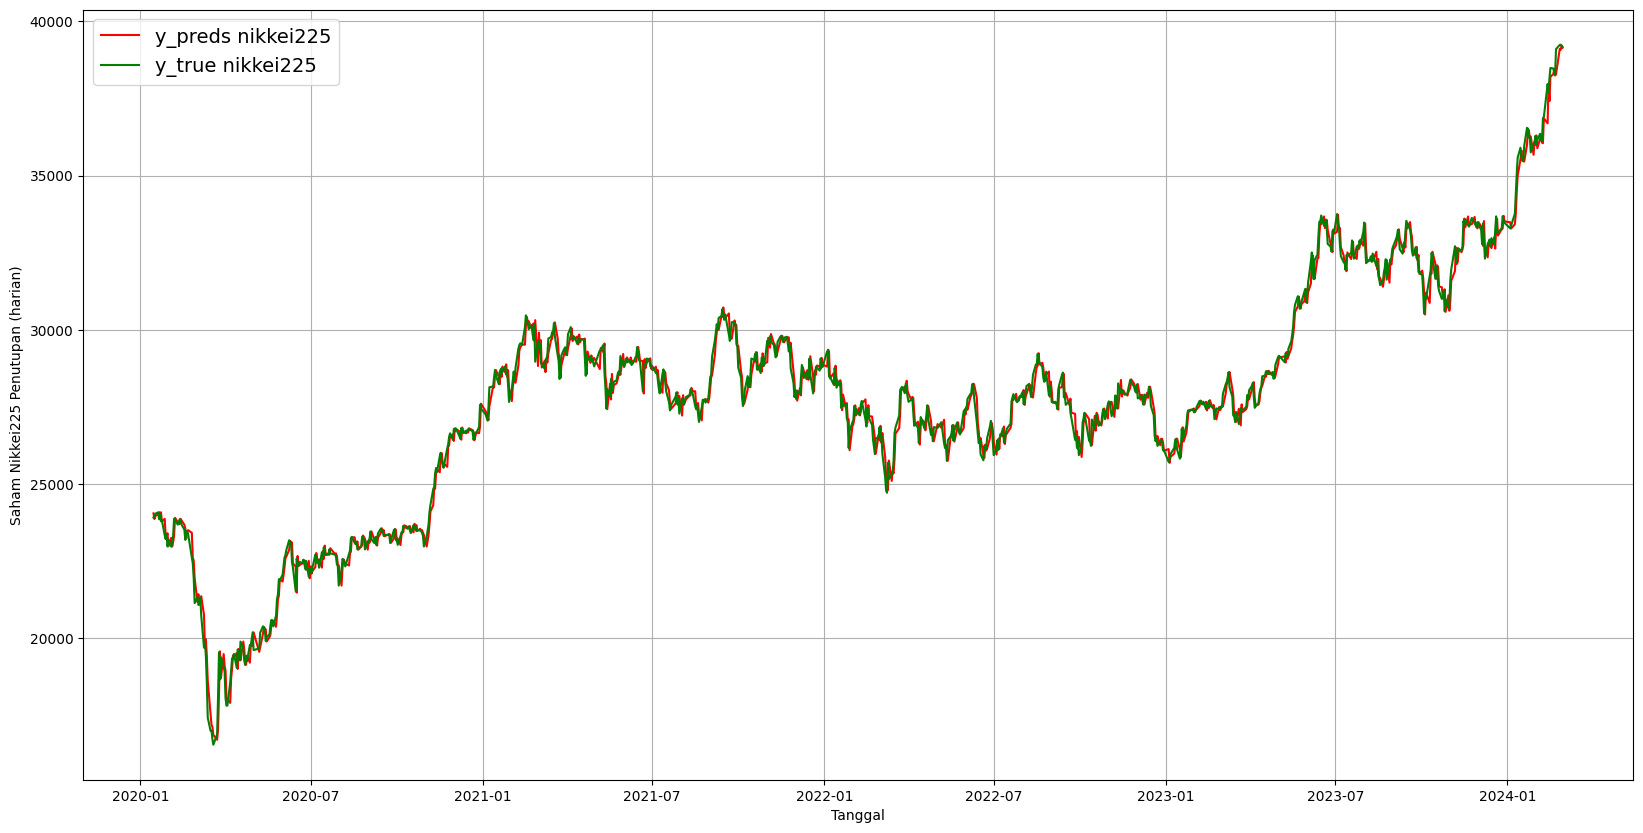

In [184]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_10_preds, format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_visualisasi_prediksi_time_series/model_10_plot_prediksi_CNN-LSTM_uni_zoomin.png')


simpan model trained ke bentuk .h5

In [185]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_10, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_10_CNN-LSTM_univariate.h5")



<ipython-input-185-53de2e9ed345>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_10, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_10_CNN-LSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_10 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_saved_models/model_10_CNN-LSTM_univariate.h5")



# visualisasi hasil evaluasi metrik nilai ternormalisasi

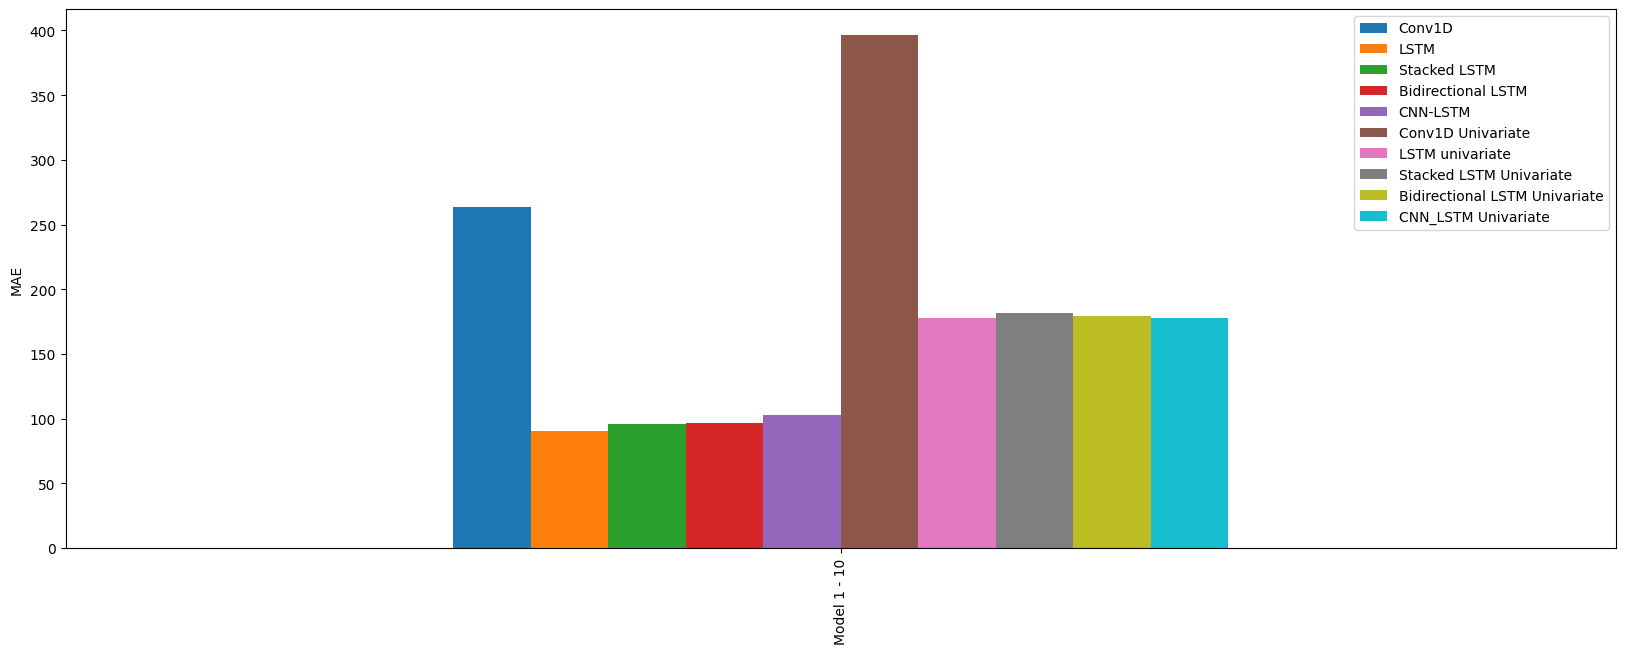

In [186]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["mae"],
              "LSTM": model_2_results["mae"],
              "Stacked LSTM" : model_3_results["mae"],
              "Bidirectional LSTM" : model_4_results["mae"],
              "CNN-LSTM": model_5_results["mae"],
              "Conv1D Univariate" : model_6_results["mae"],
              "LSTM univariate" : model_7_results["mae"],
              "Stacked LSTM Univariate" : model_8_results["mae"],
              "Bidirectional LSTM Univariate" : model_9_results["mae"],
              "CNN_LSTM Univariate" : model_10_results["mae"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("MAE")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_evaluation_metrics/hasil_denormalisasi/MAE_visualization.png")

plt.show()

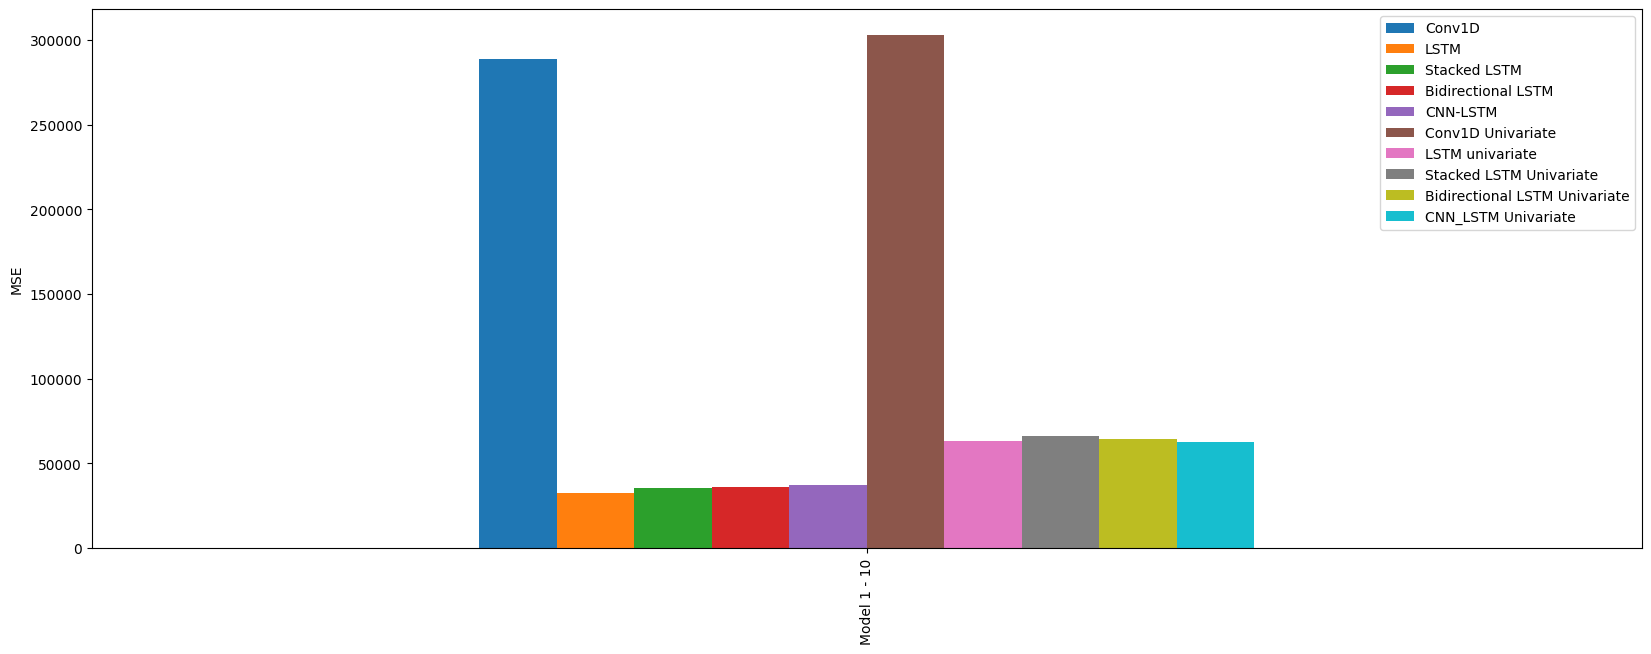

In [187]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["mse"],
              "LSTM": model_2_results["mse"],
              "Stacked LSTM" : model_3_results["mse"],
              "Bidirectional LSTM" : model_4_results["mse"],
              "CNN-LSTM": model_5_results["mse"],
              "Conv1D Univariate" : model_6_results["mse"],
              "LSTM univariate" : model_7_results["mse"],
              "Stacked LSTM Univariate" : model_8_results["mse"],
              "Bidirectional LSTM Univariate" : model_9_results["mse"],
              "CNN_LSTM Univariate" : model_10_results["mse"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("MSE")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_evaluation_metrics/hasil_denormalisasi/MSE_visualization.png")

plt.show()

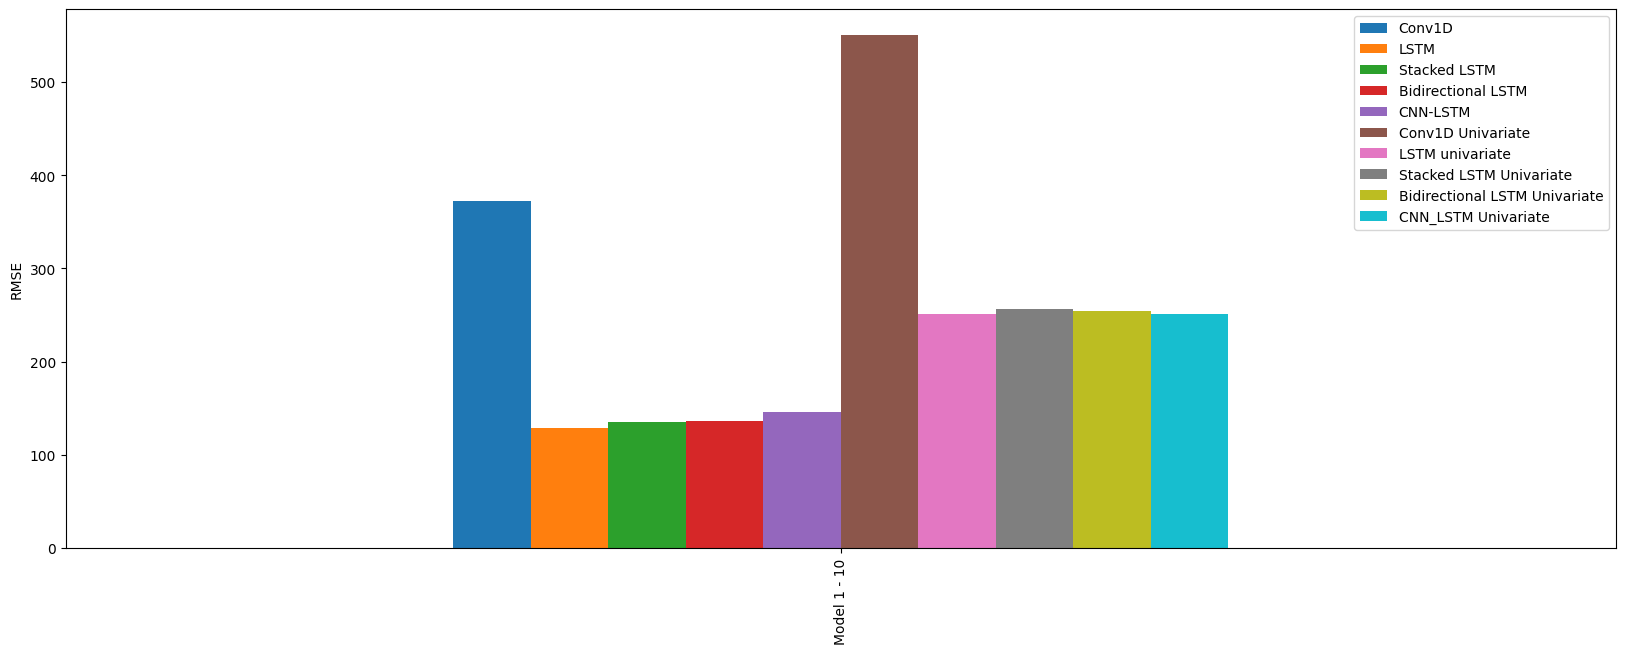

In [188]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["rmse"],
              "LSTM": model_2_results["rmse"],
              "Stacked LSTM" : model_3_results["rmse"],
              "Bidirectional LSTM" : model_4_results["rmse"],
              "CNN-LSTM": model_5_results["rmse"],
              "Conv1D Univariate" : model_6_results["rmse"],
              "LSTM univariate" : model_7_results["rmse"],
              "Stacked LSTM Univariate" : model_8_results["rmse"],
              "Bidirectional LSTM Univariate" : model_9_results["rmse"],
              "CNN_LSTM Univariate" : model_10_results["rmse"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("RMSE")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_evaluation_metrics/hasil_denormalisasi/RMSE_visualization.png")

plt.show()

In [ ]:

# # membuat dataframe

# df = pd.DataFrame({
#               "Conv1D": model_1_results["mape"],
#               "LSTM": model_2_results["mape"],
#               "Stacked LSTM" : model_3_results["mape"],
#               "Bidirectional LSTM" : model_4_results["mape"],
#               "CNN-LSTM": model_5_results["mape"],
#               "Conv1D Univariate" : model_6_results["mape"],
#               "LSTM univariate" : model_7_results["mape"],
#               "Stacked LSTM Univariate" : model_8_results["mape"],
#               "Bidirectional LSTM Univariate" : model_9_results["mape"],
#               "CNN_LSTM Univariate" : model_10_results["mape"]},
#              index = ["Model 1 - 10"])

# # representasi dengan bar chart
# ax = df.plot(figsize=(20, 7), kind="bar")
# ax.set_ylabel("MAPE")

# plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_evaluation_metrics/hasil_denormalisasi/MAPE_visualization.png")

# plt.show()

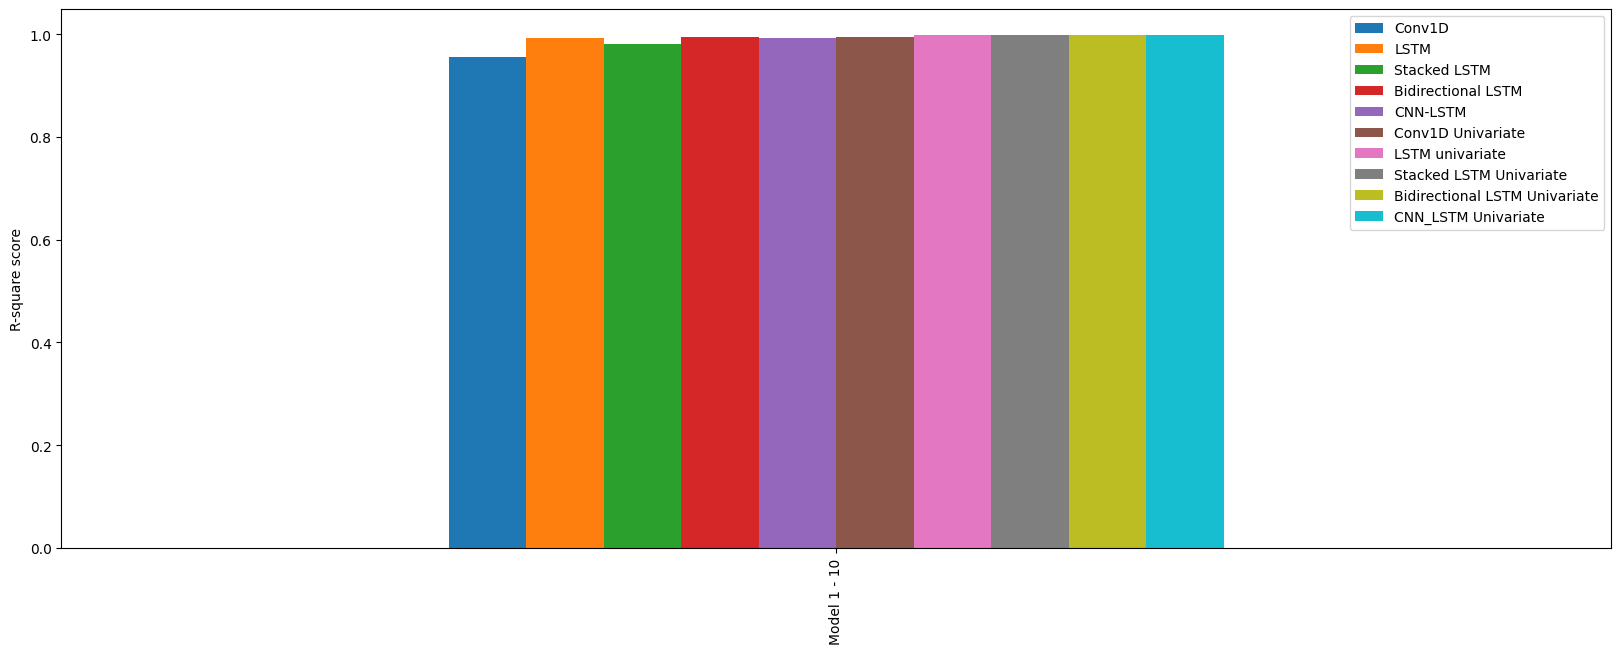

In [189]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["R-square"],
              "LSTM": model_2_results["R-square"],
              "Stacked LSTM" : model_3_results["R-square"],
              "Bidirectional LSTM" : model_4_results["R-square"],
              "CNN-LSTM": model_5_results["R-square"],
              "Conv1D Univariate" : model_6_results["R-square"],
              "LSTM univariate" : model_7_results["R-square"],
              "Stacked LSTM Univariate" : model_8_results["R-square"],
              "Bidirectional LSTM Univariate" : model_9_results["R-square"],
              "CNN_LSTM Univariate" : model_10_results["R-square"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("R-square score")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_evaluation_metrics/hasil_denormalisasi/R-square_visualization.png")

plt.show()

# rangkum evaluasi metrics dari semua model menjadi satu csv

In [190]:

results_list = [model_1_results,
                model_2_results,
                model_3_results,
                model_4_results,
                model_5_results,
                model_6_results,
                model_7_results,
                model_8_results,
                model_9_results,
                model_10_results]


# menggabungkan hasil evaluasi menjadi dictionary
results_dict = {
    'Model_1 : Conv1D Multivariate': model_1_results,
    'Model_2 : LSTM Multivariate': model_2_results,
    'Model_3 : Stacked LSTM Multivariate': model_3_results,
    'Model_4 : Bidirectional LSTM Multivariate': model_4_results,
    'Model_5 : CNN-LSTM Multivariate': model_5_results,
    'Model_6 : Conv1D Univariate': model_6_results,
    'Model_7 : LSTM Univariate': model_7_results,
    'Model_8 : Stacked LSTM Univariate': model_8_results,
    'Model_9 : Bidirectional LSTM Univariate': model_9_results,
    'Model_10 : CNN-LSTM Univariate': model_10_results

}

# Nama dataframe
df_kumpulan_evaluation_metrics = pd.DataFrame(results_dict).T

# memberi nama untuk index
df_kumpulan_evaluation_metrics.index.name = 'Daftar Model'

# konversi dataframe ke CSV
df_kumpulan_evaluation_metrics.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window28/8020_evaluation_metrics/hasil_denormalisasi/kumpulan_evaluasi_metrics.csv')

# print output
(df_kumpulan_evaluation_metrics)

mae            mse  \
Daftar Model                                                           
Model_1 : Conv1D Multivariate              263.272003  288595.000000   
Model_2 : LSTM Multivariate                 90.691597   32233.001953   
Model_3 : Stacked LSTM Multivariate         95.708427   35736.910156   
Model_4 : Bidirectional LSTM Multivariate   96.242569   36183.015625   
Model_5 : CNN-LSTM Multivariate            102.922997   37044.183594   
Model_6 : Conv1D Univariate                396.703552  303122.093750   
Model_7 : LSTM Univariate                  178.141769   63116.347656   
Model_8 : Stacked LSTM Univariate          181.610367   65984.289062   
Model_9 : Bidirectional LSTM Univariate    179.696854   64518.816406   
Model_10 : CNN-LSTM Univariate             177.602783   62815.855469   

                                                 rmse  R-square  
Daftar Model                                                     
Model_1 : Conv1D Multivariate              372.311310  0.954881  
Model_2 : LSTM Multivariate                128.249847  0.991808  
Model_3 : Stacked LSTM Multivariate        135.340729  0.980835  
Model_4 : Bidirectional LSTM Multivariate  136.101837  0.993543  
Model_5 : CNN-LSTM Multivariate            145.548355  0.992004  
Model_6 : Conv1D Univariate                550.565247  0.994235  
Model_7 : LSTM Univariate                  251.229675  0.998800  
Model_8 : Stacked LSTM Univariate          256.874084  0.998745  
Model_9 : Bidirectional LSTM Univariate    254.005539  0.998773  
Model_10 : CNN-LSTM Univariate             250.630920  0.998805